In [13]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None)

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)

y_labels

inputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/01/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/01/Y.txt",index_col=None,delim_whitespace=True,header=None).values

inputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/02/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/02/Y.txt",index_col=None,delim_whitespace=True,header=None).values

inputData_2 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/03/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_2 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/03/Y.txt",index_col=None,delim_whitespace=True,header=None).values

inputData_3 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/03/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_3 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/03/Y.txt",index_col=None,delim_whitespace=True,header=None).values


X0 = torch.tensor(inputData_0)
Y0 = torch.tensor(outputData_0)

X1 = torch.tensor(inputData_1)
Y1 = torch.tensor(outputData_1)

X2 = torch.tensor(inputData_1)
Y2 = torch.tensor(outputData_1)

X3 = torch.tensor(inputData_1)
Y3 = torch.tensor(outputData_1)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
                X1.float(),
                Y1.float(),
                test_size=0.1,
                random_state=seed
            )

In [16]:
y_train.mean(axis=0)

tensor([152.9408, 114.7811])

In [17]:
def proxy(a,y_train,m0,output):
    m_t = (m0-y_train.mean(axis=0))/y_train.std(axis=0)
    y_t = (y_train-y_train.mean(axis=0))/y_train.std(axis=0)
    a=torch.tensor(a)
    res = ((a*m_t-y_t)**2).mean(axis=0).detach().numpy()
    return res[output]

In [18]:
m=20
n=180
a=np.random.choice(range(X0.shape[0]),n,replace=False)
a2 = np.random.choice(range(X0.shape[0]),n,replace=False)
b=np.random.choice(range(X_train.shape[0]),m,replace=False)


emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)
emulator_2 = GPE.ensemble(X2,Y2,mean_func="linear",training_iter=500)
emulator_3 = GPE.ensemble(X3,Y3,mean_func="linear",training_iter=500)
emulator_1 = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="linear",training_iter=500)
m0 = emulator_0.predict(X_train[b,:])

a_d=np.zeros(y_train.shape[1])
for l in range(y_train.shape[1]):
    result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
    print(result.x)
    a_d[l]=result.x

a_d=torch.tensor(a_d)
#a_d=torch.ones(a_d.shape)
print(a_d)


m0 = emulator_0.predict(X_train[b,:])
y_adjust = torch.tensor(y_train[b] - a_d*m0)
delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
MSE_a = ((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()
R2_a = (1-((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()


0
1
0
1
0
1
0
1
[0.6500549]
[0.9566732]
tensor([0.6501, 0.9567], dtype=torch.float64)
0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_75050/719738793.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[b] - a_d*m0)


1


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_75050/719738793.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_a = ((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_75050/719738793.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_a = (1-((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()


In [19]:
emulators=[emulator_0,emulator_2,emulator_3]

In [20]:
m0 = emulator_0.predict(X_train[b,:])
a_d=np.zeros(y_train.shape[1])
for l in range(y_train.shape[1]):
    result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
    print(result.x)
    a_d[l]=result.x

a_d=torch.tensor(a_d)

[0.6500549]
[0.9566732]


In [21]:
m0 = emulator_0.predict(X_train[b,:])

m_t = emulator_0.normalise_output(m0)
y_t = emulator_0.normalise_output(y_train[b,:])

a_d=np.zeros(y_train.shape[1])
for l in range(y_train.shape[1]):
    result = scipy.optimize.minimize(proxy, 1, args=(y_t,m_t,l), method='Nelder-Mead', tol=1e-8)
    print(result.x)
    a_d[l]=result.x

a_d=torch.tensor(a_d)

[0.6500549]
[0.95667329]


In [22]:
# def proxy_cohort(a,y_test,emulators,x_test,output):
#     a=torch.tensor(a)
#     res=torch.zeros((y_test.shape[1]))
#     m0=torch.zeros(y_test.shape)
#     for i in range(len(emulators)):
#         m0+=a[i]*emulators[i].predict(x_test)
#     res += ((m0-y_test)**2).mean(axis=0).detach().numpy()
#     return res[output]

In [23]:
MSE_a

array([20.26896532,  1.95975713])

In [24]:
R2_a

array([0.99382497, 0.99665869])

In [25]:
model_d = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators[0]],a=torch.tensor([[1],[1]]))#,a=a_d)

0
1


In [26]:
model_dc = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators,a=a_d)

0


IndexError: too many indices for tensor of dimension 1

In [29]:
model_dc_a = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators)

0
1


In [30]:
emulator_1.MSE(X_test,y_test)

tensor([67.5535, 11.3526], grad_fn=<MeanBackward1>)

In [31]:
emulator_1.R2(X_test,y_test)

tensor([0.9794, 0.9806], grad_fn=<RsubBackward1>)

In [32]:
model_d.MSE(X_test,y_test)

tensor([22.6159,  4.4557], grad_fn=<MeanBackward1>)

In [33]:
model_d.R2(X_test,y_test)

tensor([0.9931, 0.9924], grad_fn=<RsubBackward1>)

In [34]:
model_dc.MSE(X_test,y_test)

NameError: name 'model_dc' is not defined

In [ ]:
model_dc.R2(X_test,y_test)

In [ ]:
model_dc_a.MSE(X_test,y_test)

In [ ]:
model_dc_a.R2(X_test,y_test)

In [ ]:
for param_name, param in model_dc.models[0].named_parameters():
    print(param_name)

In [ ]:
for param_name, param in model_dc.models[0].named_parameters():
    print(param)

In [35]:
for param_name, param in model_d.models[0].named_parameters():
    print(param)

Parameter containing:
tensor([-5.6647], requires_grad=True)
Parameter containing:
tensor([-12.0657])
Parameter containing:
tensor(-0.2172)
Parameter containing:
tensor([[18.4792, 18.9208, 19.4780,  1.1038,  6.6121,  1.3020]])
Parameter containing:
tensor([[ 2.1611e-03],
        [-7.3494e-03],
        [ 1.2609e-04],
        [-1.6859e+00],
        [-2.2766e-01],
        [-5.3467e-01]])
Parameter containing:
tensor([1.8969])
Parameter containing:
tensor(-10.5757, requires_grad=True)
Parameter containing:
tensor([[ 8.2804, 10.5336,  8.3347,  5.9543,  8.2927,  6.8772]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0141],
        [-0.0048],
        [-0.0070],
        [ 0.1528],
        [-0.0429],
        [-0.0499]], requires_grad=True)
Parameter containing:
tensor([-0.0115], requires_grad=True)


In [36]:
for param_name, param in emulator_2.models[1].named_parameters():
    print(param)

Parameter containing:
tensor([-8.6033])
Parameter containing:
tensor(-1.1691)
Parameter containing:
tensor([[ 1.6789,  3.8169, -0.2455, 17.6619, 21.0282, 19.4976]])
Parameter containing:
tensor([[-1.1150e+00],
        [-3.2489e-01],
        [-5.6103e-01],
        [-1.0441e-02],
        [-6.8956e-03],
        [-3.0635e-04]])
Parameter containing:
tensor([1.1297])


In [37]:
def m0_mat(y_test,emulators,x_test,output):

    m0=torch.zeros((y_test.shape[0],len(emulators)))
    for i in range(len(emulators)):
        m0[:,i]=(emulators[i].predict(x_test)[:,output]-y_train.mean(axis=0)[output])/y_train.std(axis=0)[output]


    return m0

In [38]:
m0=m0_mat(y_train[b],emulators,X_train[b],0)

In [39]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score




In [40]:
model = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=1, include_bias=False,interaction_only=False)),
    ('lasso', LassoCV(n_alphas=1000,max_iter=10000))
])




In [41]:
m0.mean()

tensor(0.2332)

In [42]:
y_t.mean()

tensor(-0.1174, dtype=torch.float64)

In [43]:
a_d=torch.zeros((y_train.shape[1],len(emulators)))
for i in range(y_train.shape[1]):
    m0=m0_mat(y_train[b],emulators,X_train[b],i)
    # fit to an order-3 polynomial data
    y_t=(y_train[b,i]-y_train.mean(axis=0)[i])/y_train.std(axis=0)[i]
    model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
    a_d[i]=torch.tensor(model.named_steps['lasso'].coef_)

In [44]:
a_d

tensor([[0.0390, 0.9539, 0.0000],
        [0.0000, 0.9953, 0.0078]])

In [45]:
model.named_steps['lasso'].coef_

array([0.        , 0.9953377 , 0.00777153], dtype=float32)

In [46]:
model_dc = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators)

0
1


In [47]:
model_dc.R2(X_test,y_test)

tensor([0.9981, 0.9990], grad_fn=<RsubBackward1>)

In [48]:
meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

Ys=[]
Xs=[]
emulators=[]
for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    Xs.append(torch.tensor(inputData))
    Ys.append(torch.tensor(outputData))
    emulator = GPE.ensemble(Xs[i],Ys[i],mean_func="linear",training_iter=500)
    emulators.append(emulator)

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [49]:
model = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=1, include_bias=False,interaction_only=False)),
    ('lasso', LassoCV(n_alphas=1000,max_iter=10000))
])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
                Xs[-1].float(),
                Ys[-1].float(),
                test_size=0.1,
                random_state=seed
            )

In [51]:
n=40
b=np.random.choice(range(X_train.shape[0]),n,replace=False)

In [52]:



emulators2=emulators[0:16]


a_d=torch.zeros((y_train.shape[1],len(emulators2)))
for i in range(y_train.shape[1]):
    m0=m0_mat(y_train[b],emulators2,X_train[b],i)
    # fit to an order-3 polynomial data
    y_t=(y_train[b,i]-y_train.mean(axis=0)[i])/y_train.std(axis=0)[i]
    model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
    a_d[i]=torch.tensor(model.named_steps['lasso'].coef_)

In [53]:
a_d

tensor([[0.0000, 0.0000, 0.3430, 0.0000, 0.0000, 0.0000, 0.0192, 0.0000, 0.0896,
         0.1478, 0.0000, 0.2606, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2390, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5475,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0116, 0.0000, 0.0000]])

In [54]:
model_dc = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d)

0
1


In [55]:
model_dc.R2(X_test,y_test)

tensor([0.9974, 0.9926], grad_fn=<RsubBackward1>)

In [56]:
a_d

tensor([[0.0000, 0.0000, 0.3430, 0.0000, 0.0000, 0.0000, 0.0192, 0.0000, 0.0896,
         0.1478, 0.0000, 0.2606, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2390, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5475,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0116, 0.0000, 0.0000]])

In [57]:
a_d

tensor([[0.0000, 0.0000, 0.3430, 0.0000, 0.0000, 0.0000, 0.0192, 0.0000, 0.0896,
         0.1478, 0.0000, 0.2606, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2390, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5475,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0116, 0.0000, 0.0000]])

In [58]:
model_dc = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d,a_indicator=True)

0
1


In [59]:
model_dc.R2(X_test,y_test)

tensor([0.9971, 0.9925], grad_fn=<RsubBackward1>)

In [60]:
model_dc.models[1].a

Parameter containing:
tensor([ 0.2469,  0.7102, -0.0455], requires_grad=True)

In [61]:
emulators[17].R2(X_test,y_test)

tensor([1.0000, 1.0000], grad_fn=<RsubBackward1>)

In [62]:
for param_name, param in model_dc.models[0].named_parameters():
    print(param_name)

a
likelihood.noise_covar.raw_noise
covar_module.kernels.0.ref_model.likelihood.noise_covar.raw_noise
covar_module.kernels.0.ref_model.covar_module.raw_outputscale
covar_module.kernels.0.ref_model.covar_module.base_kernel.raw_lengthscale
covar_module.kernels.0.ref_model.mean_module.weights
covar_module.kernels.0.ref_model.mean_module.bias
covar_module.kernels.1.ref_model.likelihood.noise_covar.raw_noise
covar_module.kernels.1.ref_model.covar_module.raw_outputscale
covar_module.kernels.1.ref_model.covar_module.base_kernel.raw_lengthscale
covar_module.kernels.1.ref_model.mean_module.weights
covar_module.kernels.1.ref_model.mean_module.bias
covar_module.kernels.2.ref_model.likelihood.noise_covar.raw_noise
covar_module.kernels.2.ref_model.covar_module.raw_outputscale
covar_module.kernels.2.ref_model.covar_module.base_kernel.raw_lengthscale
covar_module.kernels.2.ref_model.mean_module.weights
covar_module.kernels.2.ref_model.mean_module.bias
covar_module.kernels.3.ref_model.likelihood.noise_

In [63]:
for param_name, param in model_dc.models[0].named_parameters():
    print(param)

Parameter containing:
tensor([0.3821, 0.1322, 0.1351, 0.1855, 0.2324], requires_grad=True)
Parameter containing:
tensor([-11.5108], requires_grad=True)
Parameter containing:
tensor([-11.7058])
Parameter containing:
tensor(-0.6669)
Parameter containing:
tensor([[15.9063, 14.1310, 17.8599,  0.9970,  7.9245,  0.7080]])
Parameter containing:
tensor([[ 0.0085],
        [-0.0168],
        [ 0.0042],
        [-1.3241],
        [-0.1434],
        [-0.6539]])
Parameter containing:
tensor([1.4287])
Parameter containing:
tensor([-10.5743])
Parameter containing:
tensor(-0.9740)
Parameter containing:
tensor([[19.8134, 19.2104, 18.9932,  0.6887,  9.7956,  0.4916]])
Parameter containing:
tensor([[ 0.0029],
        [-0.0042],
        [ 0.0058],
        [-1.2995],
        [-0.1249],
        [-0.6256]])
Parameter containing:
tensor([1.1472])
Parameter containing:
tensor([-10.9071])
Parameter containing:
tensor(-0.1476)
Parameter containing:
tensor([[16.2812, 16.1037, 17.0666,  1.0149,  4.5041,  0.8942]]

In [64]:
torch.tensor([[1],[1]])[0]

tensor([1])

In [65]:
import time


In [66]:
R2=torch.zeros(7,2)
Ti=torch.zeros(7)
reps=5
n=40
for i in range(reps):
    
    b=np.random.choice(range(X_train.shape[0]),n,replace=False)
    
    start = time.time()
    model_f=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="linear",training_iter=500)
    R2[0]+=model_f.R2(X_test,y_test)/reps
    end = time.time()
    Ti[0]+=(end-start)/reps
    
#     start = time.time()
#     for j in range(len(emulators2)):
#         model_dc_1 = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[i]],a=torch.tensor([[1],[1]]))
#         R2[1]+=model_dc_1.R2(X_test,y_test)/(reps*len(emulators2))
#         print(model_dc_1.R2(X_test,y_test))
#         print(R2[1])
#     end = time.time()
#     Ti[1]+=(end-start)/reps
    
    em=np.random.randint(len(emulators2))
    start = time.time()
    model_dc_1 = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=torch.tensor([[1],[1]]))
    end = time.time()
    R2[1]+=model_dc_1.R2(X_test,y_test)/reps
    Ti[1]+=(end-start)/reps
    
    start = time.time()
    m0 = emulators2[0].predict(X_train[b,:])
    a_d=np.zeros((y_train.shape[1],1))
    for l in range(y_train.shape[1]):
        result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
        print(result.x)
        a_d[l]=result.x
    a_d=torch.tensor(a_d)
    model_dc_reg = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[0]],a=a_d)
    R2[2]+=model_dc_reg.R2(X_test,y_test)/reps
    end = time.time()
    Ti[2]+=(end-start)/reps
    

    
    start = time.time()
    model_dc_learned = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[0]])
    R2[3]+=model_dc_learned.R2(X_test,y_test)/reps
    end = time.time()
    Ti[3]+=(end-start)/reps
    
    start = time.time()
    model_dc_all = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2)
    R2[4]+=model_dc_all.R2(X_test,y_test)/reps
    end = time.time()
    Ti[4]+=(end-start)/reps
    
    start = time.time()
    a_d=torch.zeros((y_train.shape[1],len(emulators2)))
    for i in range(y_train.shape[1]):
        m0=m0_mat(y_train[b],emulators2,X_train[b],i)
        # fit to an order-3 polynomial data
        y_t=(y_train[b,i]-y_train.mean(axis=0)[i])/y_train.std(axis=0)[i]
        model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
        a_d[i]=torch.tensor(model.named_steps['lasso'].coef_)
    
    
    model_dc_lasso=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d)
    R2[5]+=model_dc_lasso.R2(X_test,y_test)/reps
    end = time.time()
    Ti[5]+=(end-start)/reps
    
    start = time.time()
    model_dc_lasso_learned=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d,a_indicator=True)
    R2[6]+=model_dc_lasso_learned.R2(X_test,y_test)/reps
    end = time.time()
    Ti[6]+=(end-start)/reps
                                         

0
1
0
1
[0.36881906]
[0.74395759]
0
1
0


KeyboardInterrupt: 

In [ ]:
results=pd.DataFrame(torch.cat((R2.T,Ti[None])).T.detach().numpy())

In [ ]:
results.index=['$f_1$','$\delta_1$, a=1','$\delta_1$, regression a','$\delta_1$, learned a','$\delta_c$, all','$\delta_c$, lasso','$\delta_c$, lasso indicator']

In [ ]:
results.columns=['A_TAT','V_TAT','Time']

Models!

$y=f_1+\epsilon$

$y=af_0+\delta_1 +epsilon$

Options: Assign $a(=1)$, learn $a$ via regression, learn $a$ during GP training.

$y=\sum a_if_i + \delta_c + \epsilon$

Options: Learn all $a_i$, learn $a_i$ via lasso regression, perform lasso regression to learn $a_i$ then us $a_i\neq 0$ as an indicator function and learn these $a_i$ during GP training.

In [71]:
results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

In [72]:
R2=torch.zeros(7,2)
Ti=torch.zeros(7)
reps=10
n=20
for i in range(reps):
    
    b=np.random.choice(range(X_train.shape[0]),n,replace=False)
    
    start = time.time()
    model_f=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="linear",training_iter=500)
    R2[0]+=model_f.R2(X_test,y_test)/reps
    end = time.time()
    Ti[0]+=(end-start)/reps
    
    start = time.time()
    model_dc_1 = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[0]],a=torch.tensor([[1],[1]]))
    R2[1]+=model_dc_1.R2(X_test,y_test)/reps
    end = time.time()
    Ti[1]+=(end-start)/reps
    
    start = time.time()
    m0 = emulators2[0].predict(X_train[b,:])
    a_d=np.zeros((y_train.shape[1],1))
    for l in range(y_train.shape[1]):
        result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
        print(result.x)
        a_d[l]=result.x
    a_d=torch.tensor(a_d)
    model_dc_reg = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[0]],a=a_d)
    R2[2]+=model_dc_reg.R2(X_test,y_test)/reps
    end = time.time()
    Ti[2]+=(end-start)/reps
    
    start = time.time()
    model_dc_learned = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[0]])
    R2[3]+=model_dc_learned.R2(X_test,y_test)/reps
    end = time.time()
    Ti[3]+=(end-start)/reps
    
    start = time.time()
    model_dc_all = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2)
    R2[4]+=model_dc_all.R2(X_test,y_test)/reps
    end = time.time()
    Ti[4]+=(end-start)/reps
    
    start = time.time()
    a_d=torch.zeros((y_train.shape[1],len(emulators2)))
    for j in range(y_train.shape[1]):
        m0=m0_mat(y_train[b],emulators2,X_train[b],j)
        # fit to an order-3 polynomial data
        y_t=(y_train[b,j]-y_train.mean(axis=0)[j])/y_train.std(axis=0)[j]
        model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
        a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)
    
    
    model_dc_lasso=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d)
    R2[5]+=model_dc_lasso.R2(X_test,y_test)/reps
    end = time.time()
    Ti[5]+=(end-start)/reps
    
    start = time.time()
    model_dc_lasso_learned=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d,a_indicator=True)
    R2[6]+=model_dc_lasso_learned.R2(X_test,y_test)/reps
    end = time.time()
    Ti[6]+=(end-start)/reps
                                         

0
1
0
1
[0.25479714]
[0.75161064]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.42846118]
[0.79351823]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.27473264]
[0.82134935]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.43252962]
[0.79352998]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.1581947]
[0.81180141]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.35275924]
[0.72229257]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.29731904]
[0.7615627]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.22075576]
[0.74408928]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.25667958]
[0.83717754]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.27318605]
[0.79013489]
0
1
0
1
0
1
0
1
0
1


In [73]:
results=pd.DataFrame(torch.cat((R2.T,Ti[None])).T.detach().numpy())

In [74]:
results.index=['$f_1$','$\delta_1$, a=1','$\delta_1$, regression a','$\delta_1$, learned a','$\delta_c$, all','$\delta_c$, lasso','$\delta_c$, lasso indicator']

In [75]:
results.columns=['A_TAT','V_TAT','Time']

In [76]:
results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

In [77]:
R2=torch.zeros(7,2)
Ti=torch.zeros(7)
reps=10
n=100
for i in range(reps):
    
    b=np.random.choice(range(X_train.shape[0]),n,replace=False)
    
    start = time.time()
    model_f=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="linear",training_iter=500)
    R2[0]+=model_f.R2(X_test,y_test)/reps
    end = time.time()
    Ti[0]+=(end-start)/reps
    
    start = time.time()
    model_dc_1 = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[0]],a=torch.tensor([[1],[1]]))
    R2[1]+=model_dc_1.R2(X_test,y_test)/reps
    end = time.time()
    Ti[1]+=(end-start)/reps
    
    start = time.time()
    m0 = emulators2[0].predict(X_train[b,:])
    a_d=np.zeros((y_train.shape[1],1))
    for l in range(y_train.shape[1]):
        result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
        print(result.x)
        a_d[l]=result.x
    a_d=torch.tensor(a_d)
    model_dc_reg = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[0]],a=a_d)
    R2[2]+=model_dc_reg.R2(X_test,y_test)/reps
    end = time.time()
    Ti[2]+=(end-start)/reps
    
    start = time.time()
    model_dc_learned = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[0]])
    R2[3]+=model_dc_learned.R2(X_test,y_test)/reps
    end = time.time()
    Ti[3]+=(end-start)/reps
    
    start = time.time()
    model_dc_all = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2)
    R2[4]+=model_dc_all.R2(X_test,y_test)/reps
    end = time.time()
    Ti[4]+=(end-start)/reps
    
    start = time.time()
    a_d=torch.zeros((y_train.shape[1],len(emulators2)))
    for j in range(y_train.shape[1]):
        m0=m0_mat(y_train[b],emulators2,X_train[b],j)
        # fit to an order-3 polynomial data
        y_t=(y_train[b,j]-y_train.mean(axis=0)[j])/y_train.std(axis=0)[j]
        model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
        a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)
    
    
    model_dc_lasso=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d)
    R2[5]+=model_dc_lasso.R2(X_test,y_test)/reps
    end = time.time()
    Ti[5]+=(end-start)/reps
    
    start = time.time()
    model_dc_lasso_learned=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d,a_indicator=True)
    R2[6]+=model_dc_lasso_learned.R2(X_test,y_test)/reps
    end = time.time()
    Ti[6]+=(end-start)/reps
                                         

0
1
0
1
[0.29264529]
[0.76314054]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.33907775]
[0.78592687]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.33478446]
[0.79345845]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.33422955]
[0.7860244]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.33633876]
[0.80362055]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.35174536]
[0.78252055]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.3343107]
[0.77748477]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.34524747]
[0.77026646]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.32682039]
[0.76304332]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
[0.31382747]
[0.78268214]
0
1
0
1
0
1
0
1
0
1


In [78]:
results=pd.DataFrame(torch.cat((R2.T,Ti[None])).T.detach().numpy())

In [79]:
results.index=['$f_1$','$\delta_1$, a=1','$\delta_1$, regression a','$\delta_1$, learned a','$\delta_c$, all','$\delta_c$, lasso','$\delta_c$, lasso indicator']

In [80]:
results.columns=['A_TAT','V_TAT','Time']

In [81]:
results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

In [82]:
# #b=np.random.choice(range(X_train.shape[0]),18,replace=False)
# p = int(X0.shape[0]*0.05)
# n = int(X0.shape[0]/p)
# m = 18
# MSE_mn = np.zeros((n,m,2))
# R2_mn = np.zeros((n,m,2))
# reps = 5
# for i in range(n):
#     for k in range(m):
#         for j in range(reps):
#             b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
#             a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
#             emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
#             delta_1 = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy",training_iter=500,ref_emulator=emulator_0)
#             MSE_mn[i,k] += delta_1.MSE(X_test,y_test).detach().numpy()/reps
#             R2_mn[i,k] += delta_1.R2(X_test,y_test).detach().numpy()/reps

In [83]:
# x = np.linspace(9,162,18)

# y = np.linspace(9,180,20)

# xx,yy=np.meshgrid(x,y)

# xx[1:,1:].shape

# level = 1

# plt.contourf(xx[level:,level:],yy[level:,level:],R2_mn[level:,level:,0],origin='lower',levels=50,cmap='magma')
# plt.ylabel('n')
# plt.xlabel('m')
# plt.colorbar()

In [84]:
# x = np.linspace(9,162,18)

# y = np.linspace(9,180,20)

# xx,yy=np.meshgrid(x,y)

# xx[1:,1:].shape

# level = 1

# plt.contourf(xx[level:,level:],yy[level:,level:],MSE_mn[level:,level:,0],origin='lower',levels=50)
# plt.ylabel('n')
# plt.xlabel('m')
# plt.colorbar()

In [85]:
np.random.randint(10)

5

In [86]:
emulator

In [93]:

reps=10
n=10
R2=torch.zeros(7,2,reps)
ISE=torch.zeros(7,2,reps)
Ti=torch.zeros(7,reps)

for k in range(len(emulators)):
    emulators2=emulators.copy()
    emulators2.pop(k)
    print(len(emulators2))
    X_train, X_test, y_train, y_test = train_test_split(
                Xs[k].float(),
                Ys[k].float(),
                test_size=0.1,
                random_state=seed
            )
    for i in range(reps):

        b=np.random.choice(range(X_train.shape[0]),n,replace=False)

        start = time.time()
        model_f=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="linear",training_iter=500)
        end = time.time()
        R2[0,:,i]+=model_f.R2(X_test,y_test)/(len(emulators))
        ISE[0,:,i]+=model_f.ISE(X_test,y_test)/(len(emulators))
        
        Ti[0,i]+=(end-start)/(len(emulators))

        
        em=np.random.randint(len(emulators2))
        start = time.time()
        model_dc_1 = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=torch.tensor([[1],[1]]))
        end = time.time()
        R2[1,:,i]+=model_dc_1.R2(X_test,y_test)/(len(emulators))
        ISE[1,:,i]+=model_dc.ISE(X_test,y_test)/(len(emulators))
        print(model_dc_1.R2(X_test,y_test))
        print(R2[1])
        
        Ti[1,i]+=(end-start)/(len(emulators))

        start = time.time()
        m0 = emulators2[em].predict(X_train[b,:])
        a_d=np.zeros((y_train.shape[1],1))
        for l in range(y_train.shape[1]):
            result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
            print(result.x)
            a_d[l]=result.x
        a_d=torch.tensor(a_d)
        model_dc_reg = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=a_d)
        end = time.time()
        R2[2,:,i]+=model_dc_reg.R2(X_test,y_test)/(len(emulators))
        ISE[2,:,i]+=model_dc_reg.ISE(X_test,y_test)/(len(emulators))
        
        Ti[2,i]+=(end-start)/(len(emulators))

        start = time.time()
        model_dc_learned = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]])
        end = time.time()
        R2[3,:,i]+=model_dc_learned.R2(X_test,y_test)/(len(emulators))
        ISE[3,:,i]+=model_dc_learned.ISE(X_test,y_test)/(len(emulators))
        
        Ti[3,i]+=(end-start)/(len(emulators))

        start = time.time()
        model_dc_all = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2)
        end = time.time()
        R2[4,:,i]+=model_dc_all.R2(X_test,y_test)/(len(emulators))
        ISE[4,:,i]+=model_dc_all.ISE(X_test,y_test)/(len(emulators))
        
        Ti[4,i]+=(end-start)/(len(emulators))

        start = time.time()
        a_d=torch.zeros((y_train.shape[1],len(emulators2)))
        for j in range(y_train.shape[1]):
            m0=m0_mat(y_train[b],emulators2,X_train[b],j)
            # fit to an order-3 polynomial data
            y_t=(y_train[b,j]-y_train.mean(axis=0)[j])/y_train.std(axis=0)[j]
            model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
            a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)


        model_dc_lasso=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d)
        end = time.time()
        R2[5,:,i]+=model_dc_lasso.R2(X_test,y_test)/(len(emulators))
        ISE[5,:,i]+=model_dc_lasso.ISE(X_test,y_test)/(len(emulators))
        
        Ti[5,i]+=(end-start)/(len(emulators))

        start = time.time()
        model_dc_lasso_learned=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d,a_indicator=True)
        end = time.time()
        R2[6,:,i]+=model_dc_lasso_learned.R2(X_test,y_test)/(len(emulators))
        ISE[6,:,i]+=model_dc_lasso_learned.ISE(X_test,y_test)/(len(emulators))
        
        Ti[6,i]+=(end-start)/(len(emulators))

17
0
1
0
1
tensor([0.8812, 0.7137], grad_fn=<RsubBackward1>)
tensor([[0.0490, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0397, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<SelectBackward0>)
[0.47531359]
[0.77929409]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.3649, 0.9549], grad_fn=<RsubBackward1>)
tensor([[0.0490, 0.0203, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0397, 0.0531, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<SelectBackward0>)
[0.44940238]
[0.99391336]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9158, 0.9646], grad_fn=<RsubBackward1>)
tensor([[0.0490, 0.0203, 0.0509, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0397, 0.0531, 0.0536, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<SelectBackward0>)
[0.31762848]
[0.90207886]
0
1
0
1
0
1
0
1
0
1
0
1
0
1

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.6904, 0.9911], grad_fn=<RsubBackward1>)
tensor([[0.1186, 0.0862, 0.1573, 0.1516, 0.1479, 0.1111, 0.1057, 0.0189, 0.1028,
         0.1092],
        [0.1480, 0.1510, 0.0832, 0.1615, 0.1499, 0.1608, 0.0854, 0.1052, 0.0675,
         0.1082]], grad_fn=<SelectBackward0>)
[0.96969632]
[0.87182359]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.8166, 0.9834], grad_fn=<RsubBackward1>)
tensor([[0.1186, 0.0862, 0.1573, 0.1516, 0.1479, 0.1111, 0.1511, 0.0189, 0.1028,
         0.1092],
        [0.1480, 0.1510, 0.0832, 0.1615, 0.1499, 0.1608, 0.1401, 0.1052, 0.0675,
         0.1082]], grad_fn=<SelectBackward0>)
[0.96938614]
[0.9323002]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9368, 0.9481], grad_fn=<RsubBackward1>)
tensor([[0.1186, 0.0862, 0.1573, 0.1516, 0.1479, 0.1111, 0.1511, 0.0709, 0.1028,
         0.1092],
        [0.1480, 0.1510, 0.0832, 0.1615, 0.1499, 0.1608, 0.1401, 0.1579, 0.0675,
         0.1082]], grad_fn=<SelectBackward0>)
[1.0014258]
[1.01271648]
0
1
0
1
0
1
0


1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([0.9692, 0.9857], grad_fn=<RsubBackward1>)
tensor([[0.2666, 0.1950, 0.2653, 0.2579, 0.2549, 0.2143, 0.2208, 0.1795, 0.2553,
         0.2678],
        [0.3095, 0.2550, 0.1841, 0.2698, 0.2572, 0.2611, 0.2294, 0.2668, 0.1760,
         0.2716]], grad_fn=<SelectBackward0>)
[0.80538997]
[0.90480456]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.8531, 0.9803], grad_fn=<RsubBackward1>)
tensor([[0.2666, 0.2424, 0.2653, 0.2579, 0.2549, 0.2143, 0.2208, 0.1795, 0.2553,
         0.2678],
        [0.3095, 0.3095, 0.1841, 0.2698, 0.2572, 0.2611, 0.2294, 0.2668, 0.1760,
         0.2716]], grad_fn=<SelectBackward0>)
[0.79023448]
[0.83328919]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9840, 0.9880], grad_fn=<RsubBackward1>)
tensor([[0.2666, 0.2424, 0.3199, 0.2579, 0.2549, 0.2143, 0.2208, 0.1795, 0.2553,
         0.2678],
        [0.3095, 0.3095, 0.2390, 0.2698, 0.2572, 0.2611, 0.2294, 0.2668, 0.1760,
         0.2716]], grad_fn=<SelectBackward0>)
[0.87963645]
[0.95421895]
0
1
0
1
0

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9150, 0.8326], grad_fn=<RsubBackward1>)
tensor([[0.3586, 0.3395, 0.4251, 0.4120, 0.4133, 0.3719, 0.3226, 0.2850, 0.3615,
         0.3697],
        [0.4069, 0.4173, 0.3185, 0.4200, 0.4101, 0.4169, 0.3288, 0.3763, 0.2063,
         0.3754]], grad_fn=<SelectBackward0>)
[0.949554]
[0.82594348]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9662, 0.9911], grad_fn=<RsubBackward1>)
tensor([[0.3586, 0.3395, 0.4251, 0.4120, 0.4133, 0.3719, 0.3762, 0.2850, 0.3615,
         0.3697],
        [0.4069, 0.4173, 0.3185, 0.4200, 0.4101, 0.4169, 0.3839, 0.3763, 0.2063,
         0.3754]], grad_fn=<SelectBackward0>)
[0.27462152]
[0.82550955]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9582, 0.9726], grad_fn=<RsubBackward1>)
tensor([[0.3586, 0.3395, 0.4251, 0.4120, 0.4133, 0.3719, 0.3762, 0.3383, 0.3615,
         0.3697],
        [0.4069, 0.4173, 0.3185, 0.4200, 0.4101, 0.4169, 0.3839, 0.4303, 0.2063,
         0.3754]], grad_fn=<SelectBackward0>)
[0.749665]
[0.916475]
0
1
0
1
0
1
0
1
0


1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([0.9958, 0.7386], grad_fn=<RsubBackward1>)
tensor([[0.5209, 0.4355, 0.5087, 0.5143, 0.5199, 0.4774, 0.4765, 0.3800, 0.5147,
         0.5285],
        [0.5484, 0.5263, 0.4156, 0.5278, 0.5197, 0.5174, 0.4842, 0.5349, 0.3697,
         0.5373]], grad_fn=<SelectBackward0>)
[1.01444067]
[0.95862569]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9937, 0.7329], grad_fn=<RsubBackward1>)
tensor([[0.5209, 0.4907, 0.5087, 0.5143, 0.5199, 0.4774, 0.4765, 0.3800, 0.5147,
         0.5285],
        [0.5484, 0.5670, 0.4156, 0.5278, 0.5197, 0.5174, 0.4842, 0.5349, 0.3697,
         0.5373]], grad_fn=<SelectBackward0>)
[1.01751236]
[0.96054927]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9137, 0.9857], grad_fn=<RsubBackward1>)
tensor([[0.5209, 0.4907, 0.5595, 0.5143, 0.5199, 0.4774, 0.4765, 0.3800, 0.5147,
         0.5285],
        [0.5484, 0.5670, 0.4703, 0.5278, 0.5197, 0.5174, 0.4842, 0.5349, 0.3697,
         0.5373]], grad_fn=<SelectBackward0>)
[1.02718847]
[0.87408241]
0
1
0
1
0

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.5465, 0.8973], grad_fn=<RsubBackward1>)
tensor([[0.6157, 0.5236, 0.6641, 0.6671, 0.6636, 0.6020, 0.5739, 0.4854, 0.6164,
         0.6079],
        [0.6525, 0.6760, 0.5773, 0.6820, 0.6763, 0.6123, 0.5541, 0.6447, 0.4789,
         0.6401]], grad_fn=<SelectBackward0>)
[1.01127081]
[0.98684046]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9144, 0.9864], grad_fn=<RsubBackward1>)
tensor([[0.6157, 0.5236, 0.6641, 0.6671, 0.6636, 0.6020, 0.6247, 0.4854, 0.6164,
         0.6079],
        [0.6525, 0.6760, 0.5773, 0.6820, 0.6763, 0.6123, 0.6089, 0.6447, 0.4789,
         0.6401]], grad_fn=<SelectBackward0>)
[0.8114648]
[0.78263618]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9688, 0.9901], grad_fn=<RsubBackward1>)
tensor([[0.6157, 0.5236, 0.6641, 0.6671, 0.6636, 0.6020, 0.6247, 0.5392, 0.6164,
         0.6079],
        [0.6525, 0.6760, 0.5773, 0.6820, 0.6763, 0.6123, 0.6089, 0.6997, 0.4789,
         0.6401]], grad_fn=<SelectBackward0>)
[0.56205217]
[0.90315275]
0
1
0
1
0
1
0

1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([0.9564, 0.9766], grad_fn=<RsubBackward1>)
tensor([[0.7776, 0.6310, 0.7518, 0.7768, 0.7640, 0.7111, 0.7310, 0.6480, 0.7648,
         0.7545],
        [0.8016, 0.7181, 0.6817, 0.7752, 0.5855, 0.7194, 0.7166, 0.8019, 0.6176,
         0.7959]], grad_fn=<SelectBackward0>)
[0.69787844]
[0.7127321]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9975, 0.9891], grad_fn=<RsubBackward1>)
tensor([[0.7776, 0.6865, 0.7518, 0.7768, 0.7640, 0.7111, 0.7310, 0.6480, 0.7648,
         0.7545],
        [0.8016, 0.7730, 0.6817, 0.7752, 0.5855, 0.7194, 0.7166, 0.8019, 0.6176,
         0.7959]], grad_fn=<SelectBackward0>)
[0.98634133]
[0.75527287]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9668, 0.8760], grad_fn=<RsubBackward1>)
tensor([[0.7776, 0.6865, 0.8055, 0.7768, 0.7640, 0.7111, 0.7310, 0.6480, 0.7648,
         0.7545],
        [0.8016, 0.7730, 0.7304, 0.7752, 0.5855, 0.7194, 0.7166, 0.8019, 0.6176,
         0.7959]], grad_fn=<SelectBackward0>)
[1.03269011]
[1.02450554]
0
1
0
1
0


1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.8933, 0.9647], grad_fn=<RsubBackward1>)
tensor([[0.8272, 0.7954, 0.8957, 0.9335, 0.9256, 0.8630, 0.8412, 0.7567, 0.8687,
         0.8148],
        [0.9098, 0.8812, 0.8372, 0.9013, 0.7056, 0.8786, 0.8245, 0.9090, 0.7167,
         0.9013]], grad_fn=<SelectBackward0>)
[0.54830514]
[0.57840255]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9157, 0.9549], grad_fn=<RsubBackward1>)
tensor([[0.8272, 0.7954, 0.8957, 0.9335, 0.9256, 0.8630, 0.8921, 0.7567, 0.8687,
         0.8148],
        [0.9098, 0.8812, 0.8372, 0.9013, 0.7056, 0.8786, 0.8776, 0.9090, 0.7167,
         0.9013]], grad_fn=<SelectBackward0>)
[0.62587103]
[0.66500133]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.6550, 0.9913], grad_fn=<RsubBackward1>)
tensor([[0.8272, 0.7954, 0.8957, 0.9335, 0.9256, 0.8630, 0.8921, 0.7931, 0.8687,
         0.8148],
        [0.9098, 0.8812, 0.8372, 0.9013, 0.7056, 0.8786, 0.8776, 0.9641, 0.7167,
         0.9013]], grad_fn=<SelectBackward0>)
[0.97471777]
[0.84574973]
0
1
0
1
0
1


In [94]:
m0 = emulators2[0].predict(X_train[b,:])


In [95]:
Ti.mean(axis=1).shape

torch.Size([7])

In [96]:
results=pd.DataFrame(torch.cat((R2.mean(axis=2).T,Ti.mean(axis=1)[None])).T.detach().numpy())

results.index=['$f_1$','$f_\delta$, a=1','$f_\delta$, regression a','$f_\delta$, learned a','$f_{\delta c}$, all','$f_{\delta c}$, lasso','$f_{\delta c}$, lasso indicator']

results.columns=['A_TAT','V_TAT','Time']

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

In [97]:
results=pd.DataFrame(torch.cat((ISE.mean(axis=2).T,Ti.mean(axis=1)[None])).T.detach().numpy())

results.index=['$f_1$','$f_\delta$, a=1','$f_\delta$, regression a','$f_\delta$, learned a','$f_{\delta c}$, all','$f_{\delta c}$, lasso','$f_{\delta c}$, lasso indicator']

results.columns=['A_TAT','V_TAT','Time']

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

In [92]:
R2.mean(axis=2)

tensor([[0.4629, 0.7377],
        [0.8699, 0.8481],
        [0.8765, 0.8698],
        [0.9009, 0.8615],
        [0.8373, 0.6318],
        [0.8872, 0.9212],
        [0.9030, 0.8830]], grad_fn=<MeanBackward1>)

In [ ]:
np.array(emulators2)

In [ ]:
np.array(emulators2)[[1,5,6]].tolist()

In [98]:
reps=10
nn=[5,10,15,20,25,30,35,40]
R2=torch.zeros(7,len(nn),2,reps)
ISE=torch.zeros(7,len(nn),2,reps)
Ti=torch.zeros(7,len(nn),reps)

for num, n in enumerate(nn):
    for k in range(len(emulators)):
        emulators2=emulators.copy()
        emulators2.pop(k)
        print(len(emulators2))
        X_train, X_test, y_train, y_test = train_test_split(
                    Xs[k].float(),
                    Ys[k].float(),
                    test_size=0.1,
                    random_state=seed
                )
        for i in range(reps):

            b=np.random.choice(range(X_train.shape[0]),n,replace=False)

            start = time.time()
            model_f=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="linear",training_iter=500)
            end = time.time()
            R2[0,num ,:,i]+=model_f.R2(X_test,y_test)/(len(emulators))
            ISE[0,num,:,i]+=model_f.ISE(X_test,y_test)/(len(emulators))

            Ti[0,num,i]+=(end-start)/(len(emulators))


            em=np.random.randint(len(emulators2))
            start = time.time()
            model_dc_1 = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=torch.tensor([[1],[1]]))
            end = time.time()
            R2[1,num,:,i]+=model_dc_1.R2(X_test,y_test)/(len(emulators))
            ISE[1,num,:,i]+=model_dc.ISE(X_test,y_test)/(len(emulators))
            print(model_dc_1.R2(X_test,y_test))
            print(R2[1])

            Ti[1,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            m0 = emulators2[em].predict(X_train[b,:])
            a_d=np.zeros((y_train.shape[1],1))
            for l in range(y_train.shape[1]):
                result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
                print(result.x)
                a_d[l]=result.x
            a_d=torch.tensor(a_d)
            model_dc_reg = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=a_d)
            end = time.time()
            R2[2,num,:,i]+=model_dc_reg.R2(X_test,y_test)/(len(emulators))
            ISE[2,num,:,i]+=model_dc_reg.ISE(X_test,y_test)/(len(emulators))

            Ti[2,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            model_dc_learned = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]])
            end = time.time()
            R2[3,num,:,i]+=model_dc_learned.R2(X_test,y_test)/(len(emulators))
            ISE[3,num,:,i]+=model_dc_learned.ISE(X_test,y_test)/(len(emulators))

            Ti[3,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            model_dc_all = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2)
            end = time.time()
            R2[4,num,:,i]+=model_dc_all.R2(X_test,y_test)/(len(emulators))
            ISE[4,num,:,i]+=model_dc_all.ISE(X_test,y_test)/(len(emulators))

            Ti[4,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            a_d=torch.zeros((y_train.shape[1],len(emulators2)))
            for j in range(y_train.shape[1]):
                m0=m0_mat(y_train[b],emulators2,X_train[b],j)
                # fit to an order-3 polynomial data
                y_t=(y_train[b,j]-y_train.mean(axis=0)[j])/y_train.std(axis=0)[j]
                model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
                a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)


            model_dc_lasso=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d)
            end = time.time()
            R2[5,num,:,i]+=model_dc_lasso.R2(X_test,y_test)/(len(emulators))
            ISE[5,num,:,i]+=model_dc_lasso.ISE(X_test,y_test)/(len(emulators))

            Ti[5,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            model_dc_lasso_learned=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d,a_indicator=True)
            end = time.time()
            R2[6,num,:,i]+=model_dc_lasso_learned.R2(X_test,y_test)/(len(emulators))
            ISE[6,num,:,i]+=model_dc_lasso_learned.ISE(X_test,y_test)/(len(emulators))

            Ti[6,num,i]+=(end-start)/(len(emulators))

17
0
1
0
1
tensor([-6.9854, -8.4573], grad_fn=<RsubBackward1>)
tensor([[[-0.3881,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [-0.4698,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-2.5798,  0.8329], grad_fn=<RsubBackward1>)
tensor([[[-0.3881, -0.8011, -0.1310, -0.5878,  0.0416, -0.1433,  0.0000,
           0.0000,  0.0000,  0.0000],
         [-0.4698, -0.1971,  0.0464, -1.4185, -0.1281,  0.0463,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000

1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([-11.2005, -24.7488], grad_fn=<RsubBackward1>)
tensor([[[-1.0103, -0.8011, -0.1310, -0.5878,  0.0416, -0.1433, -2.0443,
          -0.4114, -0.3477, -0.2106],
         [-1.8448, -0.1971,  0.0464, -1.4185, -0.1281,  0.0463,  0.0239,
           0.0438,  0.0385, -0.0243]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.3251, -3.1320], grad_fn=<RsubBackward1>)
tensor([[[-1.0103, -0.7610, -0.1368, -0.6549, -1.8467, -0.1253, -2.0443,
          -0.4114, -0.3477, -0.2106],
         [-1.8448, -0.2159, -8.1147, -1.4037, -0.1239, -0.1277,  0.0239,
           0.0438,  0.0385, -0.0243]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000

1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([  0.6804, -28.2449], grad_fn=<RsubBackward1>)
tensor([[[-0.9725, -0.7610, -0.1368, -0.6549, -1.8467, -0.1253, -2.2209,
          -0.3865, -0.4265, -0.3619],
         [-3.4139, -0.2159, -8.1147, -1.4037, -0.1239, -0.1277, -1.1170,
          -0.0538, -0.1463, -0.3476]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-4.6872,  0.6559], grad_fn=<RsubBackward1>)
tensor([[[-0.9725, -2.8610, -0.1272, -0.8102, -3.3523, -0.3857, -2.2209,
          -0.3865, -0.4265, -0.3619],
         [-3.4139, -0.2117, -8.1132, -1.6300, -0.2121, -0.0913, -1.1170,
          -0.0538, -0.1463, -0.3476]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000

1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([-15.6501,   0.6620], grad_fn=<RsubBackward1>)
tensor([[[-1.8420, -2.8610, -0.1272, -0.8102, -3.3523, -0.3857, -2.2054,
          -0.5760, -0.7851, -0.3898],
         [-3.3772, -0.2117, -8.1132, -1.6300, -0.2121, -0.0913, -1.3622,
          -0.0402, -0.3449, -1.0487]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-28.5645,   0.3533], grad_fn=<RsubBackward1>)
tensor([[[-1.8420, -3.3202, -1.5094, -0.9193, -3.3416, -1.9726, -2.2054,
          -0.5760, -0.7851, -0.3898],
         [-3.3772, -0.1693, -8.7503, -1.8748, -0.2997, -0.0717, -1.3622,
          -0.0402, -0.3449, -1.0487]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.00

1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([-6.3607, -8.5826], grad_fn=<RsubBackward1>)
tensor([[[-2.1953, -3.3202, -1.5094, -0.9193, -3.3416, -1.9726, -3.6586,
          -0.5519, -0.7710, -0.3391],
         [-3.8540, -0.1693, -8.7503, -1.8748, -0.2997, -0.0717, -1.4537,
          -0.0614, -0.3283, -1.0806]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.7911, 0.7706], grad_fn=<RsubBackward1>)
tensor([[[-2.1953, -3.4838, -1.5098, -1.1084, -4.2234, -1.9286, -3.6586,
          -0.5519, -0.7710, -0.3391],
         [-3.8540, -0.1166, -8.9405, -1.8701, -0.6979, -0.0289, -1.4537,
          -0.0614, -0.3283, -1.0806]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000, 

1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([ 0.4030, -1.2592], grad_fn=<RsubBackward1>)
tensor([[[-2.1730, -3.4838, -1.5098, -1.1084, -4.2234, -1.9286, -3.6340,
          -0.8714, -0.8961, -0.4511],
         [-3.9239, -0.1166, -8.9405, -1.8701, -0.6979, -0.0289, -1.4066,
          -0.0516, -0.5112, -1.3887]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-0.1297, -0.4217], grad_fn=<RsubBackward1>)
tensor([[[-2.1730, -3.7957, -1.6957, -1.1049, -4.5073, -1.9358, -3.6340,
          -0.8714, -0.8961, -0.4511],
         [-3.9239, -1.3676, -8.8961, -1.9819, -1.0435, -0.0523, -1.4066,
          -0.0516, -0.5112, -1.3887]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000

1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([-1.4347, -1.6594], grad_fn=<RsubBackward1>)
tensor([[[-2.2527, -3.7957, -1.6957, -1.1049, -4.5073, -1.9358, -4.1242,
          -1.0054, -1.3731, -2.0398],
         [-4.0161, -1.3676, -8.8961, -1.9819, -1.0435, -0.0523, -1.3758,
          -0.0386, -1.7167, -1.4752]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.6947, -0.4233], grad_fn=<RsubBackward1>)
tensor([[[ -2.2527,  -3.8243,  -3.1668,  -1.0639,  -4.4719,  -1.8972,  -4.1242,
           -1.0054,  -1.3731,  -2.0398],
         [ -4.0161,  -1.3860, -11.0175,  -1.9763,  -1.1374,  -0.0758,  -1.3758,
           -0.0386,  -1.7167,  -1.4752]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.2233, -6.1624], grad_fn=<RsubBackward1>)
tensor([[[ -2.2527,  -3.8243,  -3.1668,  -1.0639,  -4.4719,  -1.8972,  -4.0806,
           -1.0339,  -1.3348,  -2.0274],
         [ -4.0161,  -1.3860, -11.0175,  -1.9763,  -1.1374,  -0.0758,  -1.3291,
           -0.0123,  -1.6974,  -1.8175]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-5.7339, -7.1655], grad_fn=<RsubBackward1>)
tensor([[[-2.5885e+00, -3.8073e+00, -3.1966e+00, -1.3824e+00, -4.4719e+00,
          -1.8972e+00, -4.0806e+00, -1.0339e+00, -1.3348e+00, -2.0274e+00],
         [-4.2528e+00, -1.3742e+00, -1.4232e+01, -2.3744e+00, -1.1374e+00,
          -7.5795e-02, -1.3291e+00, -1.2268e-02, -1.6974e+00, -1.8175e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-3.0780,  0.7951], grad_fn=<RsubBackward1>)
tensor([[[ -2.5885,  -3.8073,  -3.1966,  -1.3824,  -4.4647,  -1.8672,  -4.0702,
           -1.2049,  -1.3348,  -2.0274],
         [ -4.2528,  -1.3742, -14.2321,  -2.3744,  -1.4764,  -0.1961,  -1.2850,
            0.0319,  -1.6974,  -1.8175]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-3.8375, -7.1242], grad_fn=<RsubBackward1>)
tensor([[[ -2.6086,  -4.0205,  -3.1966,  -1.3824,  -4.4647,  -1.8672,  -4.0702,
           -1.2049,  -1.3660,  -2.0903],
         [ -4.2095,  -1.7699, -14.2321,  -2.3744,  -1.4764,  -0.1961,  -1.2850,
            0.0319,  -1.8221,  -2.1700]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-0.5178, -2.5403], grad_fn=<RsubBackward1>)
tensor([[[ -2.6086,  -4.0205,  -3.3394,  -1.3590,  -4.4164,  -1.8960,  -4.0702,
           -1.2049,  -1.3660,  -2.0903],
         [ -4.2095,  -1.7699, -14.3130,  -2.3358,  -1.4570,  -0.3372,  -1.2850,
            0.0319,  -1.8221,  -2.1700]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-1.5716, -0.7729], grad_fn=<RsubBackward1>)
tensor([[[ -2.6086,  -4.0205,  -3.3394,  -1.3590,  -4.4164,  -1.8960,  -4.0611,
           -1.4864,  -1.3297,  -2.1777],
         [ -4.2095,  -1.7699, -14.3130,  -2.3358,  -1.4570,  -0.3372,  -1.2526,
           -0.1949,  -1.9575,  -2.2130]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.4867, -2.7390], grad_fn=<RsubBackward1>)
tensor([[[ -2.9985,  -3.9860,  -4.2154,  -1.3320,  -4.4164,  -1.8960,  -4.0611,
           -1.4864,  -1.3297,  -2.1777],
         [ -4.1979,  -1.9867, -14.3233,  -2.4880,  -1.4570,  -0.3372,  -1.2526,
           -0.1949,  -1.9575,  -2.2130]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.8039, -0.3922], grad_fn=<RsubBackward1>)
tensor([[[ -2.9985,  -3.9860,  -4.2154,  -1.3320,  -4.4446,  -2.0612,  -4.2298,
           -1.4417,  -1.3297,  -2.1777],
         [ -4.1979,  -1.9867, -14.3233,  -2.4880,  -1.8921,  -0.3384,  -1.2554,
           -0.2167,  -1.9575,  -2.2130]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-8.8283,  0.3921], grad_fn=<RsubBackward1>)
tensor([[[ -2.9691,  -4.4765,  -4.2154,  -1.3320,  -4.4446,  -2.0612,  -4.2298,
           -1.4417,  -1.4861,  -2.2145],
         [ -4.5912,  -1.9649, -14.3233,  -2.4880,  -1.8921,  -0.3384,  -1.2554,
           -0.2167,  -2.0162,  -2.2993]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.4319, -0.6008], grad_fn=<RsubBackward1>)
tensor([[[ -2.9691,  -4.4765,  -4.2214, -10.0669,  -4.7052,  -2.0372,  -4.2298,
           -1.4417,  -1.4861,  -2.2145],
         [ -4.5912,  -1.9649, -14.8501,  -2.4733,  -2.1334,  -0.3718,  -1.2554,
           -0.2167,  -2.0162,  -2.2993]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ -1.2030, -19.9231], grad_fn=<RsubBackward1>)
tensor([[[ -2.9691,  -4.4765,  -4.2214, -10.0669,  -4.7052,  -2.0372,  -4.2202,
           -1.4064,  -3.1864,  -2.2814],
         [ -4.5912,  -1.9649, -14.8501,  -2.4733,  -2.1334,  -0.3718,  -1.9632,
           -0.2237,  -2.0232,  -3.4061]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.000

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ -0.6596, -18.7520], grad_fn=<RsubBackward1>)
tensor([[[ -3.0096,  -4.4315,  -4.4524, -10.1035,  -4.7052,  -2.0372,  -4.2202,
           -1.4064,  -3.1864,  -2.2814],
         [ -4.6306,  -2.2216, -14.9124,  -3.5151,  -2.1334,  -0.3718,  -1.9632,
           -0.2237,  -2.0232,  -3.4061]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.000

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-4.5322,  0.1574], grad_fn=<RsubBackward1>)
tensor([[[ -3.0096,  -4.4315,  -4.4524, -10.1035,  -5.1139,  -2.3390,  -4.1816,
           -1.6582,  -3.1864,  -2.2814],
         [ -4.6306,  -2.2216, -14.9124,  -3.5151,  -2.1034,  -0.3330,  -2.0468,
           -0.2149,  -2.0232,  -3.4061]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.7009, 0.8477], grad_fn=<RsubBackward1>)
tensor([[[ -3.6661,  -4.3926,  -4.4524, -10.1035,  -5.1139,  -2.3390,  -4.1816,
           -1.6582,  -3.4406,  -2.3376],
         [ -4.7068,  -2.1745, -14.9124,  -3.5151,  -2.1034,  -0.3330,  -2.0468,
           -0.2149,  -2.0814,  -3.8664]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-11.2178,   0.3034], grad_fn=<RsubBackward1>)
tensor([[[ -3.6661,  -4.3926,  -4.9030, -10.0705,  -5.1062,  -2.9623,  -4.1816,
           -1.6582,  -3.4406,  -2.3376],
         [ -4.7068,  -2.1745, -15.7616,  -3.5106,  -2.2384,  -0.3161,  -2.0468,
           -0.2149,  -2.0814,  -3.8664]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.000

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-4.4743, -9.7567], grad_fn=<RsubBackward1>)
tensor([[[ -3.6661,  -4.3926,  -4.9030, -10.0705,  -5.1062,  -2.9623,  -4.2840,
           -1.6169,  -3.4162,  -2.5862],
         [ -4.7068,  -2.1745, -15.7616,  -3.5106,  -2.2384,  -0.3161,  -2.3297,
           -0.1677,  -2.0325,  -4.4084]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.5970, -5.7070], grad_fn=<RsubBackward1>)
tensor([[[ -4.0216,  -5.8271,  -5.0372, -10.0374,  -5.1062,  -2.9623,  -4.2840,
           -1.6169,  -3.4162,  -2.5862],
         [ -4.7903,  -2.1299, -15.8317,  -3.8276,  -2.2384,  -0.3161,  -2.3297,
           -0.1677,  -2.0325,  -4.4084]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ -3.3438, -10.6192], grad_fn=<RsubBackward1>)
tensor([[[ -4.0216,  -5.8271,  -5.0372, -10.0374,  -5.0768,  -3.0673,  -4.2329,
           -1.8026,  -3.4162,  -2.5862],
         [ -4.7903,  -2.1299, -15.8317,  -3.8276,  -2.4298,  -0.4621,  -2.5209,
           -0.7577,  -2.0325,  -4.4084]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.000

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-1.1896, -0.4727], grad_fn=<RsubBackward1>)
tensor([[[ -4.2393,  -5.8932,  -5.0372, -10.0374,  -5.0768,  -3.0673,  -4.2329,
           -1.8026,  -3.6981,  -2.8200],
         [ -4.7696,  -2.1561, -15.8317,  -3.8276,  -2.4298,  -0.4621,  -2.5209,
           -0.7577,  -2.2125,  -4.3745]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.6849, 0.4548], grad_fn=<RsubBackward1>)
tensor([[[ -4.2393,  -5.8932,  -5.2886, -10.0461,  -5.1022,  -3.0293,  -4.2329,
           -1.8026,  -3.6981,  -2.8200],
         [ -4.7696,  -2.1561, -15.8319,  -4.0035,  -2.4493,  -0.4368,  -2.5209,
           -0.7577,  -2.2125,  -4.3745]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-9.1448, -7.5520], grad_fn=<RsubBackward1>)
tensor([[[ -4.2393,  -5.8932,  -5.2886, -10.0461,  -5.1022,  -3.0293,  -4.2617,
           -1.8532,  -3.6721,  -3.3281],
         [ -4.7696,  -2.1561, -15.8319,  -4.0035,  -2.4493,  -0.4368,  -3.0005,
           -0.7590,  -2.7568,  -4.7940]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-3.5276, -2.3761], grad_fn=<RsubBackward1>)
tensor([[[ -4.3280,  -7.0678,  -5.2811, -10.2421,  -5.1022,  -3.0293,  -4.2617,
           -1.8532,  -3.6721,  -3.3281],
         [ -4.8204,  -2.1080, -16.1707,  -4.1355,  -2.4493,  -0.4368,  -3.0005,
           -0.7590,  -2.7568,  -4.7940]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-0.9735,  0.6120], grad_fn=<RsubBackward1>)
tensor([[[ -4.3280,  -7.0678,  -5.2811, -10.2421,  -5.0806,  -3.0139,  -4.8686,
           -1.9073,  -3.6721,  -3.3281],
         [ -4.8204,  -2.1080, -16.1707,  -4.1355,  -2.8353,  -0.8421,  -3.1706,
           -0.7250,  -2.7568,  -4.7940]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.1469, 0.4642], grad_fn=<RsubBackward1>)
tensor([[[ -4.2924,  -7.0596,  -5.2811, -10.2421,  -5.0806,  -3.0139,  -4.8686,
           -1.9073,  -4.0441,  -3.6856],
         [ -4.8115,  -2.0822, -16.1707,  -4.1355,  -2.8353,  -0.8421,  -3.1706,
           -0.7250,  -2.7387,  -4.8288]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.5350, -0.0590], grad_fn=<RsubBackward1>)
tensor([[[ -4.2924,  -7.0596,  -5.2936, -10.2088,  -5.0522,  -2.9841,  -4.8686,
           -1.9073,  -4.0441,  -3.6856],
         [ -4.8115,  -2.0822, -16.3344,  -4.1399,  -3.7923,  -0.8454,  -3.1706,
           -0.7250,  -2.7387,  -4.8288]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-0.3611,  0.1586], grad_fn=<RsubBackward1>)
tensor([[[ -4.2924,  -7.0596,  -5.2936, -10.2088,  -5.0522,  -2.9841,  -4.8679,
           -2.0743,  -4.0373,  -3.7056],
         [ -4.8115,  -2.0822, -16.3344,  -4.1399,  -3.7923,  -0.8454,  -3.2005,
           -1.4552,  -3.4235,  -4.8200]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ -2.8786, -12.6573], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0522,  -2.9841,  -4.8679,
           -2.0743,  -4.0373,  -3.7056],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.7923,  -0.8454,  -3.2005,
           -1.4552,  -3.4235,  -4.8200]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.000

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ -0.1033, -11.3915], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0373,  -3.7056],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -3.4235,  -4.8200]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.000

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9864, 0.7429], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.0542,   0.0548,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0374,   0.0413,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.6489, 0.9513], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.0542,   0.0548,   0.0501,   0.0547,   0.0409,   0.0360,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0374,   0.0413,   0.0438,   0.0455,   0.0518,   0.0529,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.8326, 0.9255], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.0542,   0.0548,   0.0501,   0.0547,   0.0409,   0.0360,   0.0549,
            0.0373,   0.0546,   0.0463],
         [  0.0374,   0.0413,   0.0438,   0.0455,   0.0518,   0.0529,   0.0535,
            0.0544,   0.0532,   0.0514]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9296, 0.9948], grad_fn=<RsubBackward1>)
tensor([[[-4.4532e+00, -7.1439e+00, -5.5139e+00, -1.0369e+01, -5.0816e+00,
          -3.0331e+00, -5.4927e+00, -2.0800e+00, -4.0243e+00, -3.9151e+00],
         [-4.7698e+00, -2.1176e+00, -1.6310e+01, -4.8430e+00, -3.8539e+00,
          -9.7694e-01, -3.2119e+00, -2.0881e+00, -4.2713e+00, -5.4111e+00]],

        [[ 1.0522e-01,  1.0192e-01,  9.9369e-02,  1.0633e-01,  4.0899e-02,
           3.6047e-02,  5.4884e-02,  3.7340e-02,  5.4612e-02,  4.6256e-02],
         [ 1.2202e-02,  8.1713e-02,  4.0799e-03,  1.0078e-01,  5.1805e-02,
           5.2851e-02,  5.3528e-02,  5.4435e-02,  5.3165e-02,  5.1416e-02]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.5337, -0.5485], grad_fn=<RsubBackward1>)
tensor([[[-4.4532e+00, -7.1439e+00, -5.5139e+00, -1.0369e+01, -5.0816e+00,
          -3.0331e+00, -5.4927e+00, -2.0800e+00, -4.0243e+00, -3.9151e+00],
         [-4.7698e+00, -2.1176e+00, -1.6310e+01, -4.8430e+00, -3.8539e+00,
          -9.7694e-01, -3.2119e+00, -2.0881e+00, -4.2713e+00, -5.4111e+00]],

        [[ 1.0522e-01,  1.0192e-01,  9.9369e-02,  1.0633e-01,  8.8046e-02,
           8.8978e-02,  1.0488e-01,  6.6989e-02,  5.4612e-02,  4.6256e-02],
         [ 1.2202e-02,  8.1713e-02,  4.0799e-03,  1.0078e-01,  8.0264e-02,
           8.9214e-02,  1.0424e-01,  2.3964e-02,  5.3165e-02,  5.1416e-02]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.7005, 0.8525], grad_fn=<RsubBackward1>)
tensor([[[-4.4532e+00, -7.1439e+00, -5.5139e+00, -1.0369e+01, -5.0816e+00,
          -3.0331e+00, -5.4927e+00, -2.0800e+00, -4.0243e+00, -3.9151e+00],
         [-4.7698e+00, -2.1176e+00, -1.6310e+01, -4.8430e+00, -3.8539e+00,
          -9.7694e-01, -3.2119e+00, -2.0881e+00, -4.2713e+00, -5.4111e+00]],

        [[ 1.6002e-01,  1.4084e-01,  9.9369e-02,  1.0633e-01,  8.8046e-02,
           8.8978e-02,  1.0488e-01,  6.6989e-02,  9.1986e-02,  1.0021e-01],
         [ 6.1310e-02,  1.2908e-01,  4.0799e-03,  1.0078e-01,  8.0264e-02,
           8.9214e-02,  1.0424e-01,  2.3964e-02,  1.0053e-01,  1.0610e-01]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-0.3157,  0.9799], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.1600,   0.1408,   0.1326,   0.1608,   0.1385,   0.0714,   0.1049,
            0.0670,   0.0920,   0.1002],
         [  0.0613,   0.1291,   0.0555,   0.1527,   0.1354,   0.1437,   0.1042,
            0.0240,   0.1005,   0.1061]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9343, 0.4564], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.1600,   0.1408,   0.1326,   0.1608,   0.1385,   0.0714,   0.1586,
            0.1208,   0.1305,   0.1521],
         [  0.0613,   0.1291,   0.0555,   0.1527,   0.1354,   0.1437,   0.1519,
            0.0790,   0.1552,   0.1315]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.7731, 0.9671], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.2149,   0.1949,   0.1873,   0.2038,   0.1385,   0.0714,   0.1586,
            0.1208,   0.1305,   0.1521],
         [  0.1075,   0.1693,   0.0927,   0.2064,   0.1354,   0.1437,   0.1519,
            0.0790,   0.1552,   0.1315]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.7987, 0.9282], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.2149,   0.1949,   0.1873,   0.2038,   0.1906,   0.1241,   0.2120,
            0.1652,   0.1305,   0.1521],
         [  0.1075,   0.1693,   0.0927,   0.2064,   0.1886,   0.1967,   0.2037,
            0.1305,   0.1552,   0.1315]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9783, 0.9877], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.2337,   0.2492,   0.1873,   0.2038,   0.1906,   0.1241,   0.2120,
            0.1652,   0.1820,   0.2048],
         [  0.1579,   0.2242,   0.0927,   0.2064,   0.1886,   0.1967,   0.2037,
            0.1305,   0.2054,   0.1858]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9956, 0.9898], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.2337,   0.2492,   0.2393,   0.2576,   0.2420,   0.1794,   0.2120,
            0.1652,   0.1820,   0.2048],
         [  0.1579,   0.2242,   0.1463,   0.2176,   0.2430,   0.2517,   0.2037,
            0.1305,   0.2054,   0.1858]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9254, 0.9648], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.2337,   0.2492,   0.2393,   0.2576,   0.2420,   0.1794,   0.2298,
            0.2191,   0.2332,   0.2562],
         [  0.1579,   0.2242,   0.1463,   0.2176,   0.2430,   0.2517,   0.2585,
            0.1833,   0.2604,   0.2394]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9055, 0.9890], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.2891,   0.2990,   0.2806,   0.3079,   0.2420,   0.1794,   0.2298,
            0.2191,   0.2332,   0.2562],
         [  0.2101,   0.2778,   0.1990,   0.2725,   0.2430,   0.2517,   0.2585,
            0.1833,   0.2604,   0.2394]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.4456, 0.1019], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.2891,   0.2990,   0.2806,   0.3079,   0.2966,   0.2314,   0.2831,
            0.2438,   0.2332,   0.2562],
         [  0.2101,   0.2778,   0.1990,   0.2725,   0.2847,   0.3011,   0.3133,
            0.1890,   0.2604,   0.2394]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9708, 0.9760], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.3387,   0.3529,   0.2806,   0.3079,   0.2966,   0.2314,   0.2831,
            0.2438,   0.2863,   0.3096],
         [  0.1941,   0.3320,   0.1990,   0.2725,   0.2847,   0.3011,   0.3133,
            0.1890,   0.3041,   0.2942]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9617, 0.9486], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.3387,   0.3529,   0.3288,   0.3587,   0.3502,   0.2848,   0.2831,
            0.2438,   0.2863,   0.3096],
         [  0.1941,   0.3320,   0.2510,   0.3218,   0.2671,   0.3538,   0.3133,
            0.1890,   0.3041,   0.2942]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9584, 0.9025], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.3387,   0.3529,   0.3288,   0.3587,   0.3502,   0.2848,   0.3343,
            0.2965,   0.3336,   0.3628],
         [  0.1941,   0.3320,   0.2510,   0.3218,   0.2671,   0.3538,   0.3634,
            0.2414,   0.3522,   0.3443]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9959, 0.9889], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.3919,   0.4073,   0.3796,   0.4140,   0.3502,   0.2848,   0.3343,
            0.2965,   0.3336,   0.3628],
         [  0.2453,   0.3873,   0.3059,   0.3767,   0.2671,   0.3538,   0.3634,
            0.2414,   0.3522,   0.3443]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9208, 0.9906], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.3919,   0.4073,   0.3796,   0.4140,   0.4024,   0.3362,   0.3887,
            0.3477,   0.3336,   0.3628],
         [  0.2453,   0.3873,   0.3059,   0.3767,   0.2959,   0.4092,   0.4186,
            0.2964,   0.3522,   0.3443]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.9953, -0.8291], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.4467,   0.4626,   0.3796,   0.4140,   0.4024,   0.3362,   0.3887,
            0.3477,   0.3879,   0.4177],
         [  0.2940,   0.3412,   0.3059,   0.3767,   0.2959,   0.4092,   0.4186,
            0.2964,   0.3317,   0.3969]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.8548, 0.9335], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.4467,   0.4626,   0.4347,   0.4684,   0.4578,   0.3837,   0.3887,
            0.3477,   0.3879,   0.4177],
         [  0.2940,   0.3412,   0.3594,   0.4320,   0.3509,   0.4610,   0.4186,
            0.2964,   0.3317,   0.3969]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9669, 0.9938], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.4467,   0.4626,   0.4347,   0.4684,   0.4578,   0.3837,   0.4364,
            0.3984,   0.4344,   0.4714],
         [  0.2940,   0.3412,   0.3594,   0.4320,   0.3509,   0.4610,   0.4602,
            0.3502,   0.3870,   0.4521]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.6354, 0.9124], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.4553,   0.5141,   0.4556,   0.5037,   0.4578,   0.3837,   0.4364,
            0.3984,   0.4344,   0.4714],
         [  0.3486,   0.3959,   0.4144,   0.4826,   0.3509,   0.4610,   0.4602,
            0.3502,   0.3870,   0.4521]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.8487, 0.9790], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.4553,   0.5141,   0.4556,   0.5037,   0.5117,   0.4343,   0.4833,
            0.4455,   0.4344,   0.4714],
         [  0.3486,   0.3959,   0.4144,   0.4826,   0.4061,   0.5136,   0.5154,
            0.4046,   0.3870,   0.4521]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9743, 0.8875], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.5053,   0.5683,   0.4556,   0.5037,   0.5117,   0.4343,   0.4833,
            0.4455,   0.4882,   0.5253],
         [  0.3953,   0.4452,   0.4144,   0.4826,   0.4061,   0.5136,   0.5154,
            0.4046,   0.4377,   0.4392]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9335, 0.9913], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.5053,   0.5683,   0.5110,   0.5592,   0.5567,   0.4861,   0.4833,
            0.4455,   0.4882,   0.5253],
         [  0.3953,   0.4452,   0.4464,   0.5168,   0.4554,   0.5687,   0.5154,
            0.4046,   0.4377,   0.4392]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9311, 0.9860], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.5053,   0.5683,   0.5110,   0.5592,   0.5567,   0.4861,   0.5376,
            0.5007,   0.5388,   0.5770],
         [  0.3953,   0.4452,   0.4464,   0.5168,   0.4554,   0.5687,   0.5692,
            0.4592,   0.4927,   0.4940]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.8334, 0.8695], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.5510,   0.6159,   0.5647,   0.6055,   0.5567,   0.4861,   0.5376,
            0.5007,   0.5388,   0.5770],
         [  0.4498,   0.4958,   0.5000,   0.5651,   0.4554,   0.5687,   0.5692,
            0.4592,   0.4927,   0.4940]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.8236, 0.9710], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.5510,   0.6159,   0.5647,   0.6055,   0.6094,   0.5300,   0.5882,
            0.5464,   0.5388,   0.5770],
         [  0.4498,   0.4958,   0.5000,   0.5651,   0.5084,   0.6210,   0.6191,
            0.5131,   0.4927,   0.4940]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9021, 0.9925], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.6033,   0.6660,   0.5647,   0.6055,   0.6094,   0.5300,   0.5882,
            0.5464,   0.5936,   0.6252],
         [  0.5019,   0.5509,   0.5000,   0.5651,   0.5084,   0.6210,   0.6191,
            0.5131,   0.4697,   0.4986]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9870, 0.9782], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.6033,   0.6660,   0.6161,   0.6593,   0.6615,   0.5848,   0.5882,
            0.5464,   0.5936,   0.6252],
         [  0.5019,   0.5509,   0.5549,   0.6203,   0.5632,   0.6753,   0.6191,
            0.5131,   0.4697,   0.4986]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.7913, 0.1880], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.6033,   0.6660,   0.6161,   0.6593,   0.6615,   0.5848,   0.6420,
            0.5833,   0.6471,   0.6692],
         [  0.5019,   0.5509,   0.5549,   0.6203,   0.5632,   0.6753,   0.6743,
            0.5684,   0.5251,   0.5091]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.6593, 0.6683], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.6566,   0.7187,   0.6706,   0.6960,   0.6615,   0.5848,   0.6420,
            0.5833,   0.6471,   0.6692],
         [  0.4183,   0.5880,   0.6090,   0.6575,   0.5632,   0.6753,   0.6743,
            0.5684,   0.5251,   0.5091]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.4693, 0.4810], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.6566,   0.7187,   0.6706,   0.6960,   0.7160,   0.6335,   0.6971,
            0.6094,   0.6471,   0.6692],
         [  0.4183,   0.5880,   0.6090,   0.6575,   0.6180,   0.7035,   0.7293,
            0.5951,   0.5251,   0.5091]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9568, 0.8818], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.7113,   0.7719,   0.6706,   0.6960,   0.7160,   0.6335,   0.6971,
            0.6094,   0.6990,   0.7166],
         [  0.4710,   0.6370,   0.6090,   0.6575,   0.6180,   0.7035,   0.7293,
            0.5951,   0.5793,   0.5092]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9813, 0.9644], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.7113,   0.7719,   0.6928,   0.7506,   0.7654,   0.6880,   0.6971,
            0.6094,   0.6990,   0.7166],
         [  0.4710,   0.6370,   0.6603,   0.7107,   0.6687,   0.7571,   0.7293,
            0.5951,   0.5793,   0.5092]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9740, 0.9589], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.7113,   0.7719,   0.6928,   0.7506,   0.7654,   0.6880,   0.7488,
            0.6508,   0.7520,   0.7707],
         [  0.4710,   0.6370,   0.6603,   0.7107,   0.6687,   0.7571,   0.5820,
            0.6481,   0.6313,   0.5625]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.9255, -2.0116], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.7655,   0.8177,   0.7481,   0.8020,   0.7654,   0.6880,   0.7488,
            0.6508,   0.7520,   0.7707],
         [  0.5196,   0.6914,   0.7156,   0.5989,   0.6687,   0.7571,   0.5820,
            0.6481,   0.6313,   0.5625]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.8529, -0.5725], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.7655,   0.8177,   0.7481,   0.8020,   0.6777,   0.7421,   0.8038,
            0.6981,   0.7520,   0.7707],
         [  0.5196,   0.6914,   0.7156,   0.5989,   0.7183,   0.8099,   0.6317,
            0.6163,   0.6313,   0.5625]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9852, 0.9543], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8203,   0.8725,   0.7481,   0.8020,   0.6777,   0.7421,   0.8038,
            0.6981,   0.8016,   0.8258],
         [  0.5728,   0.7444,   0.7156,   0.5989,   0.7183,   0.8099,   0.6317,
            0.6163,   0.6834,   0.6153]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9833, 0.9089], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8203,   0.8725,   0.7986,   0.8558,   0.7302,   0.7967,   0.8038,
            0.6981,   0.8016,   0.8258],
         [  0.5728,   0.7444,   0.7697,   0.6521,   0.7724,   0.8604,   0.6317,
            0.6163,   0.6834,   0.6153]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9877, 0.9767], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8203,   0.8725,   0.7986,   0.8558,   0.7302,   0.7967,   0.8576,
            0.7522,   0.8568,   0.8806],
         [  0.5728,   0.7444,   0.7697,   0.6521,   0.7724,   0.8604,   0.6565,
            0.6708,   0.7374,   0.6696]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.8417, 0.8279], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7302,   0.7967,   0.8576,
            0.7522,   0.8568,   0.8806],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.7724,   0.8604,   0.6565,
            0.6708,   0.7374,   0.6696]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9766, 0.9725], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.8568,   0.8806],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7374,   0.6696]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9555, 0.6821], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.0553,   0.0531,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0544,   0.0379,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9943, 0.9946], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.0553,   0.0531,   0.0525,   0.0542,   0.0550,   0.0552,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0544,   0.0379,   0.0546,   0.0550,   0.0441,   0.0553,   0.0000,
            0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9680, 0.9880], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.0553,   0.0531,   0.0525,   0.0542,   0.0550,   0.0552,   0.0544,
            0.0553,   0.0543,   0.0538],
         [  0.0544,   0.0379,   0.0546,   0.0550,   0.0441,   0.0553,   0.0548,
            0.0541,   0.0545,   0.0549]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9948, 0.9440], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.1040,   0.1077,   0.1048,   0.1095,   0.0550,   0.0552,   0.0544,
            0.0553,   0.0543,   0.0538],
         [  0.1063,   0.0917,   0.1079,   0.1075,   0.0441,   0.0553,   0.0548,
            0.0541,   0.0545,   0.0549]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9765, 0.8459], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.1040,   0.1077,   0.1048,   0.1095,   0.1091,   0.1074,   0.1075,
            0.1096,   0.0543,   0.0538],
         [  0.1063,   0.0917,   0.1079,   0.1075,   0.0947,   0.1102,   0.1082,
            0.1011,   0.0545,   0.0549]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9598, 0.9925], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.1582,   0.1610,   0.1048,   0.1095,   0.1091,   0.1074,   0.1075,
            0.1096,   0.1096,   0.1084],
         [  0.1590,   0.1468,   0.1079,   0.1075,   0.0947,   0.1102,   0.1082,
            0.1011,   0.1093,   0.1031]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9696, 0.9668], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.1582,   0.1610,   0.1584,   0.1637,   0.1566,   0.1613,   0.1075,
            0.1096,   0.1096,   0.1084],
         [  0.1590,   0.1468,   0.1629,   0.1621,   0.1500,   0.1639,   0.1082,
            0.1011,   0.1093,   0.1031]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9416, 0.9655], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.1582,   0.1610,   0.1584,   0.1637,   0.1566,   0.1613,   0.1620,
            0.1569,   0.1612,   0.1607],
         [  0.1590,   0.1468,   0.1629,   0.1621,   0.1500,   0.1639,   0.1634,
            0.1562,   0.1633,   0.1568]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9395, 0.9392], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.2123,   0.2161,   0.2122,   0.2159,   0.1566,   0.1613,   0.1620,
            0.1569,   0.1612,   0.1607],
         [  0.1764,   0.1947,   0.2177,   0.2142,   0.1500,   0.1639,   0.1634,
            0.1562,   0.1633,   0.1568]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9874, 0.9254], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.2123,   0.2161,   0.2122,   0.2159,   0.2119,   0.2165,   0.2158,
            0.2118,   0.1612,   0.1607],
         [  0.1764,   0.1947,   0.2177,   0.2142,   0.2034,   0.2180,   0.2183,
            0.2076,   0.1633,   0.1568]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9597, 0.9898], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.2663,   0.2694,   0.2122,   0.2159,   0.2119,   0.2165,   0.2158,
            0.2118,   0.2163,   0.2144],
         [  0.2308,   0.2497,   0.2177,   0.2142,   0.2034,   0.2180,   0.2183,
            0.2076,   0.2186,   0.2117]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9868, 0.9910], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.2663,   0.2694,   0.2669,   0.2696,   0.2672,   0.2713,   0.2158,
            0.2118,   0.2163,   0.2144],
         [  0.2308,   0.2497,   0.2628,   0.2697,   0.2584,   0.2730,   0.2183,
            0.2076,   0.2186,   0.2117]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9798, 0.9950], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.2663,   0.2694,   0.2669,   0.2696,   0.2672,   0.2713,   0.2707,
            0.2658,   0.2706,   0.2688],
         [  0.2308,   0.2497,   0.2628,   0.2697,   0.2584,   0.2730,   0.2734,
            0.2629,   0.2726,   0.2670]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9975, 0.9911], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.3156,   0.3215,   0.3201,   0.3251,   0.2672,   0.2713,   0.2707,
            0.2658,   0.2706,   0.2688],
         [  0.2859,   0.3042,   0.3174,   0.3248,   0.2584,   0.2730,   0.2734,
            0.2629,   0.2726,   0.2670]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9949, 0.9889], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.3156,   0.3215,   0.3201,   0.3251,   0.3218,   0.3181,   0.3239,
            0.3210,   0.2706,   0.2688],
         [  0.2859,   0.3042,   0.3174,   0.3248,   0.3131,   0.3256,   0.3287,
            0.3178,   0.2726,   0.2670]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9618, 0.9897], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.3709,   0.3749,   0.3201,   0.3251,   0.3218,   0.3181,   0.3239,
            0.3210,   0.3260,   0.3221],
         [  0.3376,   0.3592,   0.3174,   0.3248,   0.3131,   0.3256,   0.3287,
            0.3178,   0.3275,   0.3222]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9751, 0.9952], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.3709,   0.3749,   0.3748,   0.3799,   0.3751,   0.3723,   0.3239,
            0.3210,   0.3260,   0.3221],
         [  0.3376,   0.3592,   0.3725,   0.3800,   0.3680,   0.3809,   0.3287,
            0.3178,   0.3275,   0.3222]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9791, 0.9729], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.3709,   0.3749,   0.3748,   0.3799,   0.3751,   0.3723,   0.3788,
            0.3762,   0.3811,   0.3765],
         [  0.3376,   0.3592,   0.3725,   0.3800,   0.3680,   0.3809,   0.3396,
            0.3729,   0.3825,   0.3762]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.7498, 0.9973], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.4263,   0.4295,   0.4299,   0.4216,   0.3751,   0.3723,   0.3788,
            0.3762,   0.3811,   0.3765],
         [  0.3926,   0.4096,   0.4270,   0.4355,   0.3680,   0.3809,   0.3396,
            0.3729,   0.3825,   0.3762]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9629, 0.9444], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.4263,   0.4295,   0.4299,   0.4216,   0.4301,   0.4274,   0.4338,
            0.4297,   0.3811,   0.3765],
         [  0.3926,   0.4096,   0.4270,   0.4355,   0.4234,   0.4349,   0.3864,
            0.4254,   0.3825,   0.3762]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9727, 0.9940], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.4813,   0.4835,   0.4299,   0.4216,   0.4301,   0.4274,   0.4338,
            0.4297,   0.4354,   0.4288],
         [  0.4466,   0.4649,   0.4270,   0.4355,   0.4234,   0.4349,   0.3864,
            0.4254,   0.4379,   0.4069]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9967, 0.9820], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.4813,   0.4835,   0.4854,   0.4759,   0.4847,   0.4828,   0.4338,
            0.4297,   0.4354,   0.4288],
         [  0.4466,   0.4649,   0.4815,   0.4905,   0.4587,   0.4894,   0.3864,
            0.4254,   0.4379,   0.4069]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9941, 0.9914], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.4813,   0.4835,   0.4854,   0.4759,   0.4847,   0.4828,   0.4891,
            0.4846,   0.4779,   0.4840],
         [  0.4466,   0.4649,   0.4815,   0.4905,   0.4587,   0.4894,   0.4408,
            0.4807,   0.4929,   0.4619]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9887, 0.9812], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.5347,   0.5327,   0.5382,   0.5308,   0.4847,   0.4828,   0.4891,
            0.4846,   0.4779,   0.4840],
         [  0.4862,   0.5196,   0.5366,   0.5451,   0.4587,   0.4894,   0.4408,
            0.4807,   0.4929,   0.4619]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9294, 0.9947], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.5347,   0.5327,   0.5382,   0.5308,   0.5396,   0.5357,   0.5438,
            0.5362,   0.4779,   0.4840],
         [  0.4862,   0.5196,   0.5366,   0.5451,   0.5139,   0.5439,   0.4960,
            0.5360,   0.4929,   0.4619]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9857, 0.6276], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.5900,   0.5875,   0.5382,   0.5308,   0.5396,   0.5357,   0.5438,
            0.5362,   0.5318,   0.5385],
         [  0.5384,   0.5545,   0.5366,   0.5451,   0.5139,   0.5439,   0.4960,
            0.5360,   0.5332,   0.5170]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9893, 0.9957], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.5900,   0.5875,   0.5924,   0.5848,   0.5942,   0.5906,   0.5438,
            0.5362,   0.5318,   0.5385],
         [  0.5384,   0.5545,   0.5904,   0.5987,   0.5680,   0.5992,   0.4960,
            0.5360,   0.5332,   0.5170]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9971, 0.9392], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.5900,   0.5875,   0.5924,   0.5848,   0.5942,   0.5906,   0.5991,
            0.5903,   0.5868,   0.5939],
         [  0.5384,   0.5545,   0.5904,   0.5987,   0.5680,   0.5992,   0.5478,
            0.5685,   0.5877,   0.5692]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9940, 0.9857], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.6425,   0.6407,   0.6479,   0.6401,   0.5942,   0.5906,   0.5991,
            0.5903,   0.5868,   0.5939],
         [  0.5914,   0.6083,   0.6454,   0.6535,   0.5680,   0.5992,   0.5478,
            0.5685,   0.5877,   0.5692]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9904, 0.9937], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.6425,   0.6407,   0.6479,   0.6401,   0.6462,   0.6424,   0.6539,
            0.6454,   0.5868,   0.5939],
         [  0.5914,   0.6083,   0.6454,   0.6535,   0.6211,   0.6531,   0.6030,
            0.6237,   0.5877,   0.5692]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9885, 0.9937], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.6964,   0.6956,   0.6479,   0.6401,   0.6462,   0.6424,   0.6539,
            0.6454,   0.6328,   0.6451],
         [  0.6462,   0.6635,   0.6454,   0.6535,   0.6211,   0.6531,   0.6030,
            0.6237,   0.6421,   0.6090]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9758, 0.9934], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.6964,   0.6956,   0.7012,   0.6945,   0.7016,   0.6966,   0.6539,
            0.6454,   0.6328,   0.6451],
         [  0.6462,   0.6635,   0.6999,   0.7084,   0.6759,   0.7083,   0.6030,
            0.6237,   0.6421,   0.6090]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9942, 0.9961], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.6964,   0.6956,   0.7012,   0.6945,   0.7016,   0.6966,   0.7083,
            0.7006,   0.6869,   0.7003],
         [  0.6462,   0.6635,   0.6999,   0.7084,   0.6759,   0.7083,   0.6574,
            0.6679,   0.6975,   0.6643]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9889, 0.9905], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.7512,   0.7502,   0.7489,   0.7494,   0.7016,   0.6966,   0.7083,
            0.7006,   0.6869,   0.7003],
         [  0.6986,   0.7145,   0.7530,   0.7634,   0.6759,   0.7083,   0.6574,
            0.6679,   0.6975,   0.6643]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9959, 0.9359], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.7512,   0.7502,   0.7489,   0.7494,   0.7225,   0.7513,   0.7511,
            0.7560,   0.6869,   0.7003],
         [  0.6986,   0.7145,   0.7530,   0.7634,   0.7300,   0.7635,   0.7121,
            0.7199,   0.6975,   0.6643]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.8685, 0.9688], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.8060,   0.7985,   0.7489,   0.7494,   0.7225,   0.7513,   0.7511,
            0.7560,   0.7421,   0.7550],
         [  0.7529,   0.7684,   0.7530,   0.7634,   0.7300,   0.7635,   0.7121,
            0.7199,   0.7513,   0.7193]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9836, 0.9488], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.8060,   0.7985,   0.8042,   0.8033,   0.7776,   0.8060,   0.7511,
            0.7560,   0.7421,   0.7550],
         [  0.7529,   0.7684,   0.8055,   0.8186,   0.7809,   0.8162,   0.7121,
            0.7199,   0.7513,   0.7193]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9884, 0.9589], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.8060,   0.7985,   0.8042,   0.8033,   0.7776,   0.8060,   0.8064,
            0.8108,   0.7961,   0.8099],
         [  0.7529,   0.7684,   0.8055,   0.8186,   0.7809,   0.8162,   0.7670,
            0.7682,   0.8060,   0.7726]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9820, 0.9431], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.8608,   0.8530,   0.8592,   0.8578,   0.7776,   0.8060,   0.8064,
            0.8108,   0.7961,   0.8099],
         [  0.8072,   0.8123,   0.8604,   0.8710,   0.7809,   0.8162,   0.7670,
            0.7682,   0.8060,   0.7726]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9580, 0.8888], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.8608,   0.8530,   0.8592,   0.8578,   0.8327,   0.8607,   0.8606,
            0.8640,   0.7961,   0.8099],
         [  0.8072,   0.8123,   0.8604,   0.8710,   0.8352,   0.8683,   0.8218,
            0.8176,   0.8060,   0.7726]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9911, 0.9516], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9135,   0.9081,   0.8592,   0.8578,   0.8327,   0.8607,   0.8606,
            0.8640,   0.8507,   0.8634],
         [  0.8624,   0.8651,   0.8604,   0.8710,   0.8352,   0.8683,   0.8218,
            0.8176,   0.8614,   0.8268]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9686, 0.9961], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9135,   0.9081,   0.9138,   0.9098,   0.8878,   0.9145,   0.8606,
            0.8640,   0.8507,   0.8634],
         [  0.8624,   0.8651,   0.9055,   0.9160,   0.8878,   0.9236,   0.8218,
            0.8176,   0.8614,   0.8268]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9439, 0.9858], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9135,   0.9081,   0.9138,   0.9098,   0.8878,   0.9145,   0.9148,
            0.9184,   0.8997,   0.9158],
         [  0.8624,   0.8651,   0.9055,   0.9160,   0.8878,   0.9236,   0.8770,
            0.8730,   0.9159,   0.8816]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9782, 0.9918], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.8878,   0.9145,   0.9148,
            0.9184,   0.8997,   0.9158],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.8878,   0.9236,   0.8770,
            0.8730,   0.9159,   0.8816]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9686, 0.8784], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.8997,   0.9158],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9159,   0.8816]],

        [[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9861, 0.9690], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.0509,   0.0548,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0522,   0.0538,   0.0000,   0.0000,   0.0000,   0.0000,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9739, 0.9691], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.0509,   0.0548,   0.0553,   0.0518,   0.0541,   0.0541,   0.0000,
            0.0000,   0.0000,   0.0000],
         [  0.0522,   0.0538,   0.0552,   0.0551,   0.0553,   0.0538,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9085, 0.9830], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.0509,   0.0548,   0.0553,   0.0518,   0.0541,   0.0541,   0.0523,
            0.0550,   0.0554,   0.0505],
         [  0.0522,   0.0538,   0.0552,   0.0551,   0.0553,   0.0538,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9916, 0.9909], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.1042,   0.1096,   0.1106,   0.1069,   0.0541,   0.0541,   0.0523,
            0.0550,   0.0554,   0.0505],
         [  0.1076,   0.1073,   0.1081,   0.1101,   0.0553,   0.0538,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9747, 0.9578], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.1042,   0.1096,   0.1106,   0.1069,   0.1073,   0.1062,   0.1075,
            0.1091,   0.0554,   0.0505],
         [  0.1076,   0.1073,   0.1081,   0.1101,   0.1099,   0.1067,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9236, 0.9873], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.1591,   0.1609,   0.1106,   0.1069,   0.1073,   0.1062,   0.1075,
            0.1091,   0.1105,   0.1058],
         [  0.1629,   0.1621,   0.1081,   0.1101,   0.1099,   0.1067,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9751, 0.9886], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.1591,   0.1609,   0.1649,   0.1609,   0.1618,   0.1603,   0.1075,
            0.1091,   0.1105,   0.1058],
         [  0.1629,   0.1621,   0.1630,   0.1533,   0.1652,   0.1616,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9845, 0.9968], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.1591,   0.1609,   0.1649,   0.1609,   0.1618,   0.1603,   0.1623,
            0.1640,   0.1658,   0.1605],
         [  0.1629,   0.1621,   0.1630,   0.1533,   0.1652,   0.1616,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9703, 0.9783], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.2135,   0.2143,   0.2192,   0.2149,   0.1618,   0.1603,   0.1623,
            0.1640,   0.1658,   0.1605],
         [  0.2178,   0.2168,   0.2062,   0.2076,   0.1652,   0.1616,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.8885, 0.9816], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.2135,   0.2143,   0.2192,   0.2149,   0.2167,   0.2142,   0.2177,
            0.2133,   0.1658,   0.1605],
         [  0.2178,   0.2168,   0.2062,   0.2076,   0.2188,   0.2131,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9634, 0.9876], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.2681,   0.2679,   0.2192,   0.2149,   0.2167,   0.2142,   0.2177,
            0.2133,   0.2210,   0.2150],
         [  0.2728,   0.2717,   0.2062,   0.2076,   0.2188,   0.2131,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9770, 0.9759], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.2681,   0.2679,   0.2745,   0.2702,   0.2714,   0.2684,   0.2177,
            0.2133,   0.2210,   0.2150],
         [  0.2728,   0.2717,   0.2613,   0.2620,   0.2739,   0.2673,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9976, 0.9981], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.2681,   0.2679,   0.2745,   0.2702,   0.2714,   0.2684,   0.2730,
            0.2687,   0.2761,   0.2705],
         [  0.2728,   0.2717,   0.2613,   0.2620,   0.2739,   0.2673,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9927, 0.9529], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.3222,   0.3225,   0.3270,   0.3253,   0.2714,   0.2684,   0.2730,
            0.2687,   0.2761,   0.2705],
         [  0.3278,   0.3269,   0.3154,   0.3149,   0.2739,   0.2673,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9779, 0.9575], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.3222,   0.3225,   0.3270,   0.3253,   0.3258,   0.3216,   0.3233,
            0.3231,   0.2761,   0.2705],
         [  0.3278,   0.3269,   0.3154,   0.3149,   0.3287,   0.3227,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9974, 0.9860], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.3755,   0.3780,   0.3270,   0.3253,   0.3258,   0.3216,   0.3233,
            0.3231,   0.3298,   0.3256],
         [  0.3825,   0.3817,   0.3154,   0.3149,   0.3287,   0.3227,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9931, 0.9808], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.3755,   0.3780,   0.3807,   0.3803,   0.3812,   0.3768,   0.3233,
            0.3231,   0.3298,   0.3256],
         [  0.3825,   0.3817,   0.3707,   0.3696,   0.3779,   0.3772,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9828, 0.9987], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.3755,   0.3780,   0.3807,   0.3803,   0.3812,   0.3768,   0.3773,
            0.3769,   0.3848,   0.3802],
         [  0.3825,   0.3817,   0.3707,   0.3696,   0.3779,   0.3772,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9926, 0.9968], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.4308,   0.4333,   0.4360,   0.4354,   0.3812,   0.3768,   0.3773,
            0.3769,   0.3848,   0.3802],
         [  0.4376,   0.4362,   0.4248,   0.4249,   0.3779,   0.3772,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9690, 0.9453], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.4308,   0.4333,   0.4360,   0.4354,   0.4363,   0.4322,   0.4322,
            0.4308,   0.3848,   0.3802],
         [  0.4376,   0.4362,   0.4248,   0.4249,   0.4322,   0.4322,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9712, 0.9162], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.4858,   0.4872,   0.4360,   0.4354,   0.4363,   0.4322,   0.4322,
            0.4308,   0.4400,   0.4321],
         [  0.4925,   0.4871,   0.4248,   0.4249,   0.4322,   0.4322,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9974, 0.9945], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.4858,   0.4872,   0.4894,   0.4901,   0.4917,   0.4876,   0.4322,
            0.4308,   0.4400,   0.4321],
         [  0.4925,   0.4871,   0.4747,   0.4784,   0.4870,   0.4874,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9631, 0.9787], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.4858,   0.4872,   0.4894,   0.4901,   0.4917,   0.4876,   0.4874,
            0.4862,   0.4942,   0.4857],
         [  0.4925,   0.4871,   0.4747,   0.4784,   0.4870,   0.4874,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9771, 0.9903], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.5398,   0.5423,   0.5445,   0.5443,   0.4917,   0.4876,   0.4874,
            0.4862,   0.4942,   0.4857],
         [  0.5476,   0.5416,   0.5301,   0.5334,   0.4870,   0.4874,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9933, 0.9453], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.5398,   0.5423,   0.5445,   0.5443,   0.5470,   0.5429,   0.5417,
            0.5414,   0.4942,   0.4857],
         [  0.5476,   0.5416,   0.5301,   0.5334,   0.5406,   0.5427,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9982, 0.9847], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.5952,   0.5978,   0.5445,   0.5443,   0.5470,   0.5429,   0.5417,
            0.5414,   0.5497,   0.5409],
         [  0.6029,   0.5963,   0.5301,   0.5334,   0.5406,   0.5427,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9936, 0.9704], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.5952,   0.5978,   0.5997,   0.5995,   0.6005,   0.5981,   0.5417,
            0.5414,   0.5497,   0.5409],
         [  0.6029,   0.5963,   0.5849,   0.5810,   0.5941,   0.5966,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9751, 0.9940], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.5952,   0.5978,   0.5997,   0.5995,   0.6005,   0.5981,   0.5972,
            0.5968,   0.6050,   0.5951],
         [  0.6029,   0.5963,   0.5849,   0.5810,   0.5941,   0.5966,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9886, 0.9761], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.6505,   0.6529,   0.6537,   0.6545,   0.6005,   0.5981,   0.5972,
            0.5968,   0.6050,   0.5951],
         [  0.6571,   0.6511,   0.6397,   0.6352,   0.5941,   0.5966,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9949, 0.8977], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.6505,   0.6529,   0.6537,   0.6545,   0.6550,   0.6516,   0.6526,
            0.6521,   0.6050,   0.5951],
         [  0.6571,   0.6511,   0.6397,   0.6352,   0.6477,   0.6492,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9963, 0.9477], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.7049,   0.7083,   0.6537,   0.6545,   0.6550,   0.6516,   0.6526,
            0.6521,   0.6601,   0.6505],
         [  0.7125,   0.7038,   0.6397,   0.6352,   0.6477,   0.6492,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9854, 0.9844], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.7049,   0.7083,   0.7091,   0.7093,   0.7090,   0.7064,   0.6526,
            0.6521,   0.6601,   0.6505],
         [  0.7125,   0.7038,   0.6952,   0.6902,   0.7028,   0.7039,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9775, 0.9972], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.7049,   0.7083,   0.7091,   0.7093,   0.7090,   0.7064,   0.7068,
            0.7069,   0.7142,   0.7048],
         [  0.7125,   0.7038,   0.6952,   0.6902,   0.7028,   0.7039,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9969, 0.9575], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.7603,   0.7633,   0.7628,   0.7647,   0.7090,   0.7064,   0.7068,
            0.7069,   0.7142,   0.7048],
         [  0.7676,   0.7519,   0.7490,   0.7434,   0.7028,   0.7039,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9611, 0.9329], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.7603,   0.7633,   0.7628,   0.7647,   0.7632,   0.7616,   0.7618,
            0.7603,   0.7142,   0.7048],
         [  0.7676,   0.7519,   0.7490,   0.7434,   0.7570,   0.7584,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9935, 0.9670], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.8154,   0.8185,   0.7628,   0.7647,   0.7632,   0.7616,   0.7618,
            0.7603,   0.7689,   0.7576],
         [  0.8222,   0.8057,   0.7490,   0.7434,   0.7570,   0.7584,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9928, 0.9907], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.8154,   0.8185,   0.8180,   0.8201,   0.8186,   0.8168,   0.7618,
            0.7603,   0.7689,   0.7576],
         [  0.8222,   0.8057,   0.8044,   0.7985,   0.8118,   0.8134,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9826, 0.9693], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.8154,   0.8185,   0.8180,   0.8201,   0.8186,   0.8168,   0.8171,
            0.8157,   0.8241,   0.8122],
         [  0.8222,   0.8057,   0.8044,   0.7985,   0.8118,   0.8134,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9909, 0.9824], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.8702,   0.8739,   0.8735,   0.8751,   0.8186,   0.8168,   0.8171,
            0.8157,   0.8241,   0.8122],
         [  0.8747,   0.8598,   0.8596,   0.8530,   0.8118,   0.8134,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9904, 0.9878], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.8702,   0.8739,   0.8735,   0.8751,   0.8737,   0.8716,   0.8709,
            0.8707,   0.8241,   0.8122],
         [  0.8747,   0.8598,   0.8596,   0.8530,   0.8642,   0.8681,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9824, 0.9938], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9230,   0.9285,   0.8735,   0.8751,   0.8737,   0.8716,   0.8709,
            0.8707,   0.8787,   0.8670],
         [  0.9292,   0.9150,   0.8596,   0.8530,   0.8642,   0.8681,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9894, 0.9617], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9230,   0.9285,   0.9287,   0.9294,   0.9288,   0.9266,   0.8709,
            0.8707,   0.8787,   0.8670],
         [  0.9292,   0.9150,   0.9145,   0.9078,   0.9191,   0.9215,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9946, 0.9686], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9230,   0.9285,   0.9287,   0.9294,   0.9288,   0.9266,   0.9252,
            0.9259,   0.9315,   0.9223],
         [  0.9292,   0.9150,   0.9145,   0.9078,   0.9191,   0.9215,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9751, 0.9854], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9288,   0.9266,   0.9252,
            0.9259,   0.9315,   0.9223],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9191,   0.9215,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9584, 0.9791], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9315,   0.9223],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9912, 0.9974], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9855, 0.9911], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9814, 0.9699], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9880, 0.9809], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9959, 0.8986], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9959, 0.9931], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9883, 0.9971], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9942, 0.9709], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9985, 0.9825], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019756723195314407, tolerance: 0.0017825009999796748
  model = cd_fast.enet_coordinate_descent_gram(


0
1
0
1
0
1
0
1
tensor([0.9987, 0.9960], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,   0.9632,
 

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023415861651301384, tolerance: 0.0020897360518574715
  model = cd_fast.enet_coordinate_descent_gram(


0
1
0
1
0
1
0
1
tensor([0.9857, 0.9119], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,   0.9632,
 

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9915, 0.9736], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9985, 0.9758], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9830, 0.9989], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9888, 0.9983], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9931, 0.9960], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9891, 0.8548], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9968, 0.9966], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9583, 0.9830], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9978, 0.9858], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9990, 0.9982], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9972, 0.9940], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9927, 0.9936], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9967, 0.9959], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9844, 0.9958], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9932, 0.9965], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9881, 0.9965], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9980, 0.9977], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9978, 0.9918], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9956, 0.9847], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9924, 0.9747], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9777, 0.9902], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9869, 0.9929], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9791, 0.9924], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9913, 0.9900], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9718, 0.9446], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9908, 0.9256], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9928, 0.9817], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9980, 0.9948], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9936, 0.9955], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9947, 0.9815], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9966, 0.9643], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9927, 0.9898], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9746, 0.9780], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9971, 0.9817], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9979, 0.9901], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9984, 0.9945], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9965, 0.9874], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9917, 0.9896], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9849, 0.9892], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9896, 0.9951], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9924, 0.9064], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9919, 0.9974], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9957, 0.9914], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9959, 0.9834], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9987, 0.9943], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9987, 0.9968], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9784, 0.9612], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9956, 0.9901], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9957, 0.9901], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9814, 0.9950], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9988, 0.9785], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9956, 0.9809], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9982, 0.9886], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9899, 0.9938], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9978, 0.9790], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9935, 0.9949], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9971, 0.9940], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9980, 0.9908], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9864, 0.9964], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9871, 0.9967], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9974, 0.9557], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9975, 0.9889], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9962, 0.9629], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9974, 0.9614], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9958, 0.9897], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9949, 0.9969], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9916, 0.9958], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9993, 0.9637], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9917, 0.9805], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9989, 0.9931], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9982, 0.9911], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9958, 0.9967], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9960, 0.9739], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9987, 0.9848], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9974, 0.9919], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9956, 0.9282], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9894, 0.9835], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9852, 0.9945], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9608, 0.9964], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9988, 0.9936], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9982, 0.9972], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9977, 0.9934], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9987, 0.9961], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9972, 0.9955], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9974, 0.9922], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9987, 0.9863], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1


/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00363767403177917, tolerance: 0.0036100829020142555
  model = cd_fast.enet_coordinate_descent_gram(


0
1
0
1
0
1
0
1
tensor([0.9967, 0.9968], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,   0.9632,
 

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9948, 0.9977], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9998, 0.9950], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9976, 0.9909], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9972, 0.9954], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9959, 0.9980], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9876, 0.9977], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9981, 0.9858], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9979, 0.9984], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9978, 0.9912], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9992, 0.9685], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9912, 0.9921], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9973, 0.9969], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9987, 0.9904], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9935, 0.9980], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9953, 0.9979], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9949, 0.9973], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9941, 0.9945], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9960, 0.9867], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9980, 0.9700], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9934, 0.9920], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9965, 0.9886], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9979, 0.9947], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9981, 0.9900], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9947, 0.9986], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9919, 0.9955], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9968, 0.9714], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9954, 0.9594], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9993, 0.9967], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9907, 0.9937], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9985, 0.9800], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9981, 0.9987], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9996, 0.9884], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9988, 0.9987], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9980, 0.9978], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9990, 0.8968], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9983, 0.9959], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9947, 0.9975], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9993, 0.9993], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9971, 0.9958], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9991, 0.9970], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9958, 0.9939], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9975, 0.9913], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9990, 0.9753], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9977, 0.9961], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9968, 0.9985], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9984, 0.9931], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9981, 0.9969], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9957, 0.9967], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9987, 0.9962], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9972, 0.9931], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9961, 0.9981], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9949, 0.9954], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9915, 0.9933], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9979, 0.9987], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9989, 0.9949], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9985, 0.9988], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9957, 0.9937], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9992, 0.9972], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9981, 0.9988], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9958, 0.9972], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9940, 0.9963], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9974, 0.9932], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9927, 0.9956], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9988, 0.9878], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9984, 0.9962], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9982, 0.9953], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9985, 0.9792], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9925, 0.9960], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9980, 0.9987], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9954, 0.9974], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9970, 0.9899], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9987, 0.9878], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9978, 0.9968], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9969, 0.9909], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9941, 0.9946], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9981, 0.9982], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9997, 0.9980], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9990, 0.9965], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9974, 0.9920], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9993, 0.9968], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9955, 0.9942], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9966, 0.9904], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([0.9987, 0.9868], grad_fn=<RsubBackward1>)
tensor([[[ -4.4532,  -7.1439,  -5.5139, -10.3688,  -5.0816,  -3.0331,  -5.4927,
           -2.0800,  -4.0243,  -3.9151],
         [ -4.7698,  -2.1176, -16.3105,  -4.8430,  -3.8539,  -0.9769,  -3.2119,
           -2.0881,  -4.2713,  -5.4111]],

        [[  0.8710,   0.9279,   0.8523,   0.9026,   0.7856,   0.8509,   0.9059,
            0.8065,   0.9001,   0.9300],
         [  0.6265,   0.7983,   0.8221,   0.6981,   0.8274,   0.9146,   0.7111,
            0.7248,   0.7907,   0.7208]],

        [[  0.9682,   0.9631,   0.9646,   0.9641,   0.9384,   0.9700,   0.9696,
            0.9723,   0.9537,   0.9712],
         [  0.9175,   0.9205,   0.9607,   0.9711,   0.9424,   0.9786,   0.9318,
            0.9218,   0.9711,   0.9356]],

        [[  0.9772,   0.9820,   0.9832,   0.9836,   0.9840,   0.9818,   0.9806,
            0.9792,   0.9870,   0.9770],
         [  0.9831,   0.9704,   0.9695,   0.9626,   0.9741,   0.9763,  

torch.Size([7, 8, 2, 10])

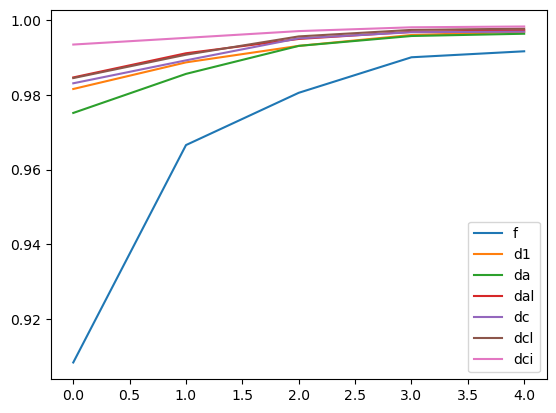

In [115]:
o=0
lim=3
plt.plot(R2.mean(axis=3)[:,lim:,o].detach().numpy().T)
plt.legend(['f','d1','da','dal','dc','dcl','dci'])
for i in range(7):
    plt.fill_between(x, R2.mean(axis=1)[:,0]+MSE.std(axis=1)[:,0], y2=MSE.mean(axis=1)[:,0]-MSE.std(axis=1)[:,0],alpha=0.4)

In [122]:
R2_save = R2.reshape(7,160)

In [124]:
np.savetxt("DiscrepR2TrainNVary.csv", R2_save.detach().numpy(), delimiter=",")

In [8]:
R2_load.shape

(6, 160)

In [2]:
nn=[5,10,15,20,25,30,35,40]

In [3]:
R2_load = pd.read_csv("DiscrepR2TrainNVary.csv",header=None).values.reshape(([7, 8, 2, 10]))

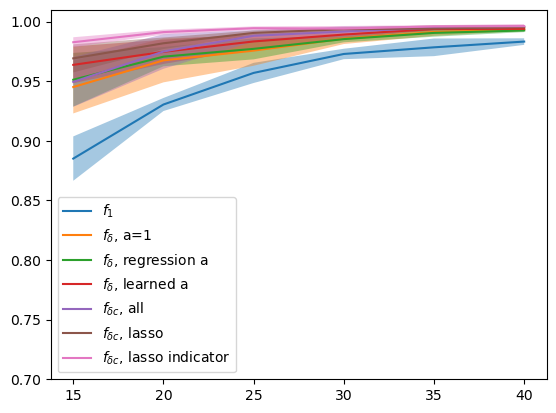

In [9]:
o=1
lim=2
y_lim=[0.7,1.01]
plt.plot(nn[lim:],R2_load.mean(axis=3)[:,lim:,o].T)
plt.ylim(y_lim)
plt.legend(['$f_1$','$f_\delta$, a=1','$f_\delta$, regression a','$f_\delta$, learned a','$f_{\delta c}$, all','$f_{\delta c}$, lasso','$f_{\delta c}$, lasso indicator'])
for i in range(7):
    plt.fill_between(nn[lim:], R2_load.mean(axis=3)[i,lim:,o]+R2_load.std(axis=3)[i,lim:,o], R2_load.mean(axis=3)[i,lim:,o]-R2_load.std(axis=3)[i,lim:,o],alpha=0.4)

In [11]:
results=pd.DataFrame((R2_load[:,7].mean(axis=2)))

results.index=['$f_1$','$f_\delta$, a=1','$f_\delta$, regression a','$f_\delta$, learned a','$f_{\delta c}$, all','$f_{\delta c}$, lasso','$f_{\delta c}$, lasso indicator']

results.columns=['A_TAT','V_TAT']

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

In [ ]:
results=pd.DataFrame((R2_load[:,4].mean(axis=2)))

results.index=['$f_1$','$f_\delta$, a=1','$f_\delta$, regression a','$f_\delta$, learned a','$f_{\delta c}$, all','$f_{\delta c}$, lasso','$f_{\delta c}$, lasso indicator']

results.columns=['A_TAT','V_TAT']

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

In [77]:
results=pd.DataFrame((R2_load.mean(axis=(2))[:,:,0]))

In [78]:
results

0         1         2         3         4         5         6  \
0 -3.567159  0.335050  0.884081  0.916545  0.964088  0.977587  0.984429   
1 -4.611504  0.748728  0.942860  0.980149  0.989254  0.987837  0.995244   
2 -5.911428  0.838283  0.941899  0.972300  0.981450  0.988640  0.994682   
3 -3.882611  0.555884  0.967292  0.978008  0.992448  0.993313  0.995196   
4 -4.955549  0.679943  0.911794  0.972318  0.989958  0.994385  0.995206   
5 -1.100722  0.855964  0.961236  0.987646  0.989269  0.995408  0.996752   
6 -6.414472  0.932374  0.978802  0.991514  0.996962  0.993444  0.996880   

          7  
0  0.986677  
1  0.995875  
2  0.994676  
3  0.996092  
4  0.996707  
5  0.997187  
6  0.998160

In [92]:
emn = [1,3,5,7,9,11,13,15,17]
reps=5
n=40
R2_all=torch.zeros(len(emn),2,reps)
R2_lasso=torch.zeros(len(emn),2,reps)
R2_lasso_i=torch.zeros(len(emn),2,reps)


for k in range(len(emulators)):
    emulators2=emulators.copy()
    emulators2.pop(k)
    print(len(emulators2))
    X_train, X_test, y_train, y_test = train_test_split(
                Xs[k].float(),
                Ys[k].float(),
                test_size=0.1,
                random_state=seed
            )
    for m in range(len(emn)):
        a =np.random.choice(len(emulators2),emn[m],replace=False)
        emulators3 = np.array(emulators2)[a].tolist()
        print(emulators3)
        for i in range(reps):
            
            b=np.random.choice(range(X_train.shape[0]),n,replace=False)

            model_dc_all = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators3)

            R2_all[m,:,i]+=model_dc_all.R2(X_test,y_test)/(len(emulators))





            a_d=torch.zeros((y_train.shape[1],len(emulators3)))
            for j in range(y_train.shape[1]):
                m0=m0_mat(y_train[b],emulators3,X_train[b],j)
                # fit to an order-3 polynomial data
                y_t=(y_train[b,j]-y_train.mean(axis=0)[j])/y_train.std(axis=0)[j]
                model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
                a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)


            model_dc_lasso=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators3,a=a_d)
            end = time.time()
            R2_lasso[m,:,i]+=model_dc_lasso.R2(X_test,y_test)/(len(emulators))




            start = time.time()
            model_dc_lasso_learned=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators3,a=a_d,a_indicator=True)
            end = time.time()
            R2_lasso_i[m,:,i]+=model_dc_lasso_learned.R2(X_test,y_test)/(len(emulators))
            
            print(R2_lasso_i)


17
0
1
0
1
0
1
tensor([[[0.0551, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0553, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.055

1
0
1
0
1
tensor([[[0.0551, 0.0554, 0.0555, 0.0553, 0.0554],
         [0.0553, 0.0554, 0.0555, 0.0553, 0.0554]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0555],
         [0.0555, 0.0553, 0.0555, 0.0554, 0.0555]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.0551, 0.0554, 0.0555, 0.0553, 0.0554],
         [0.0553, 0.0554, 0.0555, 0.0553, 0.0554]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0555],
         [0.0555, 0.0553, 0.0555, 0.0554, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0554],
         [0.0553, 0.0555, 0.0552, 0.0555, 0.0554]],

        [[0.0555, 0.0555, 0.0554, 0.0000, 0.0000],
         [0.0550, 0.0554, 0.0554, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.0551, 0.

1
0
1
0
1
tensor([[[0.0551, 0.0554, 0.0555, 0.0553, 0.0554],
         [0.0553, 0.0554, 0.0555, 0.0553, 0.0554]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0555],
         [0.0555, 0.0553, 0.0555, 0.0554, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0554],
         [0.0553, 0.0555, 0.0552, 0.0555, 0.0554]],

        [[0.0555, 0.0555, 0.0554, 0.0553, 0.0555],
         [0.0550, 0.0554, 0.0554, 0.0555, 0.0554]],

        [[0.0555, 0.0555, 0.0555, 0.0553, 0.0555],
         [0.0553, 0.0555, 0.0555, 0.0554, 0.0555]],

        [[0.0555, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0555, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.0551, 0.

1
0
1
0
1
tensor([[[0.0551, 0.0554, 0.0555, 0.0553, 0.0554],
         [0.0553, 0.0554, 0.0555, 0.0553, 0.0554]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0555],
         [0.0555, 0.0553, 0.0555, 0.0554, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0554],
         [0.0553, 0.0555, 0.0552, 0.0555, 0.0554]],

        [[0.0555, 0.0555, 0.0554, 0.0553, 0.0555],
         [0.0550, 0.0554, 0.0554, 0.0555, 0.0554]],

        [[0.0555, 0.0555, 0.0555, 0.0553, 0.0555],
         [0.0553, 0.0555, 0.0555, 0.0554, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0554],
         [0.0555, 0.0555, 0.0555, 0.0555, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0000],
         [0.0553, 0.0555, 0.0555, 0.0555, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.0551, 0.

1
0
1
0
1
tensor([[[0.0551, 0.0554, 0.0555, 0.0553, 0.0554],
         [0.0553, 0.0554, 0.0555, 0.0553, 0.0554]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0555],
         [0.0555, 0.0553, 0.0555, 0.0554, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0554],
         [0.0553, 0.0555, 0.0552, 0.0555, 0.0554]],

        [[0.0555, 0.0555, 0.0554, 0.0553, 0.0555],
         [0.0550, 0.0554, 0.0554, 0.0555, 0.0554]],

        [[0.0555, 0.0555, 0.0555, 0.0553, 0.0555],
         [0.0553, 0.0555, 0.0555, 0.0554, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0554],
         [0.0555, 0.0555, 0.0555, 0.0555, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0555],
         [0.0553, 0.0555, 0.0555, 0.0555, 0.0555]],

        [[0.0554, 0.0554, 0.0553, 0.0555, 0.0554],
         [0.0554, 0.0555, 0.0553, 0.0555, 0.0555]],

        [[0.0555, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0555, 0.0000, 0.0000, 0.0000, 0.0000]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.0551, 0.

1
0
1
0
1
tensor([[[0.1106, 0.1108, 0.1110, 0.1108, 0.1109],
         [0.1107, 0.1105, 0.1107, 0.1106, 0.1107]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0555],
         [0.0555, 0.0553, 0.0555, 0.0554, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0554],
         [0.0553, 0.0555, 0.0552, 0.0555, 0.0554]],

        [[0.0555, 0.0555, 0.0554, 0.0553, 0.0555],
         [0.0550, 0.0554, 0.0554, 0.0555, 0.0554]],

        [[0.0555, 0.0555, 0.0555, 0.0553, 0.0555],
         [0.0553, 0.0555, 0.0555, 0.0554, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0554],
         [0.0555, 0.0555, 0.0555, 0.0555, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0555],
         [0.0553, 0.0555, 0.0555, 0.0555, 0.0555]],

        [[0.0554, 0.0554, 0.0553, 0.0555, 0.0554],
         [0.0554, 0.0555, 0.0553, 0.0555, 0.0555]],

        [[0.0555, 0.0555, 0.0554, 0.0554, 0.0553],
         [0.0555, 0.0555, 0.0555, 0.0555, 0.0554]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.1106, 0.1108, 0.1110, 0.1108, 0.1109],
         [0.1107, 0.1105, 0.1107, 0.1106, 0.1107]],

        [[0.1110, 0.1110, 0.1109, 0.1109, 0.1110],
         [0.1110, 0.1105, 0.1107, 0.1107, 0.1109]],

        [[0.1110, 0.1110, 0.1109, 0.1110, 0.0554],
         [0.1106, 0.1110, 0.1103, 0.1110, 0.0554]],

        [[0.0555, 0.0555, 0.0554, 0.0553, 0.0555],
         [0.0550, 0.0554, 0.0554, 0.0555, 0.0554]],

        [[0.0555, 0.0555, 0.0555, 0.0553, 0.0555],
         [0.0553, 0.0555, 0.0555, 0.0554, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0554],
         [0.0555, 0.0555, 0.0555, 0.0555, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0555],
         [0.0553, 0.0555, 0.0555, 0.0555, 0.0555]],

        [[0.0554, 0.0554, 0.0553, 0.0555, 0.0554],
         [0.0554, 0.0555, 0.0553, 0.0555, 0.0555]],

        [[0.0555, 0.0555, 0.0554, 0.0554, 0.0553],
         [0.0555, 0.0555, 0.0555, 0.0555, 0.0554]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.1106, 0.

1
0
1
0
1
tensor([[[0.1106, 0.1108, 0.1110, 0.1108, 0.1109],
         [0.1107, 0.1105, 0.1107, 0.1106, 0.1107]],

        [[0.1110, 0.1110, 0.1109, 0.1109, 0.1110],
         [0.1110, 0.1105, 0.1107, 0.1107, 0.1109]],

        [[0.1110, 0.1110, 0.1109, 0.1110, 0.1109],
         [0.1106, 0.1110, 0.1103, 0.1110, 0.1106]],

        [[0.1109, 0.1110, 0.1109, 0.1108, 0.1108],
         [0.1088, 0.1105, 0.1108, 0.1103, 0.1108]],

        [[0.1110, 0.1110, 0.0555, 0.0553, 0.0555],
         [0.1108, 0.1109, 0.0555, 0.0554, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0554],
         [0.0555, 0.0555, 0.0555, 0.0555, 0.0555]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0555],
         [0.0553, 0.0555, 0.0555, 0.0555, 0.0555]],

        [[0.0554, 0.0554, 0.0553, 0.0555, 0.0554],
         [0.0554, 0.0555, 0.0553, 0.0555, 0.0555]],

        [[0.0555, 0.0555, 0.0554, 0.0554, 0.0553],
         [0.0555, 0.0555, 0.0555, 0.0555, 0.0554]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.1106, 0.

1
0
1
0
1
tensor([[[0.1106, 0.1108, 0.1110, 0.1108, 0.1109],
         [0.1107, 0.1105, 0.1107, 0.1106, 0.1107]],

        [[0.1110, 0.1110, 0.1109, 0.1109, 0.1110],
         [0.1110, 0.1105, 0.1107, 0.1107, 0.1109]],

        [[0.1110, 0.1110, 0.1109, 0.1110, 0.1109],
         [0.1106, 0.1110, 0.1103, 0.1110, 0.1106]],

        [[0.1109, 0.1110, 0.1109, 0.1108, 0.1108],
         [0.1088, 0.1105, 0.1108, 0.1103, 0.1108]],

        [[0.1110, 0.1110, 0.1109, 0.1108, 0.1110],
         [0.1108, 0.1109, 0.1109, 0.1108, 0.1107]],

        [[0.1110, 0.1110, 0.1109, 0.1110, 0.1110],
         [0.1108, 0.1110, 0.1109, 0.1109, 0.1108]],

        [[0.0555, 0.0555, 0.0555, 0.0555, 0.0555],
         [0.0553, 0.0555, 0.0555, 0.0555, 0.0555]],

        [[0.0554, 0.0554, 0.0553, 0.0555, 0.0554],
         [0.0554, 0.0555, 0.0553, 0.0555, 0.0555]],

        [[0.0555, 0.0555, 0.0554, 0.0554, 0.0553],
         [0.0555, 0.0555, 0.0555, 0.0555, 0.0554]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.1106, 0.1108, 0.1110, 0.1108, 0.1109],
         [0.1107, 0.1105, 0.1107, 0.1106, 0.1107]],

        [[0.1110, 0.1110, 0.1109, 0.1109, 0.1110],
         [0.1110, 0.1105, 0.1107, 0.1107, 0.1109]],

        [[0.1110, 0.1110, 0.1109, 0.1110, 0.1109],
         [0.1106, 0.1110, 0.1103, 0.1110, 0.1106]],

        [[0.1109, 0.1110, 0.1109, 0.1108, 0.1108],
         [0.1088, 0.1105, 0.1108, 0.1103, 0.1108]],

        [[0.1110, 0.1110, 0.1109, 0.1108, 0.1110],
         [0.1108, 0.1109, 0.1109, 0.1108, 0.1107]],

        [[0.1110, 0.1110, 0.1109, 0.1110, 0.1110],
         [0.1108, 0.1110, 0.1109, 0.1109, 0.1108]],

        [[0.1110, 0.1110, 0.1110, 0.1110, 0.1110],
         [0.1106, 0.1109, 0.1108, 0.1109, 0.1107]],

        [[0.1109, 0.1109, 0.1107, 0.0555, 0.0554],
         [0.1108, 0.1109, 0.1106, 0.0555, 0.0555]],

        [[0.0555, 0.0555, 0.0554, 0.0554, 0.0553],
         [0.0555, 0.0555, 0.0555, 0.0555, 0.0554]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.1106, 0.

1
0
1
0
1
tensor([[[0.1659, 0.1108, 0.1110, 0.1108, 0.1109],
         [0.1661, 0.1105, 0.1107, 0.1106, 0.1107]],

        [[0.1110, 0.1110, 0.1109, 0.1109, 0.1110],
         [0.1110, 0.1105, 0.1107, 0.1107, 0.1109]],

        [[0.1110, 0.1110, 0.1109, 0.1110, 0.1109],
         [0.1106, 0.1110, 0.1103, 0.1110, 0.1106]],

        [[0.1109, 0.1110, 0.1109, 0.1108, 0.1108],
         [0.1088, 0.1105, 0.1108, 0.1103, 0.1108]],

        [[0.1110, 0.1110, 0.1109, 0.1108, 0.1110],
         [0.1108, 0.1109, 0.1109, 0.1108, 0.1107]],

        [[0.1110, 0.1110, 0.1109, 0.1110, 0.1110],
         [0.1108, 0.1110, 0.1109, 0.1109, 0.1108]],

        [[0.1110, 0.1110, 0.1110, 0.1110, 0.1110],
         [0.1106, 0.1109, 0.1108, 0.1109, 0.1107]],

        [[0.1109, 0.1109, 0.1107, 0.1109, 0.1108],
         [0.1108, 0.1109, 0.1106, 0.1097, 0.1109]],

        [[0.1110, 0.1110, 0.1110, 0.1108, 0.1107],
         [0.1110, 0.1109, 0.1107, 0.1110, 0.1108]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.1659, 0.

1
0
1
0
1
tensor([[[0.1659, 0.1660, 0.1664, 0.1662, 0.1664],
         [0.1661, 0.1656, 0.1657, 0.1656, 0.1661]],

        [[0.1664, 0.1664, 0.1664, 0.1663, 0.1664],
         [0.1664, 0.1658, 0.1660, 0.1660, 0.1664]],

        [[0.1110, 0.1110, 0.1109, 0.1110, 0.1109],
         [0.1106, 0.1110, 0.1103, 0.1110, 0.1106]],

        [[0.1109, 0.1110, 0.1109, 0.1108, 0.1108],
         [0.1088, 0.1105, 0.1108, 0.1103, 0.1108]],

        [[0.1110, 0.1110, 0.1109, 0.1108, 0.1110],
         [0.1108, 0.1109, 0.1109, 0.1108, 0.1107]],

        [[0.1110, 0.1110, 0.1109, 0.1110, 0.1110],
         [0.1108, 0.1110, 0.1109, 0.1109, 0.1108]],

        [[0.1110, 0.1110, 0.1110, 0.1110, 0.1110],
         [0.1106, 0.1109, 0.1108, 0.1109, 0.1107]],

        [[0.1109, 0.1109, 0.1107, 0.1109, 0.1108],
         [0.1108, 0.1109, 0.1106, 0.1097, 0.1109]],

        [[0.1110, 0.1110, 0.1110, 0.1108, 0.1107],
         [0.1110, 0.1109, 0.1107, 0.1110, 0.1108]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.1659, 0.1660, 0.1664, 0.1662, 0.1664],
         [0.1661, 0.1656, 0.1657, 0.1656, 0.1661]],

        [[0.1664, 0.1664, 0.1664, 0.1663, 0.1664],
         [0.1664, 0.1658, 0.1660, 0.1660, 0.1664]],

        [[0.1664, 0.1664, 0.1663, 0.1664, 0.1661],
         [0.1660, 0.1663, 0.1656, 0.1659, 0.1661]],

        [[0.1663, 0.1665, 0.1663, 0.1108, 0.1108],
         [0.1643, 0.1660, 0.1663, 0.1103, 0.1108]],

        [[0.1110, 0.1110, 0.1109, 0.1108, 0.1110],
         [0.1108, 0.1109, 0.1109, 0.1108, 0.1107]],

        [[0.1110, 0.1110, 0.1109, 0.1110, 0.1110],
         [0.1108, 0.1110, 0.1109, 0.1109, 0.1108]],

        [[0.1110, 0.1110, 0.1110, 0.1110, 0.1110],
         [0.1106, 0.1109, 0.1108, 0.1109, 0.1107]],

        [[0.1109, 0.1109, 0.1107, 0.1109, 0.1108],
         [0.1108, 0.1109, 0.1106, 0.1097, 0.1109]],

        [[0.1110, 0.1110, 0.1110, 0.1108, 0.1107],
         [0.1110, 0.1109, 0.1107, 0.1110, 0.1108]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.1659, 0.

1
0
1
0
1
tensor([[[0.1659, 0.1660, 0.1664, 0.1662, 0.1664],
         [0.1661, 0.1656, 0.1657, 0.1656, 0.1661]],

        [[0.1664, 0.1664, 0.1664, 0.1663, 0.1664],
         [0.1664, 0.1658, 0.1660, 0.1660, 0.1664]],

        [[0.1664, 0.1664, 0.1663, 0.1664, 0.1661],
         [0.1660, 0.1663, 0.1656, 0.1659, 0.1661]],

        [[0.1663, 0.1665, 0.1663, 0.1663, 0.1663],
         [0.1643, 0.1660, 0.1663, 0.1654, 0.1662]],

        [[0.1664, 0.1665, 0.1664, 0.1663, 0.1665],
         [0.1662, 0.1663, 0.1663, 0.1663, 0.1662]],

        [[0.1662, 0.1110, 0.1109, 0.1110, 0.1110],
         [0.1661, 0.1110, 0.1109, 0.1109, 0.1108]],

        [[0.1110, 0.1110, 0.1110, 0.1110, 0.1110],
         [0.1106, 0.1109, 0.1108, 0.1109, 0.1107]],

        [[0.1109, 0.1109, 0.1107, 0.1109, 0.1108],
         [0.1108, 0.1109, 0.1106, 0.1097, 0.1109]],

        [[0.1110, 0.1110, 0.1110, 0.1108, 0.1107],
         [0.1110, 0.1109, 0.1107, 0.1110, 0.1108]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.1659, 0.

1
0
1
0
1
tensor([[[0.1659, 0.1660, 0.1664, 0.1662, 0.1664],
         [0.1661, 0.1656, 0.1657, 0.1656, 0.1661]],

        [[0.1664, 0.1664, 0.1664, 0.1663, 0.1664],
         [0.1664, 0.1658, 0.1660, 0.1660, 0.1664]],

        [[0.1664, 0.1664, 0.1663, 0.1664, 0.1661],
         [0.1660, 0.1663, 0.1656, 0.1659, 0.1661]],

        [[0.1663, 0.1665, 0.1663, 0.1663, 0.1663],
         [0.1643, 0.1660, 0.1663, 0.1654, 0.1662]],

        [[0.1664, 0.1665, 0.1664, 0.1663, 0.1665],
         [0.1662, 0.1663, 0.1663, 0.1663, 0.1662]],

        [[0.1662, 0.1663, 0.1664, 0.1665, 0.1662],
         [0.1661, 0.1661, 0.1664, 0.1663, 0.1661]],

        [[0.1665, 0.1664, 0.1663, 0.1666, 0.1110],
         [0.1660, 0.1664, 0.1662, 0.1664, 0.1107]],

        [[0.1109, 0.1109, 0.1107, 0.1109, 0.1108],
         [0.1108, 0.1109, 0.1106, 0.1097, 0.1109]],

        [[0.1110, 0.1110, 0.1110, 0.1108, 0.1107],
         [0.1110, 0.1109, 0.1107, 0.1110, 0.1108]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.1659, 0.

1
0
1
0
1
tensor([[[0.1659, 0.1660, 0.1664, 0.1662, 0.1664],
         [0.1661, 0.1656, 0.1657, 0.1656, 0.1661]],

        [[0.1664, 0.1664, 0.1664, 0.1663, 0.1664],
         [0.1664, 0.1658, 0.1660, 0.1660, 0.1664]],

        [[0.1664, 0.1664, 0.1663, 0.1664, 0.1661],
         [0.1660, 0.1663, 0.1656, 0.1659, 0.1661]],

        [[0.1663, 0.1665, 0.1663, 0.1663, 0.1663],
         [0.1643, 0.1660, 0.1663, 0.1654, 0.1662]],

        [[0.1664, 0.1665, 0.1664, 0.1663, 0.1665],
         [0.1662, 0.1663, 0.1663, 0.1663, 0.1662]],

        [[0.1662, 0.1663, 0.1664, 0.1665, 0.1662],
         [0.1661, 0.1661, 0.1664, 0.1663, 0.1661]],

        [[0.1665, 0.1664, 0.1663, 0.1666, 0.1663],
         [0.1660, 0.1664, 0.1662, 0.1664, 0.1662]],

        [[0.1662, 0.1664, 0.1662, 0.1664, 0.1663],
         [0.1663, 0.1659, 0.1661, 0.1650, 0.1663]],

        [[0.1665, 0.1110, 0.1110, 0.1108, 0.1107],
         [0.1665, 0.1109, 0.1107, 0.1110, 0.1108]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.1659, 0.

1
0
1
0
1
tensor([[[0.2214, 0.2215, 0.2218, 0.2217, 0.2219],
         [0.2210, 0.2207, 0.2201, 0.2210, 0.2209]],

        [[0.1664, 0.1664, 0.1664, 0.1663, 0.1664],
         [0.1664, 0.1658, 0.1660, 0.1660, 0.1664]],

        [[0.1664, 0.1664, 0.1663, 0.1664, 0.1661],
         [0.1660, 0.1663, 0.1656, 0.1659, 0.1661]],

        [[0.1663, 0.1665, 0.1663, 0.1663, 0.1663],
         [0.1643, 0.1660, 0.1663, 0.1654, 0.1662]],

        [[0.1664, 0.1665, 0.1664, 0.1663, 0.1665],
         [0.1662, 0.1663, 0.1663, 0.1663, 0.1662]],

        [[0.1662, 0.1663, 0.1664, 0.1665, 0.1662],
         [0.1661, 0.1661, 0.1664, 0.1663, 0.1661]],

        [[0.1665, 0.1664, 0.1663, 0.1666, 0.1663],
         [0.1660, 0.1664, 0.1662, 0.1664, 0.1662]],

        [[0.1662, 0.1664, 0.1662, 0.1664, 0.1663],
         [0.1663, 0.1659, 0.1661, 0.1650, 0.1663]],

        [[0.1665, 0.1664, 0.1664, 0.1663, 0.1661],
         [0.1665, 0.1662, 0.1660, 0.1663, 0.1663]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.2214, 0.2215, 0.2218, 0.2217, 0.2219],
         [0.2210, 0.2207, 0.2201, 0.2210, 0.2209]],

        [[0.2219, 0.2220, 0.2219, 0.2218, 0.2220],
         [0.2217, 0.2212, 0.2214, 0.2214, 0.2218]],

        [[0.2219, 0.2219, 0.2219, 0.2219, 0.1661],
         [0.2213, 0.2217, 0.2209, 0.2213, 0.1661]],

        [[0.1663, 0.1665, 0.1663, 0.1663, 0.1663],
         [0.1643, 0.1660, 0.1663, 0.1654, 0.1662]],

        [[0.1664, 0.1665, 0.1664, 0.1663, 0.1665],
         [0.1662, 0.1663, 0.1663, 0.1663, 0.1662]],

        [[0.1662, 0.1663, 0.1664, 0.1665, 0.1662],
         [0.1661, 0.1661, 0.1664, 0.1663, 0.1661]],

        [[0.1665, 0.1664, 0.1663, 0.1666, 0.1663],
         [0.1660, 0.1664, 0.1662, 0.1664, 0.1662]],

        [[0.1662, 0.1664, 0.1662, 0.1664, 0.1663],
         [0.1663, 0.1659, 0.1661, 0.1650, 0.1663]],

        [[0.1665, 0.1664, 0.1664, 0.1663, 0.1661],
         [0.1665, 0.1662, 0.1660, 0.1663, 0.1663]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.2214, 0.

1
0
1
0
1
tensor([[[0.2214, 0.2215, 0.2218, 0.2217, 0.2219],
         [0.2210, 0.2207, 0.2201, 0.2210, 0.2209]],

        [[0.2219, 0.2220, 0.2219, 0.2218, 0.2220],
         [0.2217, 0.2212, 0.2214, 0.2214, 0.2218]],

        [[0.2219, 0.2219, 0.2219, 0.2219, 0.2217],
         [0.2213, 0.2217, 0.2209, 0.2213, 0.2216]],

        [[0.2218, 0.2219, 0.2218, 0.2217, 0.2217],
         [0.2196, 0.2213, 0.2212, 0.2208, 0.2217]],

        [[0.2219, 0.2219, 0.1664, 0.1663, 0.1665],
         [0.2216, 0.2216, 0.1663, 0.1663, 0.1662]],

        [[0.1662, 0.1663, 0.1664, 0.1665, 0.1662],
         [0.1661, 0.1661, 0.1664, 0.1663, 0.1661]],

        [[0.1665, 0.1664, 0.1663, 0.1666, 0.1663],
         [0.1660, 0.1664, 0.1662, 0.1664, 0.1662]],

        [[0.1662, 0.1664, 0.1662, 0.1664, 0.1663],
         [0.1663, 0.1659, 0.1661, 0.1650, 0.1663]],

        [[0.1665, 0.1664, 0.1664, 0.1663, 0.1661],
         [0.1665, 0.1662, 0.1660, 0.1663, 0.1663]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.2214, 0.

1
0
1
0
1
tensor([[[0.2214, 0.2215, 0.2218, 0.2217, 0.2219],
         [0.2210, 0.2207, 0.2201, 0.2210, 0.2209]],

        [[0.2219, 0.2220, 0.2219, 0.2218, 0.2220],
         [0.2217, 0.2212, 0.2214, 0.2214, 0.2218]],

        [[0.2219, 0.2219, 0.2219, 0.2219, 0.2217],
         [0.2213, 0.2217, 0.2209, 0.2213, 0.2216]],

        [[0.2218, 0.2219, 0.2218, 0.2217, 0.2217],
         [0.2196, 0.2213, 0.2212, 0.2208, 0.2217]],

        [[0.2219, 0.2219, 0.2218, 0.2219, 0.2220],
         [0.2216, 0.2216, 0.2218, 0.2217, 0.2214]],

        [[0.2217, 0.2218, 0.2219, 0.2220, 0.2217],
         [0.2215, 0.2216, 0.2218, 0.2216, 0.2215]],

        [[0.1665, 0.1664, 0.1663, 0.1666, 0.1663],
         [0.1660, 0.1664, 0.1662, 0.1664, 0.1662]],

        [[0.1662, 0.1664, 0.1662, 0.1664, 0.1663],
         [0.1663, 0.1659, 0.1661, 0.1650, 0.1663]],

        [[0.1665, 0.1664, 0.1664, 0.1663, 0.1661],
         [0.1665, 0.1662, 0.1660, 0.1663, 0.1663]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.2214, 0.2215, 0.2218, 0.2217, 0.2219],
         [0.2210, 0.2207, 0.2201, 0.2210, 0.2209]],

        [[0.2219, 0.2220, 0.2219, 0.2218, 0.2220],
         [0.2217, 0.2212, 0.2214, 0.2214, 0.2218]],

        [[0.2219, 0.2219, 0.2219, 0.2219, 0.2217],
         [0.2213, 0.2217, 0.2209, 0.2213, 0.2216]],

        [[0.2218, 0.2219, 0.2218, 0.2217, 0.2217],
         [0.2196, 0.2213, 0.2212, 0.2208, 0.2217]],

        [[0.2219, 0.2219, 0.2218, 0.2219, 0.2220],
         [0.2216, 0.2216, 0.2218, 0.2217, 0.2214]],

        [[0.2217, 0.2218, 0.2219, 0.2220, 0.2217],
         [0.2215, 0.2216, 0.2218, 0.2216, 0.2215]],

        [[0.2220, 0.2219, 0.2219, 0.2220, 0.2217],
         [0.2215, 0.2218, 0.2215, 0.2217, 0.2212]],

        [[0.2217, 0.2216, 0.2218, 0.1664, 0.1663],
         [0.2217, 0.2214, 0.2215, 0.1650, 0.1663]],

        [[0.1665, 0.1664, 0.1664, 0.1663, 0.1661],
         [0.1665, 0.1662, 0.1660, 0.1663, 0.1663]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.2214, 0.

1
0
1
0
1
tensor([[[0.2769, 0.2215, 0.2218, 0.2217, 0.2219],
         [0.2763, 0.2207, 0.2201, 0.2210, 0.2209]],

        [[0.2219, 0.2220, 0.2219, 0.2218, 0.2220],
         [0.2217, 0.2212, 0.2214, 0.2214, 0.2218]],

        [[0.2219, 0.2219, 0.2219, 0.2219, 0.2217],
         [0.2213, 0.2217, 0.2209, 0.2213, 0.2216]],

        [[0.2218, 0.2219, 0.2218, 0.2217, 0.2217],
         [0.2196, 0.2213, 0.2212, 0.2208, 0.2217]],

        [[0.2219, 0.2219, 0.2218, 0.2219, 0.2220],
         [0.2216, 0.2216, 0.2218, 0.2217, 0.2214]],

        [[0.2217, 0.2218, 0.2219, 0.2220, 0.2217],
         [0.2215, 0.2216, 0.2218, 0.2216, 0.2215]],

        [[0.2220, 0.2219, 0.2219, 0.2220, 0.2217],
         [0.2215, 0.2218, 0.2215, 0.2217, 0.2212]],

        [[0.2217, 0.2216, 0.2218, 0.2217, 0.2218],
         [0.2217, 0.2214, 0.2215, 0.2205, 0.2218]],

        [[0.2220, 0.2219, 0.2219, 0.2218, 0.2216],
         [0.2218, 0.2216, 0.2214, 0.2217, 0.2217]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.2769, 0.

1
0
1
0
1
tensor([[[0.2769, 0.2770, 0.2773, 0.2772, 0.2774],
         [0.2763, 0.2762, 0.2755, 0.2762, 0.2764]],

        [[0.2774, 0.2774, 0.2774, 0.2772, 0.2774],
         [0.2771, 0.2767, 0.2767, 0.2769, 0.2772]],

        [[0.2219, 0.2219, 0.2219, 0.2219, 0.2217],
         [0.2213, 0.2217, 0.2209, 0.2213, 0.2216]],

        [[0.2218, 0.2219, 0.2218, 0.2217, 0.2217],
         [0.2196, 0.2213, 0.2212, 0.2208, 0.2217]],

        [[0.2219, 0.2219, 0.2218, 0.2219, 0.2220],
         [0.2216, 0.2216, 0.2218, 0.2217, 0.2214]],

        [[0.2217, 0.2218, 0.2219, 0.2220, 0.2217],
         [0.2215, 0.2216, 0.2218, 0.2216, 0.2215]],

        [[0.2220, 0.2219, 0.2219, 0.2220, 0.2217],
         [0.2215, 0.2218, 0.2215, 0.2217, 0.2212]],

        [[0.2217, 0.2216, 0.2218, 0.2217, 0.2218],
         [0.2217, 0.2214, 0.2215, 0.2205, 0.2218]],

        [[0.2220, 0.2219, 0.2219, 0.2218, 0.2216],
         [0.2218, 0.2216, 0.2214, 0.2217, 0.2217]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.2769, 0.2770, 0.2773, 0.2772, 0.2774],
         [0.2763, 0.2762, 0.2755, 0.2762, 0.2764]],

        [[0.2774, 0.2774, 0.2774, 0.2772, 0.2774],
         [0.2771, 0.2767, 0.2767, 0.2769, 0.2772]],

        [[0.2774, 0.2772, 0.2773, 0.2774, 0.2771],
         [0.2768, 0.2771, 0.2761, 0.2768, 0.2771]],

        [[0.2773, 0.2774, 0.2773, 0.2217, 0.2217],
         [0.2750, 0.2767, 0.2767, 0.2208, 0.2217]],

        [[0.2219, 0.2219, 0.2218, 0.2219, 0.2220],
         [0.2216, 0.2216, 0.2218, 0.2217, 0.2214]],

        [[0.2217, 0.2218, 0.2219, 0.2220, 0.2217],
         [0.2215, 0.2216, 0.2218, 0.2216, 0.2215]],

        [[0.2220, 0.2219, 0.2219, 0.2220, 0.2217],
         [0.2215, 0.2218, 0.2215, 0.2217, 0.2212]],

        [[0.2217, 0.2216, 0.2218, 0.2217, 0.2218],
         [0.2217, 0.2214, 0.2215, 0.2205, 0.2218]],

        [[0.2220, 0.2219, 0.2219, 0.2218, 0.2216],
         [0.2218, 0.2216, 0.2214, 0.2217, 0.2217]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.2769, 0.

1
0
1
0
1
tensor([[[0.2769, 0.2770, 0.2773, 0.2772, 0.2774],
         [0.2763, 0.2762, 0.2755, 0.2762, 0.2764]],

        [[0.2774, 0.2774, 0.2774, 0.2772, 0.2774],
         [0.2771, 0.2767, 0.2767, 0.2769, 0.2772]],

        [[0.2774, 0.2772, 0.2773, 0.2774, 0.2771],
         [0.2768, 0.2771, 0.2761, 0.2768, 0.2771]],

        [[0.2773, 0.2774, 0.2773, 0.2772, 0.2772],
         [0.2750, 0.2767, 0.2767, 0.2762, 0.2772]],

        [[0.2774, 0.2774, 0.2773, 0.2773, 0.2775],
         [0.2771, 0.2771, 0.2774, 0.2772, 0.2770]],

        [[0.2772, 0.2218, 0.2219, 0.2220, 0.2217],
         [0.2770, 0.2216, 0.2218, 0.2216, 0.2215]],

        [[0.2220, 0.2219, 0.2219, 0.2220, 0.2217],
         [0.2215, 0.2218, 0.2215, 0.2217, 0.2212]],

        [[0.2217, 0.2216, 0.2218, 0.2217, 0.2218],
         [0.2217, 0.2214, 0.2215, 0.2205, 0.2218]],

        [[0.2220, 0.2219, 0.2219, 0.2218, 0.2216],
         [0.2218, 0.2216, 0.2214, 0.2217, 0.2217]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.2769, 0.

1
0
1
0
1
tensor([[[0.2769, 0.2770, 0.2773, 0.2772, 0.2774],
         [0.2763, 0.2762, 0.2755, 0.2762, 0.2764]],

        [[0.2774, 0.2774, 0.2774, 0.2772, 0.2774],
         [0.2771, 0.2767, 0.2767, 0.2769, 0.2772]],

        [[0.2774, 0.2772, 0.2773, 0.2774, 0.2771],
         [0.2768, 0.2771, 0.2761, 0.2768, 0.2771]],

        [[0.2773, 0.2774, 0.2773, 0.2772, 0.2772],
         [0.2750, 0.2767, 0.2767, 0.2762, 0.2772]],

        [[0.2774, 0.2774, 0.2773, 0.2773, 0.2775],
         [0.2771, 0.2771, 0.2774, 0.2772, 0.2770]],

        [[0.2772, 0.2774, 0.2774, 0.2774, 0.2773],
         [0.2770, 0.2771, 0.2773, 0.2771, 0.2770]],

        [[0.2770, 0.2773, 0.2774, 0.2775, 0.2217],
         [0.2770, 0.2773, 0.2771, 0.2773, 0.2212]],

        [[0.2217, 0.2216, 0.2218, 0.2217, 0.2218],
         [0.2217, 0.2214, 0.2215, 0.2205, 0.2218]],

        [[0.2220, 0.2219, 0.2219, 0.2218, 0.2216],
         [0.2218, 0.2216, 0.2214, 0.2217, 0.2217]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.2769, 0.

1
0
1
0
1
tensor([[[0.2769, 0.2770, 0.2773, 0.2772, 0.2774],
         [0.2763, 0.2762, 0.2755, 0.2762, 0.2764]],

        [[0.2774, 0.2774, 0.2774, 0.2772, 0.2774],
         [0.2771, 0.2767, 0.2767, 0.2769, 0.2772]],

        [[0.2774, 0.2772, 0.2773, 0.2774, 0.2771],
         [0.2768, 0.2771, 0.2761, 0.2768, 0.2771]],

        [[0.2773, 0.2774, 0.2773, 0.2772, 0.2772],
         [0.2750, 0.2767, 0.2767, 0.2762, 0.2772]],

        [[0.2774, 0.2774, 0.2773, 0.2773, 0.2775],
         [0.2771, 0.2771, 0.2774, 0.2772, 0.2770]],

        [[0.2772, 0.2774, 0.2774, 0.2774, 0.2773],
         [0.2770, 0.2771, 0.2773, 0.2771, 0.2770]],

        [[0.2770, 0.2773, 0.2774, 0.2775, 0.2772],
         [0.2770, 0.2773, 0.2771, 0.2773, 0.2767]],

        [[0.2772, 0.2771, 0.2773, 0.2771, 0.2773],
         [0.2772, 0.2769, 0.2771, 0.2760, 0.2772]],

        [[0.2776, 0.2219, 0.2219, 0.2218, 0.2216],
         [0.2773, 0.2216, 0.2214, 0.2217, 0.2217]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.2769, 0.

1
0
1
0
1
tensor([[[0.3322, 0.3324, 0.3324, 0.3326, 0.3328],
         [0.3315, 0.3315, 0.3310, 0.3317, 0.3317]],

        [[0.2774, 0.2774, 0.2774, 0.2772, 0.2774],
         [0.2771, 0.2767, 0.2767, 0.2769, 0.2772]],

        [[0.2774, 0.2772, 0.2773, 0.2774, 0.2771],
         [0.2768, 0.2771, 0.2761, 0.2768, 0.2771]],

        [[0.2773, 0.2774, 0.2773, 0.2772, 0.2772],
         [0.2750, 0.2767, 0.2767, 0.2762, 0.2772]],

        [[0.2774, 0.2774, 0.2773, 0.2773, 0.2775],
         [0.2771, 0.2771, 0.2774, 0.2772, 0.2770]],

        [[0.2772, 0.2774, 0.2774, 0.2774, 0.2773],
         [0.2770, 0.2771, 0.2773, 0.2771, 0.2770]],

        [[0.2770, 0.2773, 0.2774, 0.2775, 0.2772],
         [0.2770, 0.2773, 0.2771, 0.2773, 0.2767]],

        [[0.2772, 0.2771, 0.2773, 0.2771, 0.2773],
         [0.2772, 0.2769, 0.2771, 0.2760, 0.2772]],

        [[0.2776, 0.2774, 0.2774, 0.2773, 0.2771],
         [0.2773, 0.2770, 0.2764, 0.2772, 0.2773]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.3322, 0.3324, 0.3324, 0.3326, 0.3328],
         [0.3315, 0.3315, 0.3310, 0.3317, 0.3317]],

        [[0.3329, 0.3329, 0.3328, 0.3327, 0.3329],
         [0.3325, 0.3320, 0.3322, 0.3322, 0.3327]],

        [[0.3328, 0.3327, 0.3328, 0.3328, 0.2771],
         [0.3323, 0.3320, 0.3316, 0.3322, 0.2771]],

        [[0.2773, 0.2774, 0.2773, 0.2772, 0.2772],
         [0.2750, 0.2767, 0.2767, 0.2762, 0.2772]],

        [[0.2774, 0.2774, 0.2773, 0.2773, 0.2775],
         [0.2771, 0.2771, 0.2774, 0.2772, 0.2770]],

        [[0.2772, 0.2774, 0.2774, 0.2774, 0.2773],
         [0.2770, 0.2771, 0.2773, 0.2771, 0.2770]],

        [[0.2770, 0.2773, 0.2774, 0.2775, 0.2772],
         [0.2770, 0.2773, 0.2771, 0.2773, 0.2767]],

        [[0.2772, 0.2771, 0.2773, 0.2771, 0.2773],
         [0.2772, 0.2769, 0.2771, 0.2760, 0.2772]],

        [[0.2776, 0.2774, 0.2774, 0.2773, 0.2771],
         [0.2773, 0.2770, 0.2764, 0.2772, 0.2773]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.3322, 0.

1
0
1
0
1
tensor([[[0.3322, 0.3324, 0.3324, 0.3326, 0.3328],
         [0.3315, 0.3315, 0.3310, 0.3317, 0.3317]],

        [[0.3329, 0.3329, 0.3328, 0.3327, 0.3329],
         [0.3325, 0.3320, 0.3322, 0.3322, 0.3327]],

        [[0.3328, 0.3327, 0.3328, 0.3328, 0.3326],
         [0.3323, 0.3320, 0.3316, 0.3322, 0.3326]],

        [[0.3324, 0.3328, 0.3328, 0.3326, 0.3327],
         [0.3304, 0.3320, 0.3321, 0.3317, 0.3327]],

        [[0.3327, 0.3329, 0.2773, 0.2773, 0.2775],
         [0.3325, 0.3324, 0.2774, 0.2772, 0.2770]],

        [[0.2772, 0.2774, 0.2774, 0.2774, 0.2773],
         [0.2770, 0.2771, 0.2773, 0.2771, 0.2770]],

        [[0.2770, 0.2773, 0.2774, 0.2775, 0.2772],
         [0.2770, 0.2773, 0.2771, 0.2773, 0.2767]],

        [[0.2772, 0.2771, 0.2773, 0.2771, 0.2773],
         [0.2772, 0.2769, 0.2771, 0.2760, 0.2772]],

        [[0.2776, 0.2774, 0.2774, 0.2773, 0.2771],
         [0.2773, 0.2770, 0.2764, 0.2772, 0.2773]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.3322, 0.

1
0
1
0
1
tensor([[[0.3322, 0.3324, 0.3324, 0.3326, 0.3328],
         [0.3315, 0.3315, 0.3310, 0.3317, 0.3317]],

        [[0.3329, 0.3329, 0.3328, 0.3327, 0.3329],
         [0.3325, 0.3320, 0.3322, 0.3322, 0.3327]],

        [[0.3328, 0.3327, 0.3328, 0.3328, 0.3326],
         [0.3323, 0.3320, 0.3316, 0.3322, 0.3326]],

        [[0.3324, 0.3328, 0.3328, 0.3326, 0.3327],
         [0.3304, 0.3320, 0.3321, 0.3317, 0.3327]],

        [[0.3327, 0.3329, 0.3328, 0.3328, 0.3329],
         [0.3325, 0.3324, 0.3329, 0.3327, 0.3324]],

        [[0.3326, 0.3328, 0.3328, 0.3328, 0.3327],
         [0.3323, 0.3323, 0.3327, 0.3326, 0.3323]],

        [[0.2770, 0.2773, 0.2774, 0.2775, 0.2772],
         [0.2770, 0.2773, 0.2771, 0.2773, 0.2767]],

        [[0.2772, 0.2771, 0.2773, 0.2771, 0.2773],
         [0.2772, 0.2769, 0.2771, 0.2760, 0.2772]],

        [[0.2776, 0.2774, 0.2774, 0.2773, 0.2771],
         [0.2773, 0.2770, 0.2764, 0.2772, 0.2773]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.3322, 0.3324, 0.3324, 0.3326, 0.3328],
         [0.3315, 0.3315, 0.3310, 0.3317, 0.3317]],

        [[0.3329, 0.3329, 0.3328, 0.3327, 0.3329],
         [0.3325, 0.3320, 0.3322, 0.3322, 0.3327]],

        [[0.3328, 0.3327, 0.3328, 0.3328, 0.3326],
         [0.3323, 0.3320, 0.3316, 0.3322, 0.3326]],

        [[0.3324, 0.3328, 0.3328, 0.3326, 0.3327],
         [0.3304, 0.3320, 0.3321, 0.3317, 0.3327]],

        [[0.3327, 0.3329, 0.3328, 0.3328, 0.3329],
         [0.3325, 0.3324, 0.3329, 0.3327, 0.3324]],

        [[0.3326, 0.3328, 0.3328, 0.3328, 0.3327],
         [0.3323, 0.3323, 0.3327, 0.3326, 0.3323]],

        [[0.3325, 0.3328, 0.3329, 0.3330, 0.3327],
         [0.3323, 0.3328, 0.3323, 0.3327, 0.3321]],

        [[0.3327, 0.3326, 0.3328, 0.2771, 0.2773],
         [0.3326, 0.3323, 0.3324, 0.2760, 0.2772]],

        [[0.2776, 0.2774, 0.2774, 0.2773, 0.2771],
         [0.2773, 0.2770, 0.2764, 0.2772, 0.2773]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.3322, 0.

1
0
1
0
1
tensor([[[0.3877, 0.3324, 0.3324, 0.3326, 0.3328],
         [0.3870, 0.3315, 0.3310, 0.3317, 0.3317]],

        [[0.3329, 0.3329, 0.3328, 0.3327, 0.3329],
         [0.3325, 0.3320, 0.3322, 0.3322, 0.3327]],

        [[0.3328, 0.3327, 0.3328, 0.3328, 0.3326],
         [0.3323, 0.3320, 0.3316, 0.3322, 0.3326]],

        [[0.3324, 0.3328, 0.3328, 0.3326, 0.3327],
         [0.3304, 0.3320, 0.3321, 0.3317, 0.3327]],

        [[0.3327, 0.3329, 0.3328, 0.3328, 0.3329],
         [0.3325, 0.3324, 0.3329, 0.3327, 0.3324]],

        [[0.3326, 0.3328, 0.3328, 0.3328, 0.3327],
         [0.3323, 0.3323, 0.3327, 0.3326, 0.3323]],

        [[0.3325, 0.3328, 0.3329, 0.3330, 0.3327],
         [0.3323, 0.3328, 0.3323, 0.3327, 0.3321]],

        [[0.3327, 0.3326, 0.3328, 0.3326, 0.3328],
         [0.3326, 0.3323, 0.3324, 0.3314, 0.3326]],

        [[0.3330, 0.3329, 0.3329, 0.3328, 0.3326],
         [0.3328, 0.3324, 0.3318, 0.3327, 0.3327]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.3877, 0.

1
0
1
0
1
tensor([[[0.3877, 0.3879, 0.3875, 0.3881, 0.3883],
         [0.3870, 0.3869, 0.3862, 0.3869, 0.3869]],

        [[0.3884, 0.3883, 0.3883, 0.3882, 0.3884],
         [0.3875, 0.3875, 0.3873, 0.3877, 0.3880]],

        [[0.3328, 0.3327, 0.3328, 0.3328, 0.3326],
         [0.3323, 0.3320, 0.3316, 0.3322, 0.3326]],

        [[0.3324, 0.3328, 0.3328, 0.3326, 0.3327],
         [0.3304, 0.3320, 0.3321, 0.3317, 0.3327]],

        [[0.3327, 0.3329, 0.3328, 0.3328, 0.3329],
         [0.3325, 0.3324, 0.3329, 0.3327, 0.3324]],

        [[0.3326, 0.3328, 0.3328, 0.3328, 0.3327],
         [0.3323, 0.3323, 0.3327, 0.3326, 0.3323]],

        [[0.3325, 0.3328, 0.3329, 0.3330, 0.3327],
         [0.3323, 0.3328, 0.3323, 0.3327, 0.3321]],

        [[0.3327, 0.3326, 0.3328, 0.3326, 0.3328],
         [0.3326, 0.3323, 0.3324, 0.3314, 0.3326]],

        [[0.3330, 0.3329, 0.3329, 0.3328, 0.3326],
         [0.3328, 0.3324, 0.3318, 0.3327, 0.3327]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.3877, 0.3879, 0.3875, 0.3881, 0.3883],
         [0.3870, 0.3869, 0.3862, 0.3869, 0.3869]],

        [[0.3884, 0.3883, 0.3883, 0.3882, 0.3884],
         [0.3875, 0.3875, 0.3873, 0.3877, 0.3880]],

        [[0.3883, 0.3882, 0.3883, 0.3882, 0.3881],
         [0.3878, 0.3875, 0.3862, 0.3877, 0.3881]],

        [[0.3879, 0.3883, 0.3883, 0.3326, 0.3327],
         [0.3859, 0.3875, 0.3874, 0.3317, 0.3327]],

        [[0.3327, 0.3329, 0.3328, 0.3328, 0.3329],
         [0.3325, 0.3324, 0.3329, 0.3327, 0.3324]],

        [[0.3326, 0.3328, 0.3328, 0.3328, 0.3327],
         [0.3323, 0.3323, 0.3327, 0.3326, 0.3323]],

        [[0.3325, 0.3328, 0.3329, 0.3330, 0.3327],
         [0.3323, 0.3328, 0.3323, 0.3327, 0.3321]],

        [[0.3327, 0.3326, 0.3328, 0.3326, 0.3328],
         [0.3326, 0.3323, 0.3324, 0.3314, 0.3326]],

        [[0.3330, 0.3329, 0.3329, 0.3328, 0.3326],
         [0.3328, 0.3324, 0.3318, 0.3327, 0.3327]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.3877, 0.

1
0
1
0
1
tensor([[[0.3877, 0.3879, 0.3875, 0.3881, 0.3883],
         [0.3870, 0.3869, 0.3862, 0.3869, 0.3869]],

        [[0.3884, 0.3883, 0.3883, 0.3882, 0.3884],
         [0.3875, 0.3875, 0.3873, 0.3877, 0.3880]],

        [[0.3883, 0.3882, 0.3883, 0.3882, 0.3881],
         [0.3878, 0.3875, 0.3862, 0.3877, 0.3881]],

        [[0.3879, 0.3883, 0.3883, 0.3881, 0.3882],
         [0.3859, 0.3875, 0.3874, 0.3872, 0.3881]],

        [[0.3883, 0.3882, 0.3884, 0.3882, 0.3884],
         [0.3873, 0.3879, 0.3883, 0.3880, 0.3878]],

        [[0.3881, 0.3328, 0.3328, 0.3328, 0.3327],
         [0.3874, 0.3323, 0.3327, 0.3326, 0.3323]],

        [[0.3325, 0.3328, 0.3329, 0.3330, 0.3327],
         [0.3323, 0.3328, 0.3323, 0.3327, 0.3321]],

        [[0.3327, 0.3326, 0.3328, 0.3326, 0.3328],
         [0.3326, 0.3323, 0.3324, 0.3314, 0.3326]],

        [[0.3330, 0.3329, 0.3329, 0.3328, 0.3326],
         [0.3328, 0.3324, 0.3318, 0.3327, 0.3327]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.3877, 0.

1
0
1
0
1
tensor([[[0.3877, 0.3879, 0.3875, 0.3881, 0.3883],
         [0.3870, 0.3869, 0.3862, 0.3869, 0.3869]],

        [[0.3884, 0.3883, 0.3883, 0.3882, 0.3884],
         [0.3875, 0.3875, 0.3873, 0.3877, 0.3880]],

        [[0.3883, 0.3882, 0.3883, 0.3882, 0.3881],
         [0.3878, 0.3875, 0.3862, 0.3877, 0.3881]],

        [[0.3879, 0.3883, 0.3883, 0.3881, 0.3882],
         [0.3859, 0.3875, 0.3874, 0.3872, 0.3881]],

        [[0.3883, 0.3882, 0.3884, 0.3882, 0.3884],
         [0.3873, 0.3879, 0.3883, 0.3880, 0.3878]],

        [[0.3881, 0.3883, 0.3883, 0.3884, 0.3881],
         [0.3874, 0.3878, 0.3881, 0.3879, 0.3878]],

        [[0.3880, 0.3883, 0.3883, 0.3885, 0.3327],
         [0.3877, 0.3883, 0.3875, 0.3881, 0.3321]],

        [[0.3327, 0.3326, 0.3328, 0.3326, 0.3328],
         [0.3326, 0.3323, 0.3324, 0.3314, 0.3326]],

        [[0.3330, 0.3329, 0.3329, 0.3328, 0.3326],
         [0.3328, 0.3324, 0.3318, 0.3327, 0.3327]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.3877, 0.

1
0
1
0
1
tensor([[[0.3877, 0.3879, 0.3875, 0.3881, 0.3883],
         [0.3870, 0.3869, 0.3862, 0.3869, 0.3869]],

        [[0.3884, 0.3883, 0.3883, 0.3882, 0.3884],
         [0.3875, 0.3875, 0.3873, 0.3877, 0.3880]],

        [[0.3883, 0.3882, 0.3883, 0.3882, 0.3881],
         [0.3878, 0.3875, 0.3862, 0.3877, 0.3881]],

        [[0.3879, 0.3883, 0.3883, 0.3881, 0.3882],
         [0.3859, 0.3875, 0.3874, 0.3872, 0.3881]],

        [[0.3883, 0.3882, 0.3884, 0.3882, 0.3884],
         [0.3873, 0.3879, 0.3883, 0.3880, 0.3878]],

        [[0.3881, 0.3883, 0.3883, 0.3884, 0.3881],
         [0.3874, 0.3878, 0.3881, 0.3879, 0.3878]],

        [[0.3880, 0.3883, 0.3883, 0.3885, 0.3882],
         [0.3877, 0.3883, 0.3875, 0.3881, 0.3876]],

        [[0.3882, 0.3881, 0.3883, 0.3881, 0.3883],
         [0.3881, 0.3878, 0.3879, 0.3869, 0.3881]],

        [[0.3882, 0.3329, 0.3329, 0.3328, 0.3326],
         [0.3882, 0.3324, 0.3318, 0.3327, 0.3327]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.3877, 0.

1
0
1
0
1
tensor([[[0.4433, 0.4434, 0.4430, 0.4436, 0.4438],
         [0.4424, 0.4424, 0.4415, 0.4424, 0.4424]],

        [[0.3884, 0.3883, 0.3883, 0.3882, 0.3884],
         [0.3875, 0.3875, 0.3873, 0.3877, 0.3880]],

        [[0.3883, 0.3882, 0.3883, 0.3882, 0.3881],
         [0.3878, 0.3875, 0.3862, 0.3877, 0.3881]],

        [[0.3879, 0.3883, 0.3883, 0.3881, 0.3882],
         [0.3859, 0.3875, 0.3874, 0.3872, 0.3881]],

        [[0.3883, 0.3882, 0.3884, 0.3882, 0.3884],
         [0.3873, 0.3879, 0.3883, 0.3880, 0.3878]],

        [[0.3881, 0.3883, 0.3883, 0.3884, 0.3881],
         [0.3874, 0.3878, 0.3881, 0.3879, 0.3878]],

        [[0.3880, 0.3883, 0.3883, 0.3885, 0.3882],
         [0.3877, 0.3883, 0.3875, 0.3881, 0.3876]],

        [[0.3882, 0.3881, 0.3883, 0.3881, 0.3883],
         [0.3881, 0.3878, 0.3879, 0.3869, 0.3881]],

        [[0.3882, 0.3883, 0.3883, 0.3882, 0.3880],
         [0.3882, 0.3878, 0.3873, 0.3881, 0.3881]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.4433, 0.4434, 0.4430, 0.4436, 0.4438],
         [0.4424, 0.4424, 0.4415, 0.4424, 0.4424]],

        [[0.4439, 0.4439, 0.4438, 0.4437, 0.4438],
         [0.4426, 0.4428, 0.4428, 0.4432, 0.4433]],

        [[0.4438, 0.4437, 0.4437, 0.4437, 0.3881],
         [0.4432, 0.4430, 0.4417, 0.4431, 0.3881]],

        [[0.3879, 0.3883, 0.3883, 0.3881, 0.3882],
         [0.3859, 0.3875, 0.3874, 0.3872, 0.3881]],

        [[0.3883, 0.3882, 0.3884, 0.3882, 0.3884],
         [0.3873, 0.3879, 0.3883, 0.3880, 0.3878]],

        [[0.3881, 0.3883, 0.3883, 0.3884, 0.3881],
         [0.3874, 0.3878, 0.3881, 0.3879, 0.3878]],

        [[0.3880, 0.3883, 0.3883, 0.3885, 0.3882],
         [0.3877, 0.3883, 0.3875, 0.3881, 0.3876]],

        [[0.3882, 0.3881, 0.3883, 0.3881, 0.3883],
         [0.3881, 0.3878, 0.3879, 0.3869, 0.3881]],

        [[0.3882, 0.3883, 0.3883, 0.3882, 0.3880],
         [0.3882, 0.3878, 0.3873, 0.3881, 0.3881]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.4433, 0.

1
0
1
0
1
tensor([[[0.4433, 0.4434, 0.4430, 0.4436, 0.4438],
         [0.4424, 0.4424, 0.4415, 0.4424, 0.4424]],

        [[0.4439, 0.4439, 0.4438, 0.4437, 0.4438],
         [0.4426, 0.4428, 0.4428, 0.4432, 0.4433]],

        [[0.4438, 0.4437, 0.4437, 0.4437, 0.4436],
         [0.4432, 0.4430, 0.4417, 0.4431, 0.4436]],

        [[0.4434, 0.4438, 0.4438, 0.4436, 0.4437],
         [0.4414, 0.4430, 0.4425, 0.4427, 0.4436]],

        [[0.4438, 0.4437, 0.3884, 0.3882, 0.3884],
         [0.4428, 0.4434, 0.3883, 0.3880, 0.3878]],

        [[0.3881, 0.3883, 0.3883, 0.3884, 0.3881],
         [0.3874, 0.3878, 0.3881, 0.3879, 0.3878]],

        [[0.3880, 0.3883, 0.3883, 0.3885, 0.3882],
         [0.3877, 0.3883, 0.3875, 0.3881, 0.3876]],

        [[0.3882, 0.3881, 0.3883, 0.3881, 0.3883],
         [0.3881, 0.3878, 0.3879, 0.3869, 0.3881]],

        [[0.3882, 0.3883, 0.3883, 0.3882, 0.3880],
         [0.3882, 0.3878, 0.3873, 0.3881, 0.3881]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.4433, 0.

1
0
1
0
1
tensor([[[0.4433, 0.4434, 0.4430, 0.4436, 0.4438],
         [0.4424, 0.4424, 0.4415, 0.4424, 0.4424]],

        [[0.4439, 0.4439, 0.4438, 0.4437, 0.4438],
         [0.4426, 0.4428, 0.4428, 0.4432, 0.4433]],

        [[0.4438, 0.4437, 0.4437, 0.4437, 0.4436],
         [0.4432, 0.4430, 0.4417, 0.4431, 0.4436]],

        [[0.4434, 0.4438, 0.4438, 0.4436, 0.4437],
         [0.4414, 0.4430, 0.4425, 0.4427, 0.4436]],

        [[0.4438, 0.4437, 0.4439, 0.4437, 0.4437],
         [0.4428, 0.4434, 0.4438, 0.4435, 0.4432]],

        [[0.4436, 0.4436, 0.4438, 0.4438, 0.4437],
         [0.4429, 0.4433, 0.4436, 0.4434, 0.4433]],

        [[0.3880, 0.3883, 0.3883, 0.3885, 0.3882],
         [0.3877, 0.3883, 0.3875, 0.3881, 0.3876]],

        [[0.3882, 0.3881, 0.3883, 0.3881, 0.3883],
         [0.3881, 0.3878, 0.3879, 0.3869, 0.3881]],

        [[0.3882, 0.3883, 0.3883, 0.3882, 0.3880],
         [0.3882, 0.3878, 0.3873, 0.3881, 0.3881]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.4433, 0.4434, 0.4430, 0.4436, 0.4438],
         [0.4424, 0.4424, 0.4415, 0.4424, 0.4424]],

        [[0.4439, 0.4439, 0.4438, 0.4437, 0.4438],
         [0.4426, 0.4428, 0.4428, 0.4432, 0.4433]],

        [[0.4438, 0.4437, 0.4437, 0.4437, 0.4436],
         [0.4432, 0.4430, 0.4417, 0.4431, 0.4436]],

        [[0.4434, 0.4438, 0.4438, 0.4436, 0.4437],
         [0.4414, 0.4430, 0.4425, 0.4427, 0.4436]],

        [[0.4438, 0.4437, 0.4439, 0.4437, 0.4437],
         [0.4428, 0.4434, 0.4438, 0.4435, 0.4432]],

        [[0.4436, 0.4436, 0.4438, 0.4438, 0.4437],
         [0.4429, 0.4433, 0.4436, 0.4434, 0.4433]],

        [[0.4434, 0.4438, 0.4437, 0.4440, 0.4437],
         [0.4432, 0.4438, 0.4430, 0.4436, 0.4431]],

        [[0.4435, 0.4435, 0.4438, 0.3881, 0.3883],
         [0.4435, 0.4433, 0.4434, 0.3869, 0.3881]],

        [[0.3882, 0.3883, 0.3883, 0.3882, 0.3880],
         [0.3882, 0.3878, 0.3873, 0.3881, 0.3881]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.4433, 0.

1
0
1
0
1
tensor([[[0.4987, 0.4434, 0.4430, 0.4436, 0.4438],
         [0.4979, 0.4424, 0.4415, 0.4424, 0.4424]],

        [[0.4439, 0.4439, 0.4438, 0.4437, 0.4438],
         [0.4426, 0.4428, 0.4428, 0.4432, 0.4433]],

        [[0.4438, 0.4437, 0.4437, 0.4437, 0.4436],
         [0.4432, 0.4430, 0.4417, 0.4431, 0.4436]],

        [[0.4434, 0.4438, 0.4438, 0.4436, 0.4437],
         [0.4414, 0.4430, 0.4425, 0.4427, 0.4436]],

        [[0.4438, 0.4437, 0.4439, 0.4437, 0.4437],
         [0.4428, 0.4434, 0.4438, 0.4435, 0.4432]],

        [[0.4436, 0.4436, 0.4438, 0.4438, 0.4437],
         [0.4429, 0.4433, 0.4436, 0.4434, 0.4433]],

        [[0.4434, 0.4438, 0.4437, 0.4440, 0.4437],
         [0.4432, 0.4438, 0.4430, 0.4436, 0.4431]],

        [[0.4435, 0.4435, 0.4438, 0.4436, 0.4439],
         [0.4435, 0.4433, 0.4434, 0.4423, 0.4436]],

        [[0.4437, 0.4438, 0.4439, 0.4437, 0.4436],
         [0.4436, 0.4433, 0.4428, 0.4436, 0.4436]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.4987, 0.

1
0
1
0
1
tensor([[[0.4987, 0.4987, 0.4983, 0.4990, 0.4990],
         [0.4979, 0.4978, 0.4971, 0.4978, 0.4979]],

        [[0.4993, 0.4993, 0.4992, 0.4990, 0.4992],
         [0.4981, 0.4983, 0.4983, 0.4987, 0.4988]],

        [[0.4438, 0.4437, 0.4437, 0.4437, 0.4436],
         [0.4432, 0.4430, 0.4417, 0.4431, 0.4436]],

        [[0.4434, 0.4438, 0.4438, 0.4436, 0.4437],
         [0.4414, 0.4430, 0.4425, 0.4427, 0.4436]],

        [[0.4438, 0.4437, 0.4439, 0.4437, 0.4437],
         [0.4428, 0.4434, 0.4438, 0.4435, 0.4432]],

        [[0.4436, 0.4436, 0.4438, 0.4438, 0.4437],
         [0.4429, 0.4433, 0.4436, 0.4434, 0.4433]],

        [[0.4434, 0.4438, 0.4437, 0.4440, 0.4437],
         [0.4432, 0.4438, 0.4430, 0.4436, 0.4431]],

        [[0.4435, 0.4435, 0.4438, 0.4436, 0.4439],
         [0.4435, 0.4433, 0.4434, 0.4423, 0.4436]],

        [[0.4437, 0.4438, 0.4439, 0.4437, 0.4436],
         [0.4436, 0.4433, 0.4428, 0.4436, 0.4436]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.4987, 0.4987, 0.4983, 0.4990, 0.4990],
         [0.4979, 0.4978, 0.4971, 0.4978, 0.4979]],

        [[0.4993, 0.4993, 0.4992, 0.4990, 0.4992],
         [0.4981, 0.4983, 0.4983, 0.4987, 0.4988]],

        [[0.4993, 0.4992, 0.4992, 0.4992, 0.4991],
         [0.4986, 0.4980, 0.4972, 0.4986, 0.4991]],

        [[0.4989, 0.4992, 0.4993, 0.4436, 0.4437],
         [0.4970, 0.4985, 0.4979, 0.4427, 0.4436]],

        [[0.4438, 0.4437, 0.4439, 0.4437, 0.4437],
         [0.4428, 0.4434, 0.4438, 0.4435, 0.4432]],

        [[0.4436, 0.4436, 0.4438, 0.4438, 0.4437],
         [0.4429, 0.4433, 0.4436, 0.4434, 0.4433]],

        [[0.4434, 0.4438, 0.4437, 0.4440, 0.4437],
         [0.4432, 0.4438, 0.4430, 0.4436, 0.4431]],

        [[0.4435, 0.4435, 0.4438, 0.4436, 0.4439],
         [0.4435, 0.4433, 0.4434, 0.4423, 0.4436]],

        [[0.4437, 0.4438, 0.4439, 0.4437, 0.4436],
         [0.4436, 0.4433, 0.4428, 0.4436, 0.4436]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.4987, 0.

1
0
1
0
1
tensor([[[0.4987, 0.4987, 0.4983, 0.4990, 0.4990],
         [0.4979, 0.4978, 0.4971, 0.4978, 0.4979]],

        [[0.4993, 0.4993, 0.4992, 0.4990, 0.4992],
         [0.4981, 0.4983, 0.4983, 0.4987, 0.4988]],

        [[0.4993, 0.4992, 0.4992, 0.4992, 0.4991],
         [0.4986, 0.4980, 0.4972, 0.4986, 0.4991]],

        [[0.4989, 0.4992, 0.4993, 0.4991, 0.4992],
         [0.4970, 0.4985, 0.4979, 0.4981, 0.4991]],

        [[0.4992, 0.4992, 0.4993, 0.4991, 0.4992],
         [0.4983, 0.4989, 0.4994, 0.4990, 0.4988]],

        [[0.4991, 0.4436, 0.4438, 0.4438, 0.4437],
         [0.4984, 0.4433, 0.4436, 0.4434, 0.4433]],

        [[0.4434, 0.4438, 0.4437, 0.4440, 0.4437],
         [0.4432, 0.4438, 0.4430, 0.4436, 0.4431]],

        [[0.4435, 0.4435, 0.4438, 0.4436, 0.4439],
         [0.4435, 0.4433, 0.4434, 0.4423, 0.4436]],

        [[0.4437, 0.4438, 0.4439, 0.4437, 0.4436],
         [0.4436, 0.4433, 0.4428, 0.4436, 0.4436]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.4987, 0.

1
0
1
0
1
tensor([[[0.4987, 0.4987, 0.4983, 0.4990, 0.4990],
         [0.4979, 0.4978, 0.4971, 0.4978, 0.4979]],

        [[0.4993, 0.4993, 0.4992, 0.4990, 0.4992],
         [0.4981, 0.4983, 0.4983, 0.4987, 0.4988]],

        [[0.4993, 0.4992, 0.4992, 0.4992, 0.4991],
         [0.4986, 0.4980, 0.4972, 0.4986, 0.4991]],

        [[0.4989, 0.4992, 0.4993, 0.4991, 0.4992],
         [0.4970, 0.4985, 0.4979, 0.4981, 0.4991]],

        [[0.4992, 0.4992, 0.4993, 0.4991, 0.4992],
         [0.4983, 0.4989, 0.4994, 0.4990, 0.4988]],

        [[0.4991, 0.4988, 0.4993, 0.4989, 0.4991],
         [0.4984, 0.4988, 0.4991, 0.4987, 0.4988]],

        [[0.4990, 0.4992, 0.4992, 0.4994, 0.4437],
         [0.4987, 0.4992, 0.4985, 0.4992, 0.4431]],

        [[0.4435, 0.4435, 0.4438, 0.4436, 0.4439],
         [0.4435, 0.4433, 0.4434, 0.4423, 0.4436]],

        [[0.4437, 0.4438, 0.4439, 0.4437, 0.4436],
         [0.4436, 0.4433, 0.4428, 0.4436, 0.4436]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.4987, 0.

1
0
1
0
1
tensor([[[0.4987, 0.4987, 0.4983, 0.4990, 0.4990],
         [0.4979, 0.4978, 0.4971, 0.4978, 0.4979]],

        [[0.4993, 0.4993, 0.4992, 0.4990, 0.4992],
         [0.4981, 0.4983, 0.4983, 0.4987, 0.4988]],

        [[0.4993, 0.4992, 0.4992, 0.4992, 0.4991],
         [0.4986, 0.4980, 0.4972, 0.4986, 0.4991]],

        [[0.4989, 0.4992, 0.4993, 0.4991, 0.4992],
         [0.4970, 0.4985, 0.4979, 0.4981, 0.4991]],

        [[0.4992, 0.4992, 0.4993, 0.4991, 0.4992],
         [0.4983, 0.4989, 0.4994, 0.4990, 0.4988]],

        [[0.4991, 0.4988, 0.4993, 0.4989, 0.4991],
         [0.4984, 0.4988, 0.4991, 0.4987, 0.4988]],

        [[0.4990, 0.4992, 0.4992, 0.4994, 0.4992],
         [0.4987, 0.4992, 0.4985, 0.4992, 0.4986]],

        [[0.4986, 0.4990, 0.4993, 0.4990, 0.4988],
         [0.4990, 0.4989, 0.4989, 0.4977, 0.4990]],

        [[0.4992, 0.4438, 0.4439, 0.4437, 0.4436],
         [0.4992, 0.4433, 0.4428, 0.4436, 0.4436]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.4987, 0.

1
0
1
0
1
tensor([[[0.5540, 0.5542, 0.5538, 0.5543, 0.5545],
         [0.5529, 0.5532, 0.5522, 0.5531, 0.5529]],

        [[0.4993, 0.4993, 0.4992, 0.4990, 0.4992],
         [0.4981, 0.4983, 0.4983, 0.4987, 0.4988]],

        [[0.4993, 0.4992, 0.4992, 0.4992, 0.4991],
         [0.4986, 0.4980, 0.4972, 0.4986, 0.4991]],

        [[0.4989, 0.4992, 0.4993, 0.4991, 0.4992],
         [0.4970, 0.4985, 0.4979, 0.4981, 0.4991]],

        [[0.4992, 0.4992, 0.4993, 0.4991, 0.4992],
         [0.4983, 0.4989, 0.4994, 0.4990, 0.4988]],

        [[0.4991, 0.4988, 0.4993, 0.4989, 0.4991],
         [0.4984, 0.4988, 0.4991, 0.4987, 0.4988]],

        [[0.4990, 0.4992, 0.4992, 0.4994, 0.4992],
         [0.4987, 0.4992, 0.4985, 0.4992, 0.4986]],

        [[0.4986, 0.4990, 0.4993, 0.4990, 0.4988],
         [0.4990, 0.4989, 0.4989, 0.4977, 0.4990]],

        [[0.4992, 0.4994, 0.4994, 0.4992, 0.4990],
         [0.4992, 0.4988, 0.4983, 0.4991, 0.4991]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.5540, 0.5542, 0.5538, 0.5543, 0.5545],
         [0.5529, 0.5532, 0.5522, 0.5531, 0.5529]],

        [[0.5546, 0.5547, 0.5545, 0.5545, 0.5547],
         [0.5536, 0.5536, 0.5537, 0.5541, 0.5542]],

        [[0.5548, 0.5547, 0.5547, 0.5547, 0.4991],
         [0.5539, 0.5531, 0.5525, 0.5536, 0.4991]],

        [[0.4989, 0.4992, 0.4993, 0.4991, 0.4992],
         [0.4970, 0.4985, 0.4979, 0.4981, 0.4991]],

        [[0.4992, 0.4992, 0.4993, 0.4991, 0.4992],
         [0.4983, 0.4989, 0.4994, 0.4990, 0.4988]],

        [[0.4991, 0.4988, 0.4993, 0.4989, 0.4991],
         [0.4984, 0.4988, 0.4991, 0.4987, 0.4988]],

        [[0.4990, 0.4992, 0.4992, 0.4994, 0.4992],
         [0.4987, 0.4992, 0.4985, 0.4992, 0.4986]],

        [[0.4986, 0.4990, 0.4993, 0.4990, 0.4988],
         [0.4990, 0.4989, 0.4989, 0.4977, 0.4990]],

        [[0.4992, 0.4994, 0.4994, 0.4992, 0.4990],
         [0.4992, 0.4988, 0.4983, 0.4991, 0.4991]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.5540, 0.

1
0
1
0
1
tensor([[[0.5540, 0.5542, 0.5538, 0.5543, 0.5545],
         [0.5529, 0.5532, 0.5522, 0.5531, 0.5529]],

        [[0.5546, 0.5547, 0.5545, 0.5545, 0.5547],
         [0.5536, 0.5536, 0.5537, 0.5541, 0.5542]],

        [[0.5548, 0.5547, 0.5547, 0.5547, 0.5546],
         [0.5539, 0.5531, 0.5525, 0.5536, 0.5546]],

        [[0.5544, 0.5547, 0.5548, 0.5546, 0.5546],
         [0.5524, 0.5540, 0.5534, 0.5536, 0.5543]],

        [[0.5547, 0.5546, 0.4993, 0.4991, 0.4992],
         [0.5536, 0.5543, 0.4994, 0.4990, 0.4988]],

        [[0.4991, 0.4988, 0.4993, 0.4989, 0.4991],
         [0.4984, 0.4988, 0.4991, 0.4987, 0.4988]],

        [[0.4990, 0.4992, 0.4992, 0.4994, 0.4992],
         [0.4987, 0.4992, 0.4985, 0.4992, 0.4986]],

        [[0.4986, 0.4990, 0.4993, 0.4990, 0.4988],
         [0.4990, 0.4989, 0.4989, 0.4977, 0.4990]],

        [[0.4992, 0.4994, 0.4994, 0.4992, 0.4990],
         [0.4992, 0.4988, 0.4983, 0.4991, 0.4991]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.5540, 0.

1
0
1
0
1
tensor([[[0.5540, 0.5542, 0.5538, 0.5543, 0.5545],
         [0.5529, 0.5532, 0.5522, 0.5531, 0.5529]],

        [[0.5546, 0.5547, 0.5545, 0.5545, 0.5547],
         [0.5536, 0.5536, 0.5537, 0.5541, 0.5542]],

        [[0.5548, 0.5547, 0.5547, 0.5547, 0.5546],
         [0.5539, 0.5531, 0.5525, 0.5536, 0.5546]],

        [[0.5544, 0.5547, 0.5548, 0.5546, 0.5546],
         [0.5524, 0.5540, 0.5534, 0.5536, 0.5543]],

        [[0.5547, 0.5546, 0.5548, 0.5546, 0.5547],
         [0.5536, 0.5543, 0.5543, 0.5542, 0.5539]],

        [[0.5546, 0.5543, 0.5547, 0.5543, 0.5546],
         [0.5539, 0.5542, 0.5545, 0.5540, 0.5538]],

        [[0.4990, 0.4992, 0.4992, 0.4994, 0.4992],
         [0.4987, 0.4992, 0.4985, 0.4992, 0.4986]],

        [[0.4986, 0.4990, 0.4993, 0.4990, 0.4988],
         [0.4990, 0.4989, 0.4989, 0.4977, 0.4990]],

        [[0.4992, 0.4994, 0.4994, 0.4992, 0.4990],
         [0.4992, 0.4988, 0.4983, 0.4991, 0.4991]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.5540, 0.5542, 0.5538, 0.5543, 0.5545],
         [0.5529, 0.5532, 0.5522, 0.5531, 0.5529]],

        [[0.5546, 0.5547, 0.5545, 0.5545, 0.5547],
         [0.5536, 0.5536, 0.5537, 0.5541, 0.5542]],

        [[0.5548, 0.5547, 0.5547, 0.5547, 0.5546],
         [0.5539, 0.5531, 0.5525, 0.5536, 0.5546]],

        [[0.5544, 0.5547, 0.5548, 0.5546, 0.5546],
         [0.5524, 0.5540, 0.5534, 0.5536, 0.5543]],

        [[0.5547, 0.5546, 0.5548, 0.5546, 0.5547],
         [0.5536, 0.5543, 0.5543, 0.5542, 0.5539]],

        [[0.5546, 0.5543, 0.5547, 0.5543, 0.5546],
         [0.5539, 0.5542, 0.5545, 0.5540, 0.5538]],

        [[0.5544, 0.5546, 0.5548, 0.5549, 0.5547],
         [0.5533, 0.5539, 0.5537, 0.5545, 0.5541]],

        [[0.5541, 0.5545, 0.5548, 0.4990, 0.4988],
         [0.5544, 0.5538, 0.5539, 0.4977, 0.4990]],

        [[0.4992, 0.4994, 0.4994, 0.4992, 0.4990],
         [0.4992, 0.4988, 0.4983, 0.4991, 0.4991]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.5540, 0.

1
0
1
0
1
tensor([[[0.6095, 0.5542, 0.5538, 0.5543, 0.5545],
         [0.6068, 0.5532, 0.5522, 0.5531, 0.5529]],

        [[0.5546, 0.5547, 0.5545, 0.5545, 0.5547],
         [0.5536, 0.5536, 0.5537, 0.5541, 0.5542]],

        [[0.5548, 0.5547, 0.5547, 0.5547, 0.5546],
         [0.5539, 0.5531, 0.5525, 0.5536, 0.5546]],

        [[0.5544, 0.5547, 0.5548, 0.5546, 0.5546],
         [0.5524, 0.5540, 0.5534, 0.5536, 0.5543]],

        [[0.5547, 0.5546, 0.5548, 0.5546, 0.5547],
         [0.5536, 0.5543, 0.5543, 0.5542, 0.5539]],

        [[0.5546, 0.5543, 0.5547, 0.5543, 0.5546],
         [0.5539, 0.5542, 0.5545, 0.5540, 0.5538]],

        [[0.5544, 0.5546, 0.5548, 0.5549, 0.5547],
         [0.5533, 0.5539, 0.5537, 0.5545, 0.5541]],

        [[0.5541, 0.5545, 0.5548, 0.5545, 0.5544],
         [0.5544, 0.5538, 0.5539, 0.5532, 0.5544]],

        [[0.5548, 0.5549, 0.5547, 0.5545, 0.5545],
         [0.5545, 0.5540, 0.5537, 0.5545, 0.5542]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.6095, 0.

1
0
1
0
1
tensor([[[0.6095, 0.6097, 0.6093, 0.6098, 0.6100],
         [0.6068, 0.6085, 0.6068, 0.6085, 0.6084]],

        [[0.6101, 0.6102, 0.6100, 0.6100, 0.6101],
         [0.6086, 0.6084, 0.6085, 0.6092, 0.6093]],

        [[0.5548, 0.5547, 0.5547, 0.5547, 0.5546],
         [0.5539, 0.5531, 0.5525, 0.5536, 0.5546]],

        [[0.5544, 0.5547, 0.5548, 0.5546, 0.5546],
         [0.5524, 0.5540, 0.5534, 0.5536, 0.5543]],

        [[0.5547, 0.5546, 0.5548, 0.5546, 0.5547],
         [0.5536, 0.5543, 0.5543, 0.5542, 0.5539]],

        [[0.5546, 0.5543, 0.5547, 0.5543, 0.5546],
         [0.5539, 0.5542, 0.5545, 0.5540, 0.5538]],

        [[0.5544, 0.5546, 0.5548, 0.5549, 0.5547],
         [0.5533, 0.5539, 0.5537, 0.5545, 0.5541]],

        [[0.5541, 0.5545, 0.5548, 0.5545, 0.5544],
         [0.5544, 0.5538, 0.5539, 0.5532, 0.5544]],

        [[0.5548, 0.5549, 0.5547, 0.5545, 0.5545],
         [0.5545, 0.5540, 0.5537, 0.5545, 0.5542]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.6095, 0.6097, 0.6093, 0.6098, 0.6100],
         [0.6068, 0.6085, 0.6068, 0.6085, 0.6084]],

        [[0.6101, 0.6102, 0.6100, 0.6100, 0.6101],
         [0.6086, 0.6084, 0.6085, 0.6092, 0.6093]],

        [[0.6103, 0.6102, 0.6102, 0.6102, 0.6101],
         [0.6079, 0.6080, 0.6074, 0.6086, 0.6089]],

        [[0.6099, 0.6102, 0.6103, 0.5546, 0.5546],
         [0.6078, 0.6094, 0.6086, 0.5536, 0.5543]],

        [[0.5547, 0.5546, 0.5548, 0.5546, 0.5547],
         [0.5536, 0.5543, 0.5543, 0.5542, 0.5539]],

        [[0.5546, 0.5543, 0.5547, 0.5543, 0.5546],
         [0.5539, 0.5542, 0.5545, 0.5540, 0.5538]],

        [[0.5544, 0.5546, 0.5548, 0.5549, 0.5547],
         [0.5533, 0.5539, 0.5537, 0.5545, 0.5541]],

        [[0.5541, 0.5545, 0.5548, 0.5545, 0.5544],
         [0.5544, 0.5538, 0.5539, 0.5532, 0.5544]],

        [[0.5548, 0.5549, 0.5547, 0.5545, 0.5545],
         [0.5545, 0.5540, 0.5537, 0.5545, 0.5542]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.6095, 0.

1
0
1
0
1
tensor([[[0.6095, 0.6097, 0.6093, 0.6098, 0.6100],
         [0.6068, 0.6085, 0.6068, 0.6085, 0.6084]],

        [[0.6101, 0.6102, 0.6100, 0.6100, 0.6101],
         [0.6086, 0.6084, 0.6085, 0.6092, 0.6093]],

        [[0.6103, 0.6102, 0.6102, 0.6102, 0.6101],
         [0.6079, 0.6080, 0.6074, 0.6086, 0.6089]],

        [[0.6099, 0.6102, 0.6103, 0.6100, 0.6101],
         [0.6078, 0.6094, 0.6086, 0.6087, 0.6097]],

        [[0.6102, 0.6101, 0.6103, 0.6101, 0.6103],
         [0.6090, 0.6083, 0.6097, 0.6090, 0.6090]],

        [[0.6101, 0.5543, 0.5547, 0.5543, 0.5546],
         [0.6089, 0.5542, 0.5545, 0.5540, 0.5538]],

        [[0.5544, 0.5546, 0.5548, 0.5549, 0.5547],
         [0.5533, 0.5539, 0.5537, 0.5545, 0.5541]],

        [[0.5541, 0.5545, 0.5548, 0.5545, 0.5544],
         [0.5544, 0.5538, 0.5539, 0.5532, 0.5544]],

        [[0.5548, 0.5549, 0.5547, 0.5545, 0.5545],
         [0.5545, 0.5540, 0.5537, 0.5545, 0.5542]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.6095, 0.

1
0
1
0
1
tensor([[[0.6095, 0.6097, 0.6093, 0.6098, 0.6100],
         [0.6068, 0.6085, 0.6068, 0.6085, 0.6084]],

        [[0.6101, 0.6102, 0.6100, 0.6100, 0.6101],
         [0.6086, 0.6084, 0.6085, 0.6092, 0.6093]],

        [[0.6103, 0.6102, 0.6102, 0.6102, 0.6101],
         [0.6079, 0.6080, 0.6074, 0.6086, 0.6089]],

        [[0.6099, 0.6102, 0.6103, 0.6100, 0.6101],
         [0.6078, 0.6094, 0.6086, 0.6087, 0.6097]],

        [[0.6102, 0.6101, 0.6103, 0.6101, 0.6103],
         [0.6090, 0.6083, 0.6097, 0.6090, 0.6090]],

        [[0.6101, 0.6098, 0.6102, 0.6098, 0.6101],
         [0.6089, 0.6094, 0.6099, 0.6094, 0.6092]],

        [[0.6099, 0.6100, 0.6103, 0.6104, 0.5547],
         [0.6085, 0.6093, 0.6088, 0.6097, 0.5541]],

        [[0.5541, 0.5545, 0.5548, 0.5545, 0.5544],
         [0.5544, 0.5538, 0.5539, 0.5532, 0.5544]],

        [[0.5548, 0.5549, 0.5547, 0.5545, 0.5545],
         [0.5545, 0.5540, 0.5537, 0.5545, 0.5542]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.6095, 0.

1
0
1
0
1
tensor([[[0.6095, 0.6097, 0.6093, 0.6098, 0.6100],
         [0.6068, 0.6085, 0.6068, 0.6085, 0.6084]],

        [[0.6101, 0.6102, 0.6100, 0.6100, 0.6101],
         [0.6086, 0.6084, 0.6085, 0.6092, 0.6093]],

        [[0.6103, 0.6102, 0.6102, 0.6102, 0.6101],
         [0.6079, 0.6080, 0.6074, 0.6086, 0.6089]],

        [[0.6099, 0.6102, 0.6103, 0.6100, 0.6101],
         [0.6078, 0.6094, 0.6086, 0.6087, 0.6097]],

        [[0.6102, 0.6101, 0.6103, 0.6101, 0.6103],
         [0.6090, 0.6083, 0.6097, 0.6090, 0.6090]],

        [[0.6101, 0.6098, 0.6102, 0.6098, 0.6101],
         [0.6089, 0.6094, 0.6099, 0.6094, 0.6092]],

        [[0.6099, 0.6100, 0.6103, 0.6104, 0.6102],
         [0.6085, 0.6093, 0.6088, 0.6097, 0.6090]],

        [[0.6096, 0.6101, 0.6104, 0.6101, 0.6099],
         [0.6097, 0.6092, 0.6093, 0.6085, 0.6100]],

        [[0.6103, 0.5549, 0.5547, 0.5545, 0.5545],
         [0.6100, 0.5540, 0.5537, 0.5545, 0.5542]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.6095, 0.

1
0
1
0
1
tensor([[[0.6650, 0.6652, 0.6647, 0.6653, 0.6655],
         [0.6617, 0.6637, 0.6614, 0.6634, 0.6635]],

        [[0.6101, 0.6102, 0.6100, 0.6100, 0.6101],
         [0.6086, 0.6084, 0.6085, 0.6092, 0.6093]],

        [[0.6103, 0.6102, 0.6102, 0.6102, 0.6101],
         [0.6079, 0.6080, 0.6074, 0.6086, 0.6089]],

        [[0.6099, 0.6102, 0.6103, 0.6100, 0.6101],
         [0.6078, 0.6094, 0.6086, 0.6087, 0.6097]],

        [[0.6102, 0.6101, 0.6103, 0.6101, 0.6103],
         [0.6090, 0.6083, 0.6097, 0.6090, 0.6090]],

        [[0.6101, 0.6098, 0.6102, 0.6098, 0.6101],
         [0.6089, 0.6094, 0.6099, 0.6094, 0.6092]],

        [[0.6099, 0.6100, 0.6103, 0.6104, 0.6102],
         [0.6085, 0.6093, 0.6088, 0.6097, 0.6090]],

        [[0.6096, 0.6101, 0.6104, 0.6101, 0.6099],
         [0.6097, 0.6092, 0.6093, 0.6085, 0.6100]],

        [[0.6103, 0.6104, 0.6102, 0.6101, 0.6098],
         [0.6100, 0.6095, 0.6089, 0.6098, 0.6094]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.6650, 0.6652, 0.6647, 0.6653, 0.6655],
         [0.6617, 0.6637, 0.6614, 0.6634, 0.6635]],

        [[0.6656, 0.6657, 0.6655, 0.6655, 0.6656],
         [0.6639, 0.6638, 0.6636, 0.6644, 0.6642]],

        [[0.6658, 0.6657, 0.6657, 0.6657, 0.6101],
         [0.6630, 0.6625, 0.6628, 0.6639, 0.6089]],

        [[0.6099, 0.6102, 0.6103, 0.6100, 0.6101],
         [0.6078, 0.6094, 0.6086, 0.6087, 0.6097]],

        [[0.6102, 0.6101, 0.6103, 0.6101, 0.6103],
         [0.6090, 0.6083, 0.6097, 0.6090, 0.6090]],

        [[0.6101, 0.6098, 0.6102, 0.6098, 0.6101],
         [0.6089, 0.6094, 0.6099, 0.6094, 0.6092]],

        [[0.6099, 0.6100, 0.6103, 0.6104, 0.6102],
         [0.6085, 0.6093, 0.6088, 0.6097, 0.6090]],

        [[0.6096, 0.6101, 0.6104, 0.6101, 0.6099],
         [0.6097, 0.6092, 0.6093, 0.6085, 0.6100]],

        [[0.6103, 0.6104, 0.6102, 0.6101, 0.6098],
         [0.6100, 0.6095, 0.6089, 0.6098, 0.6094]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.6650, 0.

1
0
1
0
1
tensor([[[0.6650, 0.6652, 0.6647, 0.6653, 0.6655],
         [0.6617, 0.6637, 0.6614, 0.6634, 0.6635]],

        [[0.6656, 0.6657, 0.6655, 0.6655, 0.6656],
         [0.6639, 0.6638, 0.6636, 0.6644, 0.6642]],

        [[0.6658, 0.6657, 0.6657, 0.6657, 0.6656],
         [0.6630, 0.6625, 0.6628, 0.6639, 0.6643]],

        [[0.6654, 0.6657, 0.6656, 0.6656, 0.6655],
         [0.6632, 0.6648, 0.6638, 0.6641, 0.6642]],

        [[0.6657, 0.6656, 0.6103, 0.6101, 0.6103],
         [0.6642, 0.6621, 0.6097, 0.6090, 0.6090]],

        [[0.6101, 0.6098, 0.6102, 0.6098, 0.6101],
         [0.6089, 0.6094, 0.6099, 0.6094, 0.6092]],

        [[0.6099, 0.6100, 0.6103, 0.6104, 0.6102],
         [0.6085, 0.6093, 0.6088, 0.6097, 0.6090]],

        [[0.6096, 0.6101, 0.6104, 0.6101, 0.6099],
         [0.6097, 0.6092, 0.6093, 0.6085, 0.6100]],

        [[0.6103, 0.6104, 0.6102, 0.6101, 0.6098],
         [0.6100, 0.6095, 0.6089, 0.6098, 0.6094]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.6650, 0.

1
0
1
0
1
tensor([[[0.6650, 0.6652, 0.6647, 0.6653, 0.6655],
         [0.6617, 0.6637, 0.6614, 0.6634, 0.6635]],

        [[0.6656, 0.6657, 0.6655, 0.6655, 0.6656],
         [0.6639, 0.6638, 0.6636, 0.6644, 0.6642]],

        [[0.6658, 0.6657, 0.6657, 0.6657, 0.6656],
         [0.6630, 0.6625, 0.6628, 0.6639, 0.6643]],

        [[0.6654, 0.6657, 0.6656, 0.6656, 0.6655],
         [0.6632, 0.6648, 0.6638, 0.6641, 0.6642]],

        [[0.6657, 0.6656, 0.6659, 0.6657, 0.6658],
         [0.6642, 0.6621, 0.6645, 0.6644, 0.6643]],

        [[0.6656, 0.6652, 0.6656, 0.6652, 0.6656],
         [0.6642, 0.6648, 0.6651, 0.6645, 0.6639]],

        [[0.6099, 0.6100, 0.6103, 0.6104, 0.6102],
         [0.6085, 0.6093, 0.6088, 0.6097, 0.6090]],

        [[0.6096, 0.6101, 0.6104, 0.6101, 0.6099],
         [0.6097, 0.6092, 0.6093, 0.6085, 0.6100]],

        [[0.6103, 0.6104, 0.6102, 0.6101, 0.6098],
         [0.6100, 0.6095, 0.6089, 0.6098, 0.6094]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.6650, 0.6652, 0.6647, 0.6653, 0.6655],
         [0.6617, 0.6637, 0.6614, 0.6634, 0.6635]],

        [[0.6656, 0.6657, 0.6655, 0.6655, 0.6656],
         [0.6639, 0.6638, 0.6636, 0.6644, 0.6642]],

        [[0.6658, 0.6657, 0.6657, 0.6657, 0.6656],
         [0.6630, 0.6625, 0.6628, 0.6639, 0.6643]],

        [[0.6654, 0.6657, 0.6656, 0.6656, 0.6655],
         [0.6632, 0.6648, 0.6638, 0.6641, 0.6642]],

        [[0.6657, 0.6656, 0.6659, 0.6657, 0.6658],
         [0.6642, 0.6621, 0.6645, 0.6644, 0.6643]],

        [[0.6656, 0.6652, 0.6656, 0.6652, 0.6656],
         [0.6642, 0.6648, 0.6651, 0.6645, 0.6639]],

        [[0.6654, 0.6654, 0.6658, 0.6659, 0.6657],
         [0.6638, 0.6647, 0.6640, 0.6650, 0.6643]],

        [[0.6651, 0.6656, 0.6659, 0.6101, 0.6099],
         [0.6650, 0.6643, 0.6647, 0.6085, 0.6100]],

        [[0.6103, 0.6104, 0.6102, 0.6101, 0.6098],
         [0.6100, 0.6095, 0.6089, 0.6098, 0.6094]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.6650, 0.

1
0
1
0
1
tensor([[[0.7204, 0.6652, 0.6647, 0.6653, 0.6655],
         [0.7172, 0.6637, 0.6614, 0.6634, 0.6635]],

        [[0.6656, 0.6657, 0.6655, 0.6655, 0.6656],
         [0.6639, 0.6638, 0.6636, 0.6644, 0.6642]],

        [[0.6658, 0.6657, 0.6657, 0.6657, 0.6656],
         [0.6630, 0.6625, 0.6628, 0.6639, 0.6643]],

        [[0.6654, 0.6657, 0.6656, 0.6656, 0.6655],
         [0.6632, 0.6648, 0.6638, 0.6641, 0.6642]],

        [[0.6657, 0.6656, 0.6659, 0.6657, 0.6658],
         [0.6642, 0.6621, 0.6645, 0.6644, 0.6643]],

        [[0.6656, 0.6652, 0.6656, 0.6652, 0.6656],
         [0.6642, 0.6648, 0.6651, 0.6645, 0.6639]],

        [[0.6654, 0.6654, 0.6658, 0.6659, 0.6657],
         [0.6638, 0.6647, 0.6640, 0.6650, 0.6643]],

        [[0.6651, 0.6656, 0.6659, 0.6656, 0.6654],
         [0.6650, 0.6643, 0.6647, 0.6619, 0.6653]],

        [[0.6658, 0.6659, 0.6657, 0.6656, 0.6654],
         [0.6655, 0.6649, 0.6643, 0.6648, 0.6646]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.7204, 0.

1
0
1
0
1
tensor([[[0.7204, 0.7206, 0.7202, 0.7208, 0.7209],
         [0.7172, 0.7193, 0.7169, 0.7189, 0.7189]],

        [[0.7211, 0.7212, 0.7209, 0.7211, 0.7211],
         [0.7195, 0.7192, 0.7191, 0.7199, 0.7197]],

        [[0.6658, 0.6657, 0.6657, 0.6657, 0.6656],
         [0.6630, 0.6625, 0.6628, 0.6639, 0.6643]],

        [[0.6654, 0.6657, 0.6656, 0.6656, 0.6655],
         [0.6632, 0.6648, 0.6638, 0.6641, 0.6642]],

        [[0.6657, 0.6656, 0.6659, 0.6657, 0.6658],
         [0.6642, 0.6621, 0.6645, 0.6644, 0.6643]],

        [[0.6656, 0.6652, 0.6656, 0.6652, 0.6656],
         [0.6642, 0.6648, 0.6651, 0.6645, 0.6639]],

        [[0.6654, 0.6654, 0.6658, 0.6659, 0.6657],
         [0.6638, 0.6647, 0.6640, 0.6650, 0.6643]],

        [[0.6651, 0.6656, 0.6659, 0.6656, 0.6654],
         [0.6650, 0.6643, 0.6647, 0.6619, 0.6653]],

        [[0.6658, 0.6659, 0.6657, 0.6656, 0.6654],
         [0.6655, 0.6649, 0.6643, 0.6648, 0.6646]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.7204, 0.7206, 0.7202, 0.7208, 0.7209],
         [0.7172, 0.7193, 0.7169, 0.7189, 0.7189]],

        [[0.7211, 0.7212, 0.7209, 0.7211, 0.7211],
         [0.7195, 0.7192, 0.7191, 0.7199, 0.7197]],

        [[0.7213, 0.7212, 0.7212, 0.7212, 0.7211],
         [0.7184, 0.7180, 0.7183, 0.7194, 0.7197]],

        [[0.7209, 0.7213, 0.7210, 0.6656, 0.6655],
         [0.7187, 0.7202, 0.7193, 0.6641, 0.6642]],

        [[0.6657, 0.6656, 0.6659, 0.6657, 0.6658],
         [0.6642, 0.6621, 0.6645, 0.6644, 0.6643]],

        [[0.6656, 0.6652, 0.6656, 0.6652, 0.6656],
         [0.6642, 0.6648, 0.6651, 0.6645, 0.6639]],

        [[0.6654, 0.6654, 0.6658, 0.6659, 0.6657],
         [0.6638, 0.6647, 0.6640, 0.6650, 0.6643]],

        [[0.6651, 0.6656, 0.6659, 0.6656, 0.6654],
         [0.6650, 0.6643, 0.6647, 0.6619, 0.6653]],

        [[0.6658, 0.6659, 0.6657, 0.6656, 0.6654],
         [0.6655, 0.6649, 0.6643, 0.6648, 0.6646]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.7204, 0.

1
0
1
0
1
tensor([[[0.7204, 0.7206, 0.7202, 0.7208, 0.7209],
         [0.7172, 0.7193, 0.7169, 0.7189, 0.7189]],

        [[0.7211, 0.7212, 0.7209, 0.7211, 0.7211],
         [0.7195, 0.7192, 0.7191, 0.7199, 0.7197]],

        [[0.7213, 0.7212, 0.7212, 0.7212, 0.7211],
         [0.7184, 0.7180, 0.7183, 0.7194, 0.7197]],

        [[0.7209, 0.7213, 0.7210, 0.7211, 0.7210],
         [0.7187, 0.7202, 0.7193, 0.7196, 0.7197]],

        [[0.7213, 0.7211, 0.7214, 0.7212, 0.7212],
         [0.7197, 0.7176, 0.7200, 0.7199, 0.7197]],

        [[0.7212, 0.6652, 0.6656, 0.6652, 0.6656],
         [0.7197, 0.6648, 0.6651, 0.6645, 0.6639]],

        [[0.6654, 0.6654, 0.6658, 0.6659, 0.6657],
         [0.6638, 0.6647, 0.6640, 0.6650, 0.6643]],

        [[0.6651, 0.6656, 0.6659, 0.6656, 0.6654],
         [0.6650, 0.6643, 0.6647, 0.6619, 0.6653]],

        [[0.6658, 0.6659, 0.6657, 0.6656, 0.6654],
         [0.6655, 0.6649, 0.6643, 0.6648, 0.6646]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.7204, 0.

1
0
1
0
1
tensor([[[0.7204, 0.7206, 0.7202, 0.7208, 0.7209],
         [0.7172, 0.7193, 0.7169, 0.7189, 0.7189]],

        [[0.7211, 0.7212, 0.7209, 0.7211, 0.7211],
         [0.7195, 0.7192, 0.7191, 0.7199, 0.7197]],

        [[0.7213, 0.7212, 0.7212, 0.7212, 0.7211],
         [0.7184, 0.7180, 0.7183, 0.7194, 0.7197]],

        [[0.7209, 0.7213, 0.7210, 0.7211, 0.7210],
         [0.7187, 0.7202, 0.7193, 0.7196, 0.7197]],

        [[0.7213, 0.7211, 0.7214, 0.7212, 0.7212],
         [0.7197, 0.7176, 0.7200, 0.7199, 0.7197]],

        [[0.7212, 0.7208, 0.7211, 0.7205, 0.7212],
         [0.7197, 0.7202, 0.7206, 0.7201, 0.7194]],

        [[0.7209, 0.7209, 0.7213, 0.7214, 0.6657],
         [0.7193, 0.7202, 0.7195, 0.7205, 0.6643]],

        [[0.6651, 0.6656, 0.6659, 0.6656, 0.6654],
         [0.6650, 0.6643, 0.6647, 0.6619, 0.6653]],

        [[0.6658, 0.6659, 0.6657, 0.6656, 0.6654],
         [0.6655, 0.6649, 0.6643, 0.6648, 0.6646]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.7204, 0.

1
0
1
0
1
tensor([[[0.7204, 0.7206, 0.7202, 0.7208, 0.7209],
         [0.7172, 0.7193, 0.7169, 0.7189, 0.7189]],

        [[0.7211, 0.7212, 0.7209, 0.7211, 0.7211],
         [0.7195, 0.7192, 0.7191, 0.7199, 0.7197]],

        [[0.7213, 0.7212, 0.7212, 0.7212, 0.7211],
         [0.7184, 0.7180, 0.7183, 0.7194, 0.7197]],

        [[0.7209, 0.7213, 0.7210, 0.7211, 0.7210],
         [0.7187, 0.7202, 0.7193, 0.7196, 0.7197]],

        [[0.7213, 0.7211, 0.7214, 0.7212, 0.7212],
         [0.7197, 0.7176, 0.7200, 0.7199, 0.7197]],

        [[0.7212, 0.7208, 0.7211, 0.7205, 0.7212],
         [0.7197, 0.7202, 0.7206, 0.7201, 0.7194]],

        [[0.7209, 0.7209, 0.7213, 0.7214, 0.7212],
         [0.7193, 0.7202, 0.7195, 0.7205, 0.7197]],

        [[0.7207, 0.7210, 0.7214, 0.7211, 0.7209],
         [0.7205, 0.7198, 0.7202, 0.7167, 0.7208]],

        [[0.7212, 0.6659, 0.6657, 0.6656, 0.6654],
         [0.7210, 0.6649, 0.6643, 0.6648, 0.6646]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.7204, 0.

1
0
1
0
1
tensor([[[0.7759, 0.7762, 0.7756, 0.7762, 0.7763],
         [0.7721, 0.7742, 0.7723, 0.7742, 0.7741]],

        [[0.7211, 0.7212, 0.7209, 0.7211, 0.7211],
         [0.7195, 0.7192, 0.7191, 0.7199, 0.7197]],

        [[0.7213, 0.7212, 0.7212, 0.7212, 0.7211],
         [0.7184, 0.7180, 0.7183, 0.7194, 0.7197]],

        [[0.7209, 0.7213, 0.7210, 0.7211, 0.7210],
         [0.7187, 0.7202, 0.7193, 0.7196, 0.7197]],

        [[0.7213, 0.7211, 0.7214, 0.7212, 0.7212],
         [0.7197, 0.7176, 0.7200, 0.7199, 0.7197]],

        [[0.7212, 0.7208, 0.7211, 0.7205, 0.7212],
         [0.7197, 0.7202, 0.7206, 0.7201, 0.7194]],

        [[0.7209, 0.7209, 0.7213, 0.7214, 0.7212],
         [0.7193, 0.7202, 0.7195, 0.7205, 0.7197]],

        [[0.7207, 0.7210, 0.7214, 0.7211, 0.7209],
         [0.7205, 0.7198, 0.7202, 0.7167, 0.7208]],

        [[0.7212, 0.7214, 0.7212, 0.7211, 0.7209],
         [0.7210, 0.7205, 0.7198, 0.7203, 0.7201]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.7759, 0.7762, 0.7756, 0.7762, 0.7763],
         [0.7721, 0.7742, 0.7723, 0.7742, 0.7741]],

        [[0.7766, 0.7766, 0.7764, 0.7765, 0.7766],
         [0.7747, 0.7745, 0.7745, 0.7752, 0.7752]],

        [[0.7768, 0.7767, 0.7767, 0.7767, 0.7211],
         [0.7739, 0.7726, 0.7736, 0.7745, 0.7197]],

        [[0.7209, 0.7213, 0.7210, 0.7211, 0.7210],
         [0.7187, 0.7202, 0.7193, 0.7196, 0.7197]],

        [[0.7213, 0.7211, 0.7214, 0.7212, 0.7212],
         [0.7197, 0.7176, 0.7200, 0.7199, 0.7197]],

        [[0.7212, 0.7208, 0.7211, 0.7205, 0.7212],
         [0.7197, 0.7202, 0.7206, 0.7201, 0.7194]],

        [[0.7209, 0.7209, 0.7213, 0.7214, 0.7212],
         [0.7193, 0.7202, 0.7195, 0.7205, 0.7197]],

        [[0.7207, 0.7210, 0.7214, 0.7211, 0.7209],
         [0.7205, 0.7198, 0.7202, 0.7167, 0.7208]],

        [[0.7212, 0.7214, 0.7212, 0.7211, 0.7209],
         [0.7210, 0.7205, 0.7198, 0.7203, 0.7201]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.7759, 0.

1
0
1
0
1
tensor([[[0.7759, 0.7762, 0.7756, 0.7762, 0.7763],
         [0.7721, 0.7742, 0.7723, 0.7742, 0.7741]],

        [[0.7766, 0.7766, 0.7764, 0.7765, 0.7766],
         [0.7747, 0.7745, 0.7745, 0.7752, 0.7752]],

        [[0.7768, 0.7767, 0.7767, 0.7767, 0.7767],
         [0.7739, 0.7726, 0.7736, 0.7745, 0.7751]],

        [[0.7762, 0.7768, 0.7766, 0.7766, 0.7765],
         [0.7737, 0.7757, 0.7745, 0.7749, 0.7751]],

        [[0.7767, 0.7766, 0.7214, 0.7212, 0.7212],
         [0.7751, 0.7729, 0.7200, 0.7199, 0.7197]],

        [[0.7212, 0.7208, 0.7211, 0.7205, 0.7212],
         [0.7197, 0.7202, 0.7206, 0.7201, 0.7194]],

        [[0.7209, 0.7209, 0.7213, 0.7214, 0.7212],
         [0.7193, 0.7202, 0.7195, 0.7205, 0.7197]],

        [[0.7207, 0.7210, 0.7214, 0.7211, 0.7209],
         [0.7205, 0.7198, 0.7202, 0.7167, 0.7208]],

        [[0.7212, 0.7214, 0.7212, 0.7211, 0.7209],
         [0.7210, 0.7205, 0.7198, 0.7203, 0.7201]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.7759, 0.

1
0
1
0
1
tensor([[[0.7759, 0.7762, 0.7756, 0.7762, 0.7763],
         [0.7721, 0.7742, 0.7723, 0.7742, 0.7741]],

        [[0.7766, 0.7766, 0.7764, 0.7765, 0.7766],
         [0.7747, 0.7745, 0.7745, 0.7752, 0.7752]],

        [[0.7768, 0.7767, 0.7767, 0.7767, 0.7767],
         [0.7739, 0.7726, 0.7736, 0.7745, 0.7751]],

        [[0.7762, 0.7768, 0.7766, 0.7766, 0.7765],
         [0.7737, 0.7757, 0.7745, 0.7749, 0.7751]],

        [[0.7767, 0.7766, 0.7769, 0.7766, 0.7766],
         [0.7751, 0.7729, 0.7754, 0.7751, 0.7749]],

        [[0.7767, 0.7763, 0.7766, 0.7760, 0.7767],
         [0.7751, 0.7756, 0.7756, 0.7754, 0.7744]],

        [[0.7209, 0.7209, 0.7213, 0.7214, 0.7212],
         [0.7193, 0.7202, 0.7195, 0.7205, 0.7197]],

        [[0.7207, 0.7210, 0.7214, 0.7211, 0.7209],
         [0.7205, 0.7198, 0.7202, 0.7167, 0.7208]],

        [[0.7212, 0.7214, 0.7212, 0.7211, 0.7209],
         [0.7210, 0.7205, 0.7198, 0.7203, 0.7201]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.7759, 0.7762, 0.7756, 0.7762, 0.7763],
         [0.7721, 0.7742, 0.7723, 0.7742, 0.7741]],

        [[0.7766, 0.7766, 0.7764, 0.7765, 0.7766],
         [0.7747, 0.7745, 0.7745, 0.7752, 0.7752]],

        [[0.7768, 0.7767, 0.7767, 0.7767, 0.7767],
         [0.7739, 0.7726, 0.7736, 0.7745, 0.7751]],

        [[0.7762, 0.7768, 0.7766, 0.7766, 0.7765],
         [0.7737, 0.7757, 0.7745, 0.7749, 0.7751]],

        [[0.7767, 0.7766, 0.7769, 0.7766, 0.7766],
         [0.7751, 0.7729, 0.7754, 0.7751, 0.7749]],

        [[0.7767, 0.7763, 0.7766, 0.7760, 0.7767],
         [0.7751, 0.7756, 0.7756, 0.7754, 0.7744]],

        [[0.7763, 0.7763, 0.7768, 0.7764, 0.7762],
         [0.7747, 0.7755, 0.7744, 0.7759, 0.7751]],

        [[0.7761, 0.7766, 0.7769, 0.7211, 0.7209],
         [0.7755, 0.7750, 0.7755, 0.7167, 0.7208]],

        [[0.7212, 0.7214, 0.7212, 0.7211, 0.7209],
         [0.7210, 0.7205, 0.7198, 0.7203, 0.7201]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.7759, 0.

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038222854491323233, tolerance: 0.003567844396457076
  model = cd_fast.enet_coordinate_descent_gram(


0
1
0
1
tensor([[[0.7759, 0.7762, 0.7756, 0.7762, 0.7763],
         [0.7721, 0.7742, 0.7723, 0.7742, 0.7741]],

        [[0.7766, 0.7766, 0.7764, 0.7765, 0.7766],
         [0.7747, 0.7745, 0.7745, 0.7752, 0.7752]],

        [[0.7768, 0.7767, 0.7767, 0.7767, 0.7767],
         [0.7739, 0.7726, 0.7736, 0.7745, 0.7751]],

        [[0.7762, 0.7768, 0.7766, 0.7766, 0.7765],
         [0.7737, 0.7757, 0.7745, 0.7749, 0.7751]],

        [[0.7767, 0.7766, 0.7769, 0.7766, 0.7766],
         [0.7751, 0.7729, 0.7754, 0.7751, 0.7749]],

        [[0.7767, 0.7763, 0.7766, 0.7760, 0.7767],
         [0.7751, 0.7756, 0.7756, 0.7754, 0.7744]],

        [[0.7763, 0.7763, 0.7768, 0.7764, 0.7762],
         [0.7747, 0.7755, 0.7744, 0.7759, 0.7751]],

        [[0.7761, 0.7766, 0.7769, 0.7764, 0.7764],
         [0.7755, 0.7750, 0.7755, 0.7713, 0.7759]],

        [[0.7767, 0.7767, 0.7212, 0.7211, 0.7209],
         [0.7763, 0.7757, 0.7198, 0.7203, 0.7201]]], grad_fn=<CopySlices>)
0
1


/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0061781145632267, tolerance: 0.0038697386626154184
  model = cd_fast.enet_coordinate_descent_gram(


0
1
0
1
tensor([[[0.7759, 0.7762, 0.7756, 0.7762, 0.7763],
         [0.7721, 0.7742, 0.7723, 0.7742, 0.7741]],

        [[0.7766, 0.7766, 0.7764, 0.7765, 0.7766],
         [0.7747, 0.7745, 0.7745, 0.7752, 0.7752]],

        [[0.7768, 0.7767, 0.7767, 0.7767, 0.7767],
         [0.7739, 0.7726, 0.7736, 0.7745, 0.7751]],

        [[0.7762, 0.7768, 0.7766, 0.7766, 0.7765],
         [0.7737, 0.7757, 0.7745, 0.7749, 0.7751]],

        [[0.7767, 0.7766, 0.7769, 0.7766, 0.7766],
         [0.7751, 0.7729, 0.7754, 0.7751, 0.7749]],

        [[0.7767, 0.7763, 0.7766, 0.7760, 0.7767],
         [0.7751, 0.7756, 0.7756, 0.7754, 0.7744]],

        [[0.7763, 0.7763, 0.7768, 0.7764, 0.7762],
         [0.7747, 0.7755, 0.7744, 0.7759, 0.7751]],

        [[0.7761, 0.7766, 0.7769, 0.7764, 0.7764],
         [0.7755, 0.7750, 0.7755, 0.7713, 0.7759]],

        [[0.7767, 0.7767, 0.7768, 0.7211, 0.7209],
         [0.7763, 0.7757, 0.7752, 0.7203, 0.7201]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.7759, 0.77

1
0
1
0
1
tensor([[[0.8313, 0.8316, 0.8306, 0.8317, 0.8318],
         [0.8274, 0.8292, 0.8267, 0.8295, 0.8279]],

        [[0.8322, 0.8318, 0.7764, 0.7765, 0.7766],
         [0.8296, 0.8298, 0.7745, 0.7752, 0.7752]],

        [[0.7768, 0.7767, 0.7767, 0.7767, 0.7767],
         [0.7739, 0.7726, 0.7736, 0.7745, 0.7751]],

        [[0.7762, 0.7768, 0.7766, 0.7766, 0.7765],
         [0.7737, 0.7757, 0.7745, 0.7749, 0.7751]],

        [[0.7767, 0.7766, 0.7769, 0.7766, 0.7766],
         [0.7751, 0.7729, 0.7754, 0.7751, 0.7749]],

        [[0.7767, 0.7763, 0.7766, 0.7760, 0.7767],
         [0.7751, 0.7756, 0.7756, 0.7754, 0.7744]],

        [[0.7763, 0.7763, 0.7768, 0.7764, 0.7762],
         [0.7747, 0.7755, 0.7744, 0.7759, 0.7751]],

        [[0.7761, 0.7766, 0.7769, 0.7764, 0.7764],
         [0.7755, 0.7750, 0.7755, 0.7713, 0.7759]],

        [[0.7767, 0.7767, 0.7768, 0.7767, 0.7763],
         [0.7763, 0.7757, 0.7752, 0.7757, 0.7753]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.8313, 0.

1
0
1
0
1
tensor([[[0.8313, 0.8316, 0.8306, 0.8317, 0.8318],
         [0.8274, 0.8292, 0.8267, 0.8295, 0.8279]],

        [[0.8322, 0.8318, 0.8319, 0.8320, 0.8321],
         [0.8296, 0.8298, 0.8298, 0.8306, 0.8305]],

        [[0.8322, 0.8320, 0.8322, 0.8322, 0.8320],
         [0.8284, 0.8279, 0.8290, 0.8296, 0.8304]],

        [[0.8314, 0.7768, 0.7766, 0.7766, 0.7765],
         [0.8288, 0.7757, 0.7745, 0.7749, 0.7751]],

        [[0.7767, 0.7766, 0.7769, 0.7766, 0.7766],
         [0.7751, 0.7729, 0.7754, 0.7751, 0.7749]],

        [[0.7767, 0.7763, 0.7766, 0.7760, 0.7767],
         [0.7751, 0.7756, 0.7756, 0.7754, 0.7744]],

        [[0.7763, 0.7763, 0.7768, 0.7764, 0.7762],
         [0.7747, 0.7755, 0.7744, 0.7759, 0.7751]],

        [[0.7761, 0.7766, 0.7769, 0.7764, 0.7764],
         [0.7755, 0.7750, 0.7755, 0.7713, 0.7759]],

        [[0.7767, 0.7767, 0.7768, 0.7767, 0.7763],
         [0.7763, 0.7757, 0.7752, 0.7757, 0.7753]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.8313, 0.

tensor([[[0.8313, 0.8316, 0.8306, 0.8317, 0.8318],
         [0.8274, 0.8292, 0.8267, 0.8295, 0.8279]],

        [[0.8322, 0.8318, 0.8319, 0.8320, 0.8321],
         [0.8296, 0.8298, 0.8298, 0.8306, 0.8305]],

        [[0.8322, 0.8320, 0.8322, 0.8322, 0.8320],
         [0.8284, 0.8279, 0.8290, 0.8296, 0.8304]],

        [[0.8314, 0.8323, 0.8320, 0.8320, 0.8318],
         [0.8288, 0.8309, 0.8299, 0.8303, 0.8301]],

        [[0.8322, 0.8320, 0.8322, 0.8319, 0.7766],
         [0.8294, 0.8284, 0.8309, 0.8305, 0.7749]],

        [[0.7767, 0.7763, 0.7766, 0.7760, 0.7767],
         [0.7751, 0.7756, 0.7756, 0.7754, 0.7744]],

        [[0.7763, 0.7763, 0.7768, 0.7764, 0.7762],
         [0.7747, 0.7755, 0.7744, 0.7759, 0.7751]],

        [[0.7761, 0.7766, 0.7769, 0.7764, 0.7764],
         [0.7755, 0.7750, 0.7755, 0.7713, 0.7759]],

        [[0.7767, 0.7767, 0.7768, 0.7767, 0.7763],
         [0.7763, 0.7757, 0.7752, 0.7757, 0.7753]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.8313, 0.8316, 0.83

1
0
1
0
1
tensor([[[0.8313, 0.8316, 0.8306, 0.8317, 0.8318],
         [0.8274, 0.8292, 0.8267, 0.8295, 0.8279]],

        [[0.8322, 0.8318, 0.8319, 0.8320, 0.8321],
         [0.8296, 0.8298, 0.8298, 0.8306, 0.8305]],

        [[0.8322, 0.8320, 0.8322, 0.8322, 0.8320],
         [0.8284, 0.8279, 0.8290, 0.8296, 0.8304]],

        [[0.8314, 0.8323, 0.8320, 0.8320, 0.8318],
         [0.8288, 0.8309, 0.8299, 0.8303, 0.8301]],

        [[0.8322, 0.8320, 0.8322, 0.8319, 0.8321],
         [0.8294, 0.8284, 0.8309, 0.8305, 0.8303]],

        [[0.8321, 0.8317, 0.8320, 0.8314, 0.8321],
         [0.8306, 0.8306, 0.8311, 0.8304, 0.8295]],

        [[0.8317, 0.8318, 0.7768, 0.7764, 0.7762],
         [0.8300, 0.8310, 0.7744, 0.7759, 0.7751]],

        [[0.7761, 0.7766, 0.7769, 0.7764, 0.7764],
         [0.7755, 0.7750, 0.7755, 0.7713, 0.7759]],

        [[0.7767, 0.7767, 0.7768, 0.7767, 0.7763],
         [0.7763, 0.7757, 0.7752, 0.7757, 0.7753]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.8313, 0.

1
0
1
0
1
tensor([[[0.8313, 0.8316, 0.8306, 0.8317, 0.8318],
         [0.8274, 0.8292, 0.8267, 0.8295, 0.8279]],

        [[0.8322, 0.8318, 0.8319, 0.8320, 0.8321],
         [0.8296, 0.8298, 0.8298, 0.8306, 0.8305]],

        [[0.8322, 0.8320, 0.8322, 0.8322, 0.8320],
         [0.8284, 0.8279, 0.8290, 0.8296, 0.8304]],

        [[0.8314, 0.8323, 0.8320, 0.8320, 0.8318],
         [0.8288, 0.8309, 0.8299, 0.8303, 0.8301]],

        [[0.8322, 0.8320, 0.8322, 0.8319, 0.8321],
         [0.8294, 0.8284, 0.8309, 0.8305, 0.8303]],

        [[0.8321, 0.8317, 0.8320, 0.8314, 0.8321],
         [0.8306, 0.8306, 0.8311, 0.8304, 0.8295]],

        [[0.8317, 0.8318, 0.8322, 0.8319, 0.8317],
         [0.8300, 0.8310, 0.8298, 0.8313, 0.8304]],

        [[0.8316, 0.8320, 0.8324, 0.8319, 0.8319],
         [0.8309, 0.8304, 0.8310, 0.8267, 0.8310]],

        [[0.7767, 0.7767, 0.7768, 0.7767, 0.7763],
         [0.7763, 0.7757, 0.7752, 0.7757, 0.7753]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.8869, 0.8872, 0.8862, 0.8317, 0.8318],
         [0.8829, 0.8847, 0.8821, 0.8295, 0.8279]],

        [[0.8322, 0.8318, 0.8319, 0.8320, 0.8321],
         [0.8296, 0.8298, 0.8298, 0.8306, 0.8305]],

        [[0.8322, 0.8320, 0.8322, 0.8322, 0.8320],
         [0.8284, 0.8279, 0.8290, 0.8296, 0.8304]],

        [[0.8314, 0.8323, 0.8320, 0.8320, 0.8318],
         [0.8288, 0.8309, 0.8299, 0.8303, 0.8301]],

        [[0.8322, 0.8320, 0.8322, 0.8319, 0.8321],
         [0.8294, 0.8284, 0.8309, 0.8305, 0.8303]],

        [[0.8321, 0.8317, 0.8320, 0.8314, 0.8321],
         [0.8306, 0.8306, 0.8311, 0.8304, 0.8295]],

        [[0.8317, 0.8318, 0.8322, 0.8319, 0.8317],
         [0.8300, 0.8310, 0.8298, 0.8313, 0.8304]],

        [[0.8316, 0.8320, 0.8324, 0.8319, 0.8319],
         [0.8309, 0.8304, 0.8310, 0.8267, 0.8310]],

        [[0.8322, 0.8321, 0.8322, 0.8320, 0.8315],
         [0.8317, 0.8291, 0.8306, 0.8310, 0.8303]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.8869, 0.

1
0
1
0
1
tensor([[[0.8869, 0.8872, 0.8862, 0.8873, 0.8874],
         [0.8829, 0.8847, 0.8821, 0.8849, 0.8834]],

        [[0.8876, 0.8873, 0.8874, 0.8874, 0.8876],
         [0.8851, 0.8853, 0.8852, 0.8861, 0.8859]],

        [[0.8877, 0.8874, 0.8322, 0.8322, 0.8320],
         [0.8839, 0.8834, 0.8290, 0.8296, 0.8304]],

        [[0.8314, 0.8323, 0.8320, 0.8320, 0.8318],
         [0.8288, 0.8309, 0.8299, 0.8303, 0.8301]],

        [[0.8322, 0.8320, 0.8322, 0.8319, 0.8321],
         [0.8294, 0.8284, 0.8309, 0.8305, 0.8303]],

        [[0.8321, 0.8317, 0.8320, 0.8314, 0.8321],
         [0.8306, 0.8306, 0.8311, 0.8304, 0.8295]],

        [[0.8317, 0.8318, 0.8322, 0.8319, 0.8317],
         [0.8300, 0.8310, 0.8298, 0.8313, 0.8304]],

        [[0.8316, 0.8320, 0.8324, 0.8319, 0.8319],
         [0.8309, 0.8304, 0.8310, 0.8267, 0.8310]],

        [[0.8322, 0.8321, 0.8322, 0.8320, 0.8315],
         [0.8317, 0.8291, 0.8306, 0.8310, 0.8303]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.8869, 0.

1
0
1
0
1
tensor([[[0.8869, 0.8872, 0.8862, 0.8873, 0.8874],
         [0.8829, 0.8847, 0.8821, 0.8849, 0.8834]],

        [[0.8876, 0.8873, 0.8874, 0.8874, 0.8876],
         [0.8851, 0.8853, 0.8852, 0.8861, 0.8859]],

        [[0.8877, 0.8874, 0.8876, 0.8877, 0.8875],
         [0.8839, 0.8834, 0.8845, 0.8851, 0.8854]],

        [[0.8869, 0.8877, 0.8875, 0.8875, 0.8873],
         [0.8843, 0.8864, 0.8854, 0.8856, 0.8854]],

        [[0.8877, 0.8320, 0.8322, 0.8319, 0.8321],
         [0.8848, 0.8284, 0.8309, 0.8305, 0.8303]],

        [[0.8321, 0.8317, 0.8320, 0.8314, 0.8321],
         [0.8306, 0.8306, 0.8311, 0.8304, 0.8295]],

        [[0.8317, 0.8318, 0.8322, 0.8319, 0.8317],
         [0.8300, 0.8310, 0.8298, 0.8313, 0.8304]],

        [[0.8316, 0.8320, 0.8324, 0.8319, 0.8319],
         [0.8309, 0.8304, 0.8310, 0.8267, 0.8310]],

        [[0.8322, 0.8321, 0.8322, 0.8320, 0.8315],
         [0.8317, 0.8291, 0.8306, 0.8310, 0.8303]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.8869, 0.

1
0
1
0
1
tensor([[[0.8869, 0.8872, 0.8862, 0.8873, 0.8874],
         [0.8829, 0.8847, 0.8821, 0.8849, 0.8834]],

        [[0.8876, 0.8873, 0.8874, 0.8874, 0.8876],
         [0.8851, 0.8853, 0.8852, 0.8861, 0.8859]],

        [[0.8877, 0.8874, 0.8876, 0.8877, 0.8875],
         [0.8839, 0.8834, 0.8845, 0.8851, 0.8854]],

        [[0.8869, 0.8877, 0.8875, 0.8875, 0.8873],
         [0.8843, 0.8864, 0.8854, 0.8856, 0.8854]],

        [[0.8877, 0.8875, 0.8877, 0.8874, 0.8876],
         [0.8848, 0.8838, 0.8860, 0.8860, 0.8858]],

        [[0.8876, 0.8872, 0.8875, 0.8869, 0.8321],
         [0.8861, 0.8861, 0.8866, 0.8860, 0.8295]],

        [[0.8317, 0.8318, 0.8322, 0.8319, 0.8317],
         [0.8300, 0.8310, 0.8298, 0.8313, 0.8304]],

        [[0.8316, 0.8320, 0.8324, 0.8319, 0.8319],
         [0.8309, 0.8304, 0.8310, 0.8267, 0.8310]],

        [[0.8322, 0.8321, 0.8322, 0.8320, 0.8315],
         [0.8317, 0.8291, 0.8306, 0.8310, 0.8303]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.8869, 0.

1
0
1
0
1
tensor([[[0.8869, 0.8872, 0.8862, 0.8873, 0.8874],
         [0.8829, 0.8847, 0.8821, 0.8849, 0.8834]],

        [[0.8876, 0.8873, 0.8874, 0.8874, 0.8876],
         [0.8851, 0.8853, 0.8852, 0.8861, 0.8859]],

        [[0.8877, 0.8874, 0.8876, 0.8877, 0.8875],
         [0.8839, 0.8834, 0.8845, 0.8851, 0.8854]],

        [[0.8869, 0.8877, 0.8875, 0.8875, 0.8873],
         [0.8843, 0.8864, 0.8854, 0.8856, 0.8854]],

        [[0.8877, 0.8875, 0.8877, 0.8874, 0.8876],
         [0.8848, 0.8838, 0.8860, 0.8860, 0.8858]],

        [[0.8876, 0.8872, 0.8875, 0.8869, 0.8877],
         [0.8861, 0.8861, 0.8866, 0.8860, 0.8845]],

        [[0.8873, 0.8871, 0.8877, 0.8874, 0.8871],
         [0.8855, 0.8864, 0.8853, 0.8868, 0.8859]],

        [[0.8870, 0.8875, 0.8324, 0.8319, 0.8319],
         [0.8861, 0.8859, 0.8310, 0.8267, 0.8310]],

        [[0.8322, 0.8321, 0.8322, 0.8320, 0.8315],
         [0.8317, 0.8291, 0.8306, 0.8310, 0.8303]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.8869, 0.

1
0
1
0
1
tensor([[[0.8869, 0.8872, 0.8862, 0.8873, 0.8874],
         [0.8829, 0.8847, 0.8821, 0.8849, 0.8834]],

        [[0.8876, 0.8873, 0.8874, 0.8874, 0.8876],
         [0.8851, 0.8853, 0.8852, 0.8861, 0.8859]],

        [[0.8877, 0.8874, 0.8876, 0.8877, 0.8875],
         [0.8839, 0.8834, 0.8845, 0.8851, 0.8854]],

        [[0.8869, 0.8877, 0.8875, 0.8875, 0.8873],
         [0.8843, 0.8864, 0.8854, 0.8856, 0.8854]],

        [[0.8877, 0.8875, 0.8877, 0.8874, 0.8876],
         [0.8848, 0.8838, 0.8860, 0.8860, 0.8858]],

        [[0.8876, 0.8872, 0.8875, 0.8869, 0.8877],
         [0.8861, 0.8861, 0.8866, 0.8860, 0.8845]],

        [[0.8873, 0.8871, 0.8877, 0.8874, 0.8871],
         [0.8855, 0.8864, 0.8853, 0.8868, 0.8859]],

        [[0.8870, 0.8875, 0.8879, 0.8874, 0.8875],
         [0.8861, 0.8859, 0.8865, 0.8822, 0.8865]],

        [[0.8877, 0.8876, 0.8878, 0.8875, 0.8870],
         [0.8872, 0.8846, 0.8860, 0.8866, 0.8856]]], grad_fn=<CopySlices>)
17
0
1
0
1
0
1
tensor([[[0.9423,

1
0
1
0
1
tensor([[[0.9423, 0.9423, 0.9414, 0.9423, 0.9425],
         [0.9383, 0.9402, 0.9375, 0.9404, 0.9388]],

        [[0.9429, 0.9424, 0.9428, 0.9429, 0.8876],
         [0.9402, 0.9406, 0.9401, 0.9414, 0.8859]],

        [[0.8877, 0.8874, 0.8876, 0.8877, 0.8875],
         [0.8839, 0.8834, 0.8845, 0.8851, 0.8854]],

        [[0.8869, 0.8877, 0.8875, 0.8875, 0.8873],
         [0.8843, 0.8864, 0.8854, 0.8856, 0.8854]],

        [[0.8877, 0.8875, 0.8877, 0.8874, 0.8876],
         [0.8848, 0.8838, 0.8860, 0.8860, 0.8858]],

        [[0.8876, 0.8872, 0.8875, 0.8869, 0.8877],
         [0.8861, 0.8861, 0.8866, 0.8860, 0.8845]],

        [[0.8873, 0.8871, 0.8877, 0.8874, 0.8871],
         [0.8855, 0.8864, 0.8853, 0.8868, 0.8859]],

        [[0.8870, 0.8875, 0.8879, 0.8874, 0.8875],
         [0.8861, 0.8859, 0.8865, 0.8822, 0.8865]],

        [[0.8877, 0.8876, 0.8878, 0.8875, 0.8870],
         [0.8872, 0.8846, 0.8860, 0.8866, 0.8856]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.9423, 0.

1
0
1
0
1
tensor([[[0.9423, 0.9423, 0.9414, 0.9423, 0.9425],
         [0.9383, 0.9402, 0.9375, 0.9404, 0.9388]],

        [[0.9429, 0.9424, 0.9428, 0.9429, 0.9431],
         [0.9402, 0.9406, 0.9401, 0.9414, 0.9413]],

        [[0.9432, 0.9426, 0.9427, 0.9431, 0.9429],
         [0.9392, 0.9389, 0.9398, 0.9404, 0.9409]],

        [[0.9424, 0.9431, 0.8875, 0.8875, 0.8873],
         [0.9395, 0.9419, 0.8854, 0.8856, 0.8854]],

        [[0.8877, 0.8875, 0.8877, 0.8874, 0.8876],
         [0.8848, 0.8838, 0.8860, 0.8860, 0.8858]],

        [[0.8876, 0.8872, 0.8875, 0.8869, 0.8877],
         [0.8861, 0.8861, 0.8866, 0.8860, 0.8845]],

        [[0.8873, 0.8871, 0.8877, 0.8874, 0.8871],
         [0.8855, 0.8864, 0.8853, 0.8868, 0.8859]],

        [[0.8870, 0.8875, 0.8879, 0.8874, 0.8875],
         [0.8861, 0.8859, 0.8865, 0.8822, 0.8865]],

        [[0.8877, 0.8876, 0.8878, 0.8875, 0.8870],
         [0.8872, 0.8846, 0.8860, 0.8866, 0.8856]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.9423, 0.

tensor([[[0.9423, 0.9423, 0.9414, 0.9423, 0.9425],
         [0.9383, 0.9402, 0.9375, 0.9404, 0.9388]],

        [[0.9429, 0.9424, 0.9428, 0.9429, 0.9431],
         [0.9402, 0.9406, 0.9401, 0.9414, 0.9413]],

        [[0.9432, 0.9426, 0.9427, 0.9431, 0.9429],
         [0.9392, 0.9389, 0.9398, 0.9404, 0.9409]],

        [[0.9424, 0.9431, 0.9430, 0.9429, 0.9427],
         [0.9395, 0.9419, 0.9409, 0.9398, 0.9407]],

        [[0.9432, 0.9430, 0.9432, 0.9424, 0.9431],
         [0.9403, 0.9391, 0.9414, 0.9414, 0.9411]],

        [[0.8876, 0.8872, 0.8875, 0.8869, 0.8877],
         [0.8861, 0.8861, 0.8866, 0.8860, 0.8845]],

        [[0.8873, 0.8871, 0.8877, 0.8874, 0.8871],
         [0.8855, 0.8864, 0.8853, 0.8868, 0.8859]],

        [[0.8870, 0.8875, 0.8879, 0.8874, 0.8875],
         [0.8861, 0.8859, 0.8865, 0.8822, 0.8865]],

        [[0.8877, 0.8876, 0.8878, 0.8875, 0.8870],
         [0.8872, 0.8846, 0.8860, 0.8866, 0.8856]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 0x2b14f3

1
0
1
0
1
tensor([[[0.9423, 0.9423, 0.9414, 0.9423, 0.9425],
         [0.9383, 0.9402, 0.9375, 0.9404, 0.9388]],

        [[0.9429, 0.9424, 0.9428, 0.9429, 0.9431],
         [0.9402, 0.9406, 0.9401, 0.9414, 0.9413]],

        [[0.9432, 0.9426, 0.9427, 0.9431, 0.9429],
         [0.9392, 0.9389, 0.9398, 0.9404, 0.9409]],

        [[0.9424, 0.9431, 0.9430, 0.9429, 0.9427],
         [0.9395, 0.9419, 0.9409, 0.9398, 0.9407]],

        [[0.9432, 0.9430, 0.9432, 0.9424, 0.9431],
         [0.9403, 0.9391, 0.9414, 0.9414, 0.9411]],

        [[0.9428, 0.9425, 0.9427, 0.9423, 0.9432],
         [0.9415, 0.9416, 0.9420, 0.9413, 0.9400]],

        [[0.9426, 0.9425, 0.9430, 0.8874, 0.8871],
         [0.9410, 0.9417, 0.9408, 0.8868, 0.8859]],

        [[0.8870, 0.8875, 0.8879, 0.8874, 0.8875],
         [0.8861, 0.8859, 0.8865, 0.8822, 0.8865]],

        [[0.8877, 0.8876, 0.8878, 0.8875, 0.8870],
         [0.8872, 0.8846, 0.8860, 0.8866, 0.8856]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.9423, 0.

1
0
1
0
1
tensor([[[0.9423, 0.9423, 0.9414, 0.9423, 0.9425],
         [0.9383, 0.9402, 0.9375, 0.9404, 0.9388]],

        [[0.9429, 0.9424, 0.9428, 0.9429, 0.9431],
         [0.9402, 0.9406, 0.9401, 0.9414, 0.9413]],

        [[0.9432, 0.9426, 0.9427, 0.9431, 0.9429],
         [0.9392, 0.9389, 0.9398, 0.9404, 0.9409]],

        [[0.9424, 0.9431, 0.9430, 0.9429, 0.9427],
         [0.9395, 0.9419, 0.9409, 0.9398, 0.9407]],

        [[0.9432, 0.9430, 0.9432, 0.9424, 0.9431],
         [0.9403, 0.9391, 0.9414, 0.9414, 0.9411]],

        [[0.9428, 0.9425, 0.9427, 0.9423, 0.9432],
         [0.9415, 0.9416, 0.9420, 0.9413, 0.9400]],

        [[0.9426, 0.9425, 0.9430, 0.9425, 0.9424],
         [0.9410, 0.9417, 0.9408, 0.9422, 0.9414]],

        [[0.9421, 0.9427, 0.9432, 0.9429, 0.9430],
         [0.9417, 0.9414, 0.9420, 0.9374, 0.9420]],

        [[0.9423, 0.8876, 0.8878, 0.8875, 0.8870],
         [0.9427, 0.8846, 0.8860, 0.8866, 0.8856]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.9423, 0.

1
0
1
0
1
tensor([[[0.9978, 0.9977, 0.9967, 0.9978, 0.9978],
         [0.9938, 0.9956, 0.9926, 0.9959, 0.9941]],

        [[0.9429, 0.9424, 0.9428, 0.9429, 0.9431],
         [0.9402, 0.9406, 0.9401, 0.9414, 0.9413]],

        [[0.9432, 0.9426, 0.9427, 0.9431, 0.9429],
         [0.9392, 0.9389, 0.9398, 0.9404, 0.9409]],

        [[0.9424, 0.9431, 0.9430, 0.9429, 0.9427],
         [0.9395, 0.9419, 0.9409, 0.9398, 0.9407]],

        [[0.9432, 0.9430, 0.9432, 0.9424, 0.9431],
         [0.9403, 0.9391, 0.9414, 0.9414, 0.9411]],

        [[0.9428, 0.9425, 0.9427, 0.9423, 0.9432],
         [0.9415, 0.9416, 0.9420, 0.9413, 0.9400]],

        [[0.9426, 0.9425, 0.9430, 0.9425, 0.9424],
         [0.9410, 0.9417, 0.9408, 0.9422, 0.9414]],

        [[0.9421, 0.9427, 0.9432, 0.9429, 0.9430],
         [0.9417, 0.9414, 0.9420, 0.9374, 0.9420]],

        [[0.9423, 0.9424, 0.9433, 0.9430, 0.9415],
         [0.9427, 0.9401, 0.9414, 0.9420, 0.9411]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object a

1
0
1
0
1
tensor([[[0.9978, 0.9977, 0.9967, 0.9978, 0.9978],
         [0.9938, 0.9956, 0.9926, 0.9959, 0.9941]],

        [[0.9977, 0.9977, 0.9982, 0.9983, 0.9987],
         [0.9956, 0.9957, 0.9953, 0.9966, 0.9966]],

        [[0.9986, 0.9982, 0.9979, 0.9984, 0.9429],
         [0.9944, 0.9938, 0.9948, 0.9957, 0.9409]],

        [[0.9424, 0.9431, 0.9430, 0.9429, 0.9427],
         [0.9395, 0.9419, 0.9409, 0.9398, 0.9407]],

        [[0.9432, 0.9430, 0.9432, 0.9424, 0.9431],
         [0.9403, 0.9391, 0.9414, 0.9414, 0.9411]],

        [[0.9428, 0.9425, 0.9427, 0.9423, 0.9432],
         [0.9415, 0.9416, 0.9420, 0.9413, 0.9400]],

        [[0.9426, 0.9425, 0.9430, 0.9425, 0.9424],
         [0.9410, 0.9417, 0.9408, 0.9422, 0.9414]],

        [[0.9421, 0.9427, 0.9432, 0.9429, 0.9430],
         [0.9417, 0.9414, 0.9420, 0.9374, 0.9420]],

        [[0.9423, 0.9424, 0.9433, 0.9430, 0.9415],
         [0.9427, 0.9401, 0.9414, 0.9420, 0.9411]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.9978, 0.

1
0
1
0
1
tensor([[[0.9978, 0.9977, 0.9967, 0.9978, 0.9978],
         [0.9938, 0.9956, 0.9926, 0.9959, 0.9941]],

        [[0.9977, 0.9977, 0.9982, 0.9983, 0.9987],
         [0.9956, 0.9957, 0.9953, 0.9966, 0.9966]],

        [[0.9986, 0.9982, 0.9979, 0.9984, 0.9984],
         [0.9944, 0.9938, 0.9948, 0.9957, 0.9963]],

        [[0.9979, 0.9985, 0.9982, 0.9984, 0.9981],
         [0.9949, 0.9974, 0.9963, 0.9952, 0.9961]],

        [[0.9986, 0.9983, 0.9432, 0.9424, 0.9431],
         [0.9958, 0.9946, 0.9414, 0.9414, 0.9411]],

        [[0.9428, 0.9425, 0.9427, 0.9423, 0.9432],
         [0.9415, 0.9416, 0.9420, 0.9413, 0.9400]],

        [[0.9426, 0.9425, 0.9430, 0.9425, 0.9424],
         [0.9410, 0.9417, 0.9408, 0.9422, 0.9414]],

        [[0.9421, 0.9427, 0.9432, 0.9429, 0.9430],
         [0.9417, 0.9414, 0.9420, 0.9374, 0.9420]],

        [[0.9423, 0.9424, 0.9433, 0.9430, 0.9415],
         [0.9427, 0.9401, 0.9414, 0.9420, 0.9411]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.9978, 0.

1


/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034406285267323256, tolerance: 0.003219860838726163
  model = cd_fast.enet_coordinate_descent_gram(


0
1
0
1
tensor([[[0.9978, 0.9977, 0.9967, 0.9978, 0.9978],
         [0.9938, 0.9956, 0.9926, 0.9959, 0.9941]],

        [[0.9977, 0.9977, 0.9982, 0.9983, 0.9987],
         [0.9956, 0.9957, 0.9953, 0.9966, 0.9966]],

        [[0.9986, 0.9982, 0.9979, 0.9984, 0.9984],
         [0.9944, 0.9938, 0.9948, 0.9957, 0.9963]],

        [[0.9979, 0.9985, 0.9982, 0.9984, 0.9981],
         [0.9949, 0.9974, 0.9963, 0.9952, 0.9961]],

        [[0.9986, 0.9983, 0.9987, 0.9975, 0.9985],
         [0.9958, 0.9946, 0.9969, 0.9969, 0.9966]],

        [[0.9980, 0.9979, 0.9981, 0.9975, 0.9987],
         [0.9968, 0.9969, 0.9973, 0.9968, 0.9955]],

        [[0.9426, 0.9425, 0.9430, 0.9425, 0.9424],
         [0.9410, 0.9417, 0.9408, 0.9422, 0.9414]],

        [[0.9421, 0.9427, 0.9432, 0.9429, 0.9430],
         [0.9417, 0.9414, 0.9420, 0.9374, 0.9420]],

        [[0.9423, 0.9424, 0.9433, 0.9430, 0.9415],
         [0.9427, 0.9401, 0.9414, 0.9420, 0.9411]]], grad_fn=<CopySlices>)
[<GPE_ensemble.ensemble object at 

1
0
1
0
1
tensor([[[0.9978, 0.9977, 0.9967, 0.9978, 0.9978],
         [0.9938, 0.9956, 0.9926, 0.9959, 0.9941]],

        [[0.9977, 0.9977, 0.9982, 0.9983, 0.9987],
         [0.9956, 0.9957, 0.9953, 0.9966, 0.9966]],

        [[0.9986, 0.9982, 0.9979, 0.9984, 0.9984],
         [0.9944, 0.9938, 0.9948, 0.9957, 0.9963]],

        [[0.9979, 0.9985, 0.9982, 0.9984, 0.9981],
         [0.9949, 0.9974, 0.9963, 0.9952, 0.9961]],

        [[0.9986, 0.9983, 0.9987, 0.9975, 0.9985],
         [0.9958, 0.9946, 0.9969, 0.9969, 0.9966]],

        [[0.9980, 0.9979, 0.9981, 0.9975, 0.9987],
         [0.9968, 0.9969, 0.9973, 0.9968, 0.9955]],

        [[0.9981, 0.9980, 0.9983, 0.9980, 0.9978],
         [0.9962, 0.9968, 0.9961, 0.9977, 0.9967]],

        [[0.9975, 0.9982, 0.9986, 0.9429, 0.9430],
         [0.9969, 0.9968, 0.9974, 0.9374, 0.9420]],

        [[0.9423, 0.9424, 0.9433, 0.9430, 0.9415],
         [0.9427, 0.9401, 0.9414, 0.9420, 0.9411]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.9978, 0.

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038869623094797134, tolerance: 0.0034975088201463223
  model = cd_fast.enet_coordinate_descent_gram(


0
1
0
1
tensor([[[0.9978, 0.9977, 0.9967, 0.9978, 0.9978],
         [0.9938, 0.9956, 0.9926, 0.9959, 0.9941]],

        [[0.9977, 0.9977, 0.9982, 0.9983, 0.9987],
         [0.9956, 0.9957, 0.9953, 0.9966, 0.9966]],

        [[0.9986, 0.9982, 0.9979, 0.9984, 0.9984],
         [0.9944, 0.9938, 0.9948, 0.9957, 0.9963]],

        [[0.9979, 0.9985, 0.9982, 0.9984, 0.9981],
         [0.9949, 0.9974, 0.9963, 0.9952, 0.9961]],

        [[0.9986, 0.9983, 0.9987, 0.9975, 0.9985],
         [0.9958, 0.9946, 0.9969, 0.9969, 0.9966]],

        [[0.9980, 0.9979, 0.9981, 0.9975, 0.9987],
         [0.9968, 0.9969, 0.9973, 0.9968, 0.9955]],

        [[0.9981, 0.9980, 0.9983, 0.9980, 0.9978],
         [0.9962, 0.9968, 0.9961, 0.9977, 0.9967]],

        [[0.9975, 0.9982, 0.9986, 0.9984, 0.9985],
         [0.9969, 0.9968, 0.9974, 0.9927, 0.9974]],

        [[0.9978, 0.9979, 0.9433, 0.9430, 0.9415],
         [0.9981, 0.9955, 0.9414, 0.9420, 0.9411]]], grad_fn=<CopySlices>)
0
1
0
1
0
1
tensor([[[0.9978, 0.99

In [94]:
R2_all.mean(axis=2)

tensor([[0.9975, 0.9945],
        [0.9979, 0.9964],
        [0.9982, 0.9959],
        [0.9983, 0.9959],
        [0.9983, 0.9966],
        [0.9977, 0.9962],
        [0.9979, 0.9967],
        [0.9973, 0.9972],
        [0.9971, 0.9963]], grad_fn=<MeanBackward1>)

In [81]:
R2_lasso_i

tensor([[[0.9978],
         [0.9947]],

        [[0.9979],
         [0.9963]],

        [[0.9978],
         [0.9894]],

        [[0.9983],
         [0.9937]],

        [[0.9983],
         [0.9964]],

        [[0.9981],
         [0.9968]],

        [[0.9983],
         [0.9969]],

        [[0.9985],
         [0.9969]],

        [[0.9986],
         [0.9977]]], grad_fn=<CopySlices>)

In [82]:
R2_lasso

tensor([[[0.9964],
         [0.9922]],

        [[0.9973],
         [0.9949]],

        [[0.9965],
         [0.9930]],

        [[0.9975],
         [0.9915]],

        [[0.9982],
         [0.9956]],

        [[0.9981],
         [0.9965]],

        [[0.9980],
         [0.9965]],

        [[0.9970],
         [0.9971]],

        [[0.9979],
         [0.9962]]], grad_fn=<CopySlices>)

Text(0, 0.5, '$R^2$')

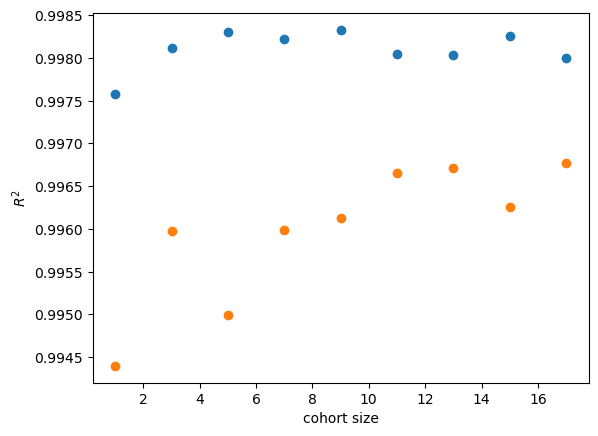

In [97]:
plt.plot(emn,R2_lasso_i.mean(axis=2).detach().numpy().squeeze(),'o')
plt.xlabel('cohort size')
plt.ylabel('$R^2$')

In [84]:
R2_lasso.detach().numpy().T.squeeze()

array([[0.9963857 , 0.99728626, 0.9965006 , 0.99746984, 0.99820733,
        0.99807346, 0.99800724, 0.99701196, 0.9979479 ],
       [0.99216574, 0.99492013, 0.9929704 , 0.9914693 , 0.99564487,
        0.9965277 , 0.9965233 , 0.99712837, 0.9961909 ]], dtype=float32)

Text(0, 0.5, '$R^2$')

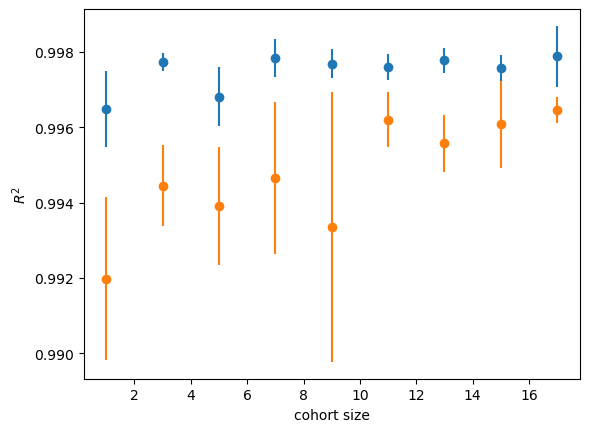

In [100]:
plt.errorbar(emn,R2_lasso.mean(axis=2)[:,0].detach().numpy(),fmt='o',yerr=R2_lasso.std(axis=2)[:,0].detach().numpy())
plt.errorbar(emn,R2_lasso.mean(axis=2)[:,1].detach().numpy(),fmt='o',yerr=R2_lasso.std(axis=2)[:,1].detach().numpy())
plt.xlabel('cohort size')
plt.ylabel('$R^2$')

Text(0, 0.5, '$R^2$')

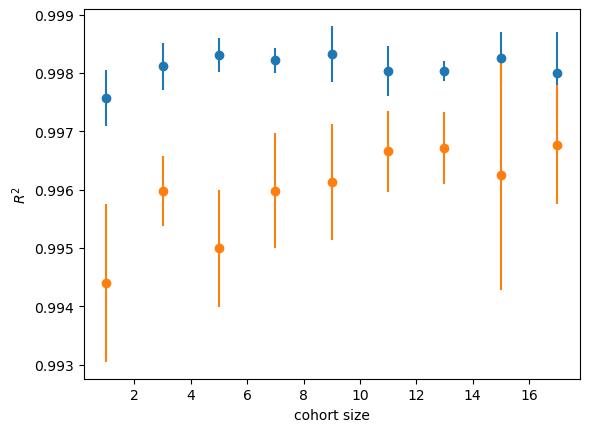

In [101]:
plt.errorbar(emn,R2_lasso_i.mean(axis=2)[:,0].detach().numpy(),fmt='o',yerr=R2_lasso_i.std(axis=2)[:,0].detach().numpy())
plt.errorbar(emn,R2_lasso_i.mean(axis=2)[:,1].detach().numpy(),fmt='o',yerr=R2_lasso_i.std(axis=2)[:,1].detach().numpy())
plt.xlabel('cohort size')
plt.ylabel('$R^2$')

Text(0, 0.5, '$R^2$')

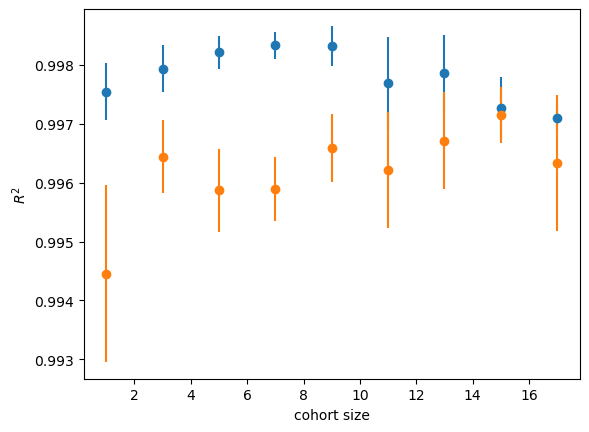

In [103]:
plt.errorbar(emn,R2_all.mean(axis=2)[:,0].detach().numpy(),fmt='o',yerr=R2_all.std(axis=2)[:,0].detach().numpy())
plt.errorbar(emn,R2_all.mean(axis=2)[:,1].detach().numpy(),fmt='o',yerr=R2_all.std(axis=2)[:,1].detach().numpy())
plt.xlabel('cohort size')
plt.ylabel('$R^2$')